# Demo Notebook with simulated RGCs data

In [94]:
%matplotlib inline
%load_ext autoreload
%autoreload 2 
%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [96]:
import numpy as np

In [95]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from collections import OrderedDict
import neuralpredictors as neur
from neuralpredictors.data.datasets import StaticImageSet, FileTreeDataset
import MEI

# Build the dataloaders

The dataloaders object is a dictionary of 3 dictionaries: train, validation and test. Each of them contains the respective data from all datasets combined that were specified in paths. Here we only provide one dataset. While the responses are normalized, we exclude the input images from normalization. The following config was used in the paper (all arguments not in the config have the default value of the function). 

In [6]:
#Use dataloaders with generated RGC data
from lurz2020.datasets.mouse_loaders import static_loaders

paths = ['D://inception_loop/RGC_sim_data/data/static27012021']

dataset_config = {'paths': paths, 
                  'batch_size': 64, 
                  'seed': 1, 
                  'cuda': True,
                  'normalize': True, 
                  'exclude': "images"}

dataloaders_RGCs = static_loaders(**dataset_config)
dat = FileTreeDataset('D://inception_loop/RGC_sim_data/data/static27012021', "images", "responses")

### Look at the data

In [7]:
tier = 'train'
dataset_name = '27012021'

images, responses = [], []
for x, y in dataloaders_RGCs[tier][dataset_name]:
    images.append(x.squeeze().cpu().data.numpy())
    responses.append(y.squeeze().cpu().data.numpy())
    
images = np.vstack(images)
responses = np.vstack(responses)

print('The \"{}\" set of dataset \"{}\" contains the responses of {} RGC neurons to {} images'.format(tier, dataset_name, responses.shape[1], responses.shape[0]))

The "train" set of dataset "27012021" contains the responses of 2304 RGC neurons to 4472 images


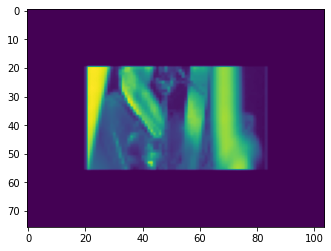

In [9]:
plt.imshow(images[1])

# Build the model, transfer core, train and evaluate performance - grid search

Grid search for FullGaussian readout parameters:

In [15]:
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from lurz2020.models.models import se2d_fullgaussian2d
from lurz2020.training.trainers import standard_trainer as trainer
from lurz2020.utility.measures import get_correlations, get_fraction_oracles

#Define fucntions needed for bayes optimization

def grid_train_se2d_fullgaussian2d_(init_mu_range, init_sigma, gamma_readout):
    
    #Model config
    model_config={'init_mu_range': init_mu_range,
                'init_sigma': init_sigma,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': None,
                'gamma_readout': gamma_readout}

    #Change trainer config to not track and print the training progress
    trainer_config = {'track_training': False,
                  'detach_core': True}
    
    model = se2d_fullgaussian2d(**model_config,dataloaders=dataloaders_RGCs, seed=1)
    
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    
    #Get performance of model
    validation_correlation = get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False)
    
    return validation_correlation

In [16]:
# Bounded region of parameter space
pbounds={'init_mu_range': (0.1,1), 'init_sigma': (0.1,1), 'gamma_readout': (0.0050, 4)}

optimizer_se2d_fullgaussian2d = BayesianOptimization(
    f=grid_train_se2d_fullgaussian2d_,
    pbounds=pbounds,
    random_state=1,
    verbose = 1,
)

In [17]:
%%time 
%%memit

#Set location to save progress and results
logger = JSONLogger(path="./grid_search_fullgaussian2d_logs.json")
optimizer_se2d_fullgaussian2d.subscribe(Events.OPTIMIZATION_STEP, logger)

#Run optimization to maximize the target (corresponding to the correlation between the model predictions and the real responses for the validation set)
#init_points: number of random exploration points
#n_iter: number of exploitation points

optimizer_se2d_fullgaussian2d.maximize(init_points=7, n_iter=7)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[001|00/05] ---> 0.2173013538122177


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[002|00/05] ---> 0.27393442392349243


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[003|00/05] ---> 0.3102562129497528


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[004|00/05] ---> 0.3372291326522827


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[005|00/05] ---> 0.36031845211982727


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[006|00/05] ---> 0.3789675235748291


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[007|00/05] ---> 0.3942824900150299


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[008|00/05] ---> 0.41115909814834595


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[009|00/05] ---> 0.42307940125465393


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[010|00/05] ---> 0.4359830319881439


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[011|00/05] ---> 0.4458255171775818


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[012|00/05] ---> 0.45625749230384827


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[013|00/05] ---> 0.4644336700439453


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[014|00/05] ---> 0.47337210178375244


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[015|00/05] ---> 0.47913476824760437


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[016|00/05] ---> 0.4867112934589386


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[017|00/05] ---> 0.4934735894203186


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[018|00/05] ---> 0.49880579113960266


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[019|00/05] ---> 0.504302978515625


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[020|00/05] ---> 0.5125038623809814


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[021|00/05] ---> 0.5173518657684326


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[022|00/05] ---> 0.5221019983291626


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[023|00/05] ---> 0.5293538570404053


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[024|00/05] ---> 0.5346422791481018


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[025|00/05] ---> 0.538884699344635


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[026|00/05] ---> 0.5434697866439819


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[027|00/05] ---> 0.5479645133018494


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[028|00/05] ---> 0.5531160831451416


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[029|00/05] ---> 0.5580036640167236


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[030|00/05] ---> 0.5587388873100281


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[031|00/05] ---> 0.5611798167228699


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[032|00/05] ---> 0.566290557384491


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[033|00/05] ---> 0.5712339878082275


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[034|00/05] ---> 0.5733960270881653


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[035|00/05] ---> 0.5750731229782104


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[036|00/05] ---> 0.5771546959877014


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[037|00/05] ---> 0.5803565979003906


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[038|00/05] ---> 0.5838998556137085


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[039|00/05] ---> 0.5845388770103455


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[040|00/05] ---> 0.5866175889968872


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[041|00/05] ---> 0.5891652703285217


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[042|01/05] -/-> 0.5883288383483887


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[043|01/05] ---> 0.5912548303604126


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[044|00/05] ---> 0.593269944190979


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[045|00/05] ---> 0.5942762494087219


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[046|00/05] ---> 0.5963118672370911


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[047|01/05] -/-> 0.5957961082458496


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[048|01/05] ---> 0.5981654524803162


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[049|00/05] ---> 0.6019766330718994


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[050|00/05] ---> 0.6025941371917725


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[051|00/05] ---> 0.6036312580108643


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[052|00/05] ---> 0.6057602167129517


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[053|00/05] ---> 0.6060624718666077


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[054|00/05] ---> 0.6071051359176636


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[055|00/05] ---> 0.6103017330169678


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[056|00/05] ---> 0.6104357242584229


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[057|00/05] ---> 0.6109848022460938


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[058|00/05] ---> 0.6128477454185486


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[059|00/05] ---> 0.614100456237793


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[060|00/05] ---> 0.6159471273422241


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[061|01/05] -/-> 0.6159155368804932


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[062|01/05] ---> 0.6166585683822632


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[063|00/05] ---> 0.6191781759262085


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[064|00/05] ---> 0.6214434504508972


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[065|00/05] ---> 0.6220641732215881


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[066|01/05] -/-> 0.620101273059845


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[067|01/05] ---> 0.6241655945777893


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[068|01/05] -/-> 0.6233034133911133


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[069|01/05] ---> 0.6242780685424805


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[070|00/05] ---> 0.6259661912918091


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[071|00/05] ---> 0.6269779205322266


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[072|00/05] ---> 0.6275274753570557


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[073|00/05] ---> 0.6282280683517456


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[074|00/05] ---> 0.6307446956634521


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[075|00/05] ---> 0.6316521763801575


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[076|01/05] -/-> 0.6293319463729858


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[077|02/05] -/-> 0.63016676902771


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[078|03/05] -/-> 0.6315621137619019


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[079|03/05] ---> 0.6317954659461975


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[080|00/05] ---> 0.6352779865264893


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[081|00/05] ---> 0.6354475021362305


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[082|00/05] ---> 0.638422966003418


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[083|00/05] ---> 0.6386159658432007


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[084|00/05] ---> 0.6387305855751038


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[085|00/05] ---> 0.6390966176986694


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[086|00/05] ---> 0.6411960124969482


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[087|01/05] -/-> 0.640222430229187


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[088|01/05] ---> 0.6430199146270752


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[089|01/05] -/-> 0.6424723863601685


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[090|01/05] ---> 0.6441912055015564


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[091|01/05] -/-> 0.6422819495201111


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[092|02/05] -/-> 0.6430413722991943


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[093|02/05] ---> 0.6448214650154114


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[094|01/05] -/-> 0.6424733400344849


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[095|02/05] -/-> 0.6439331769943237


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[096|02/05] ---> 0.644831120967865


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[097|00/05] ---> 0.6448688507080078


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[098|00/05] ---> 0.6475173234939575


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[099|01/05] -/-> 0.6474220752716064


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[100|02/05] -/-> 0.6465296149253845


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[101|02/05] ---> 0.6497917175292969


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[102|00/05] ---> 0.6514430642127991


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[103|01/05] -/-> 0.6500679850578308


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[104|02/05] -/-> 0.6497357487678528


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[105|03/05] -/-> 0.6507297158241272


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[106|04/05] -/-> 0.6510456800460815


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[107|04/05] ---> 0.6523740291595459


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[108|01/05] -/-> 0.6513140201568604


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[109|01/05] ---> 0.6524786353111267


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[110|01/05] -/-> 0.6508080363273621


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[111|01/05] ---> 0.6531267166137695


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[112|00/05] ---> 0.6540271043777466


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[113|01/05] -/-> 0.6524205207824707


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[114|02/05] -/-> 0.6523196697235107


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[115|03/05] -/-> 0.653818666934967


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[116|04/05] -/-> 0.6538211703300476


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[117|04/05] ---> 0.6550703644752502


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[118|00/05] ---> 0.6579101085662842


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[119|01/05] -/-> 0.6565217971801758


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[120|02/05] -/-> 0.6563287973403931


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[121|03/05] -/-> 0.6556577682495117


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[122|04/05] -/-> 0.6548426747322083


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[123|05/05] -/-> 0.6569607853889465


Epoch 124:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.72it/s]

Restoring best model after lr decay! 0.656961 ---> 0.657910


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


Epoch   124: reducing learning rate of group 0 to 1.5000e-03.
[124|01/05] -/-> 0.6556717753410339


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[125|01/05] ---> 0.6601977944374084


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[126|00/05] ---> 0.6606143116950989


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[127|00/05] ---> 0.661076009273529


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[128|00/05] ---> 0.6613622307777405


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[129|01/05] -/-> 0.6587238907814026


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[130|01/05] ---> 0.6626092791557312


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[131|01/05] -/-> 0.6598094701766968


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[132|02/05] -/-> 0.659613311290741


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[133|03/05] -/-> 0.6605610251426697


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[134|04/05] -/-> 0.6621281504631042


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[135|05/05] -/-> 0.6623436808586121


Epoch 136:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.54it/s]

Restoring best model after lr decay! 0.662344 ---> 0.662609


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


Epoch   136: reducing learning rate of group 0 to 4.5000e-04.
[136|01/05] -/-> 0.6610028147697449


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[137|02/05] -/-> 0.6621132493019104


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[138|03/05] -/-> 0.660964846611023


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[139|03/05] ---> 0.6637694835662842


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[140|01/05] -/-> 0.6622621417045593


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[141|02/05] -/-> 0.6629522442817688


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[142|03/05] -/-> 0.6633316874504089


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[143|04/05] -/-> 0.6631938219070435


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[144|05/05] -/-> 0.6635153293609619
Restoring best model after lr decay! 0.663515 ---> 0.663769
Restoring best model! 0.663769 ---> 0.663769


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.20it/s]


[001|00/05] ---> 0.22935019433498383


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.20it/s]


[002|00/05] ---> 0.3208557963371277


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[003|00/05] ---> 0.3953419327735901


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[004|00/05] ---> 0.45713308453559875


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[005|00/05] ---> 0.5081256031990051


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[006|00/05] ---> 0.5472831130027771


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[007|00/05] ---> 0.5794272422790527


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[008|00/05] ---> 0.6102950572967529


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[009|00/05] ---> 0.631180465221405


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[010|00/05] ---> 0.651827871799469


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[011|00/05] ---> 0.6677516102790833


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[012|00/05] ---> 0.6819680333137512


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[013|00/05] ---> 0.6929336190223694


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[014|00/05] ---> 0.7060549259185791


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[015|00/05] ---> 0.7130461931228638


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[016|00/05] ---> 0.724321186542511


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[017|00/05] ---> 0.7312909960746765


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[018|00/05] ---> 0.7373368144035339


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[019|00/05] ---> 0.741878092288971


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[020|00/05] ---> 0.7509676814079285


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[021|00/05] ---> 0.7548001408576965


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[022|00/05] ---> 0.7580716609954834


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[023|00/05] ---> 0.7647172808647156


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[024|00/05] ---> 0.7701622843742371


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[025|01/05] -/-> 0.7693690657615662


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[026|01/05] ---> 0.7741686105728149


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[027|00/05] ---> 0.7778753638267517


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[028|00/05] ---> 0.7843930125236511


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[029|00/05] ---> 0.7875878810882568


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[030|01/05] -/-> 0.7862576246261597


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[031|02/05] -/-> 0.7869349718093872


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[032|02/05] ---> 0.7933357954025269


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[033|00/05] ---> 0.7963542938232422


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[034|00/05] ---> 0.7984424829483032


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[035|01/05] -/-> 0.797443151473999


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[036|02/05] -/-> 0.7982523441314697


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[037|02/05] ---> 0.8002668023109436


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[038|00/05] ---> 0.8043670654296875


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[039|01/05] -/-> 0.8032078146934509


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[040|01/05] ---> 0.8056590557098389


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[041|00/05] ---> 0.8072527647018433


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[042|01/05] -/-> 0.8059413433074951


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[043|01/05] ---> 0.809903085231781


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[044|00/05] ---> 0.8104720711708069


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[045|00/05] ---> 0.8106265068054199


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[046|00/05] ---> 0.8120152950286865


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[047|01/05] -/-> 0.8103551268577576


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[048|02/05] -/-> 0.8116154670715332


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[049|02/05] ---> 0.8159236907958984


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[050|01/05] -/-> 0.8145502805709839


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[051|02/05] -/-> 0.8155437111854553


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[052|02/05] ---> 0.8169546723365784


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[053|01/05] -/-> 0.8161123991012573


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[054|02/05] -/-> 0.8166191577911377


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[055|02/05] ---> 0.8191134929656982


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.06it/s]


[056|01/05] -/-> 0.8169089555740356


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[057|02/05] -/-> 0.8161618709564209


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[058|03/05] -/-> 0.8187954425811768


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[059|04/05] -/-> 0.8189216256141663


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[060|04/05] ---> 0.8201608061790466


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[061|01/05] -/-> 0.8186943531036377


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[062|02/05] -/-> 0.8197057247161865


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[063|02/05] ---> 0.8221169710159302


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[064|00/05] ---> 0.8234390616416931


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[065|00/05] ---> 0.8234474062919617


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[066|01/05] -/-> 0.8204198479652405


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[067|01/05] ---> 0.8247351050376892


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[068|01/05] -/-> 0.8221392035484314


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[069|02/05] -/-> 0.8232489824295044


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[070|03/05] -/-> 0.8246216177940369


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[071|04/05] -/-> 0.8246473073959351


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[072|05/05] -/-> 0.8243581056594849


Epoch 73:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.93it/s]

Restoring best model after lr decay! 0.824358 ---> 0.824735


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


Epoch    73: reducing learning rate of group 0 to 1.5000e-03.
[073|01/05] -/-> 0.8234595060348511


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[074|01/05] ---> 0.830207109451294


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[075|00/05] ---> 0.8334639668464661


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[076|01/05] -/-> 0.8305847644805908


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[077|02/05] -/-> 0.8323557376861572


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[078|03/05] -/-> 0.8327651023864746


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[079|04/05] -/-> 0.8323981761932373


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[080|05/05] -/-> 0.8325841426849365


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 12.06it/s]

Restoring best model after lr decay! 0.832584 ---> 0.833464


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


Epoch    81: reducing learning rate of group 0 to 4.5000e-04.
[081|01/05] -/-> 0.830525815486908


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[082|02/05] -/-> 0.8321492671966553


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[083|03/05] -/-> 0.8333890438079834


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[084|04/05] -/-> 0.8329011797904968


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[085|04/05] ---> 0.8340471982955933


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[086|01/05] -/-> 0.8314557671546936


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[087|02/05] -/-> 0.8322842717170715


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[088|03/05] -/-> 0.8322813510894775


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[089|03/05] ---> 0.834675669670105


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[090|01/05] -/-> 0.8323624134063721


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[091|02/05] -/-> 0.8333963751792908


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[092|02/05] ---> 0.8366259336471558


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[093|01/05] -/-> 0.836053192615509


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[094|02/05] -/-> 0.8334779143333435


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[095|03/05] -/-> 0.8307783603668213


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[096|04/05] -/-> 0.8331323266029358


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[097|05/05] -/-> 0.8354132771492004
Restoring best model after lr decay! 0.835413 ---> 0.836626
Restoring best model! 0.836626 ---> 0.836626


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[001|00/05] ---> 0.1779160052537918


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[002|00/05] ---> 0.22505314648151398


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[003|00/05] ---> 0.27446046471595764


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[004|00/05] ---> 0.32508060336112976


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[005|00/05] ---> 0.37686237692832947


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[006|00/05] ---> 0.425653338432312


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[007|00/05] ---> 0.4673837423324585


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[008|00/05] ---> 0.5054680705070496


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[009|00/05] ---> 0.5343234539031982


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[010|00/05] ---> 0.5613848567008972


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[011|00/05] ---> 0.5846876502037048


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[012|00/05] ---> 0.6065689921379089


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[013|00/05] ---> 0.623538076877594


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[014|00/05] ---> 0.6427664756774902


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[015|00/05] ---> 0.6550581455230713


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[016|00/05] ---> 0.6689144372940063


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[017|00/05] ---> 0.680537760257721


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[018|00/05] ---> 0.6900426149368286


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[019|00/05] ---> 0.7000104188919067


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[020|00/05] ---> 0.7106706500053406


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[021|00/05] ---> 0.7171397805213928


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[022|00/05] ---> 0.7225480079650879


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[023|00/05] ---> 0.7315499782562256


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[024|00/05] ---> 0.7386178970336914


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[025|00/05] ---> 0.7409399747848511


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[026|00/05] ---> 0.7464060187339783


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[027|00/05] ---> 0.7515043616294861


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[028|00/05] ---> 0.7589526176452637


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[029|00/05] ---> 0.7626359462738037


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[030|00/05] ---> 0.7626909613609314


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[031|00/05] ---> 0.763995885848999


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[032|00/05] ---> 0.7710657119750977


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[033|00/05] ---> 0.7752260565757751


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[034|00/05] ---> 0.7769777774810791


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[035|00/05] ---> 0.778177797794342


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[036|00/05] ---> 0.7793086171150208


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[037|00/05] ---> 0.7823356986045837


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[038|00/05] ---> 0.7872480154037476


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[039|01/05] -/-> 0.7861483097076416


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[040|01/05] ---> 0.7894119620323181


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[041|00/05] ---> 0.7918277382850647


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[042|01/05] -/-> 0.7907934188842773


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[043|01/05] ---> 0.7950680255889893


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[044|00/05] ---> 0.7961403131484985


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[045|00/05] ---> 0.7964766621589661


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[046|00/05] ---> 0.7983889579772949


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[047|01/05] -/-> 0.7969292402267456


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[048|01/05] ---> 0.7990715503692627


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[049|00/05] ---> 0.8026109337806702


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[050|01/05] -/-> 0.8022156953811646


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[051|01/05] ---> 0.8031211495399475


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[052|00/05] ---> 0.8049929141998291


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[053|01/05] -/-> 0.8047211170196533


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[054|01/05] ---> 0.8054736256599426


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[055|00/05] ---> 0.8083491325378418


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[056|01/05] -/-> 0.8065335750579834


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[057|02/05] -/-> 0.8067773580551147


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[058|02/05] ---> 0.8097859025001526


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[059|01/05] -/-> 0.8093550801277161


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[060|01/05] ---> 0.8106499910354614


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[061|01/05] -/-> 0.809908926486969


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[062|01/05] ---> 0.8108949065208435


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[063|00/05] ---> 0.812974214553833


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[064|00/05] ---> 0.8142104744911194


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[065|00/05] ---> 0.8144133687019348


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[066|01/05] -/-> 0.8115907311439514


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[067|01/05] ---> 0.8158507943153381


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[068|01/05] -/-> 0.8141441345214844


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[069|02/05] -/-> 0.815464198589325


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[070|02/05] ---> 0.8171461820602417


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[071|00/05] ---> 0.8178713917732239


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[072|01/05] -/-> 0.8177096247673035


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[073|02/05] -/-> 0.8176056742668152


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[074|02/05] ---> 0.8206852674484253


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[075|00/05] ---> 0.8214287161827087


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[076|01/05] -/-> 0.8173110485076904


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[077|02/05] -/-> 0.8171848654747009


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[078|03/05] -/-> 0.8186440467834473


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[079|04/05] -/-> 0.8187652230262756


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[080|04/05] ---> 0.8214884996414185


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[081|00/05] ---> 0.8218508958816528


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[082|00/05] ---> 0.8241694569587708


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[083|01/05] -/-> 0.8237900137901306


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[084|02/05] -/-> 0.8237016201019287


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[085|03/05] -/-> 0.8232048749923706


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[086|03/05] ---> 0.8255493640899658


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[087|01/05] -/-> 0.8226068019866943


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[088|01/05] ---> 0.8257001042366028


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[089|01/05] -/-> 0.8248752355575562


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[090|01/05] ---> 0.8258668184280396


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[091|01/05] -/-> 0.8237279057502747


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[092|02/05] -/-> 0.8244726657867432


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[093|03/05] -/-> 0.8256089091300964


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[094|04/05] -/-> 0.8236088752746582


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[095|05/05] -/-> 0.8246826529502869


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 12.08it/s]

Restoring best model after lr decay! 0.824683 ---> 0.825867


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.8243966698646545


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[097|01/05] ---> 0.8309500217437744


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[098|01/05] -/-> 0.8296236395835876


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[099|01/05] ---> 0.8316304087638855


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[100|00/05] ---> 0.831717312335968


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[101|00/05] ---> 0.8341953754425049


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[102|01/05] -/-> 0.8311998844146729


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[103|01/05] ---> 0.8345715999603271


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[104|01/05] -/-> 0.8327971696853638


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[105|01/05] ---> 0.8362675905227661


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[106|01/05] -/-> 0.8344640135765076


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[107|02/05] -/-> 0.8348479866981506


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[108|03/05] -/-> 0.834594190120697


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[109|04/05] -/-> 0.8346230983734131


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[110|05/05] -/-> 0.8340718746185303


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.91it/s]

Restoring best model after lr decay! 0.834072 ---> 0.836268


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.8342912197113037


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[112|02/05] -/-> 0.836248517036438


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[113|03/05] -/-> 0.8362324237823486


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[114|04/05] -/-> 0.8346854448318481


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[115|05/05] -/-> 0.834236204624176
Restoring best model after lr decay! 0.834236 ---> 0.836268
Restoring best model! 0.836268 ---> 0.836268


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[001|00/05] ---> 0.15200288593769073


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[002|00/05] ---> 0.1827017366886139


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[003|00/05] ---> 0.20511431992053986


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[004|00/05] ---> 0.22852884232997894


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[005|00/05] ---> 0.25281840562820435


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[006|00/05] ---> 0.27891239523887634


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[007|00/05] ---> 0.30518174171447754


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[008|00/05] ---> 0.332659512758255


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[009|00/05] ---> 0.3573721647262573


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[010|00/05] ---> 0.38540560007095337


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[011|00/05] ---> 0.407214492559433


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[012|00/05] ---> 0.4285643398761749


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[013|00/05] ---> 0.4480670690536499


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[014|00/05] ---> 0.4685763716697693


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[015|00/05] ---> 0.48672062158584595


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[016|00/05] ---> 0.502988338470459


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[017|00/05] ---> 0.5165044069290161


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[018|00/05] ---> 0.5299331545829773


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[019|00/05] ---> 0.5419628024101257


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[020|00/05] ---> 0.5562936067581177


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[021|00/05] ---> 0.5669519901275635


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[022|00/05] ---> 0.5774164795875549


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[023|00/05] ---> 0.5877005457878113


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[024|00/05] ---> 0.5977427363395691


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[025|00/05] ---> 0.6042721271514893


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[026|00/05] ---> 0.6116004586219788


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[027|00/05] ---> 0.6200408935546875


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[028|00/05] ---> 0.6300480365753174


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[029|00/05] ---> 0.6373305916786194


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[030|00/05] ---> 0.6420959234237671


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[031|00/05] ---> 0.6473649144172668


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[032|00/05] ---> 0.6568930149078369


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[033|00/05] ---> 0.6665850877761841


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[034|00/05] ---> 0.6720330715179443


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[035|00/05] ---> 0.6768327355384827


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[036|00/05] ---> 0.6814654469490051


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[037|00/05] ---> 0.6869394779205322


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[038|00/05] ---> 0.6946939826011658


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[039|00/05] ---> 0.6967623829841614


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[040|00/05] ---> 0.7031079530715942


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[041|00/05] ---> 0.7085737586021423


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[042|00/05] ---> 0.7106420993804932


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[043|00/05] ---> 0.7191072106361389


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[044|00/05] ---> 0.7216603755950928


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[045|00/05] ---> 0.7255071401596069


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[046|00/05] ---> 0.729195237159729


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[047|00/05] ---> 0.7305904030799866


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[048|00/05] ---> 0.7333648204803467


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[049|00/05] ---> 0.7401261925697327


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[050|00/05] ---> 0.741561770439148


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[051|00/05] ---> 0.744549572467804


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[052|00/05] ---> 0.7472637891769409


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[053|00/05] ---> 0.7482966780662537


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[054|00/05] ---> 0.7499757409095764


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[055|00/05] ---> 0.7535102367401123


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[056|00/05] ---> 0.7539864182472229


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[057|00/05] ---> 0.7548514604568481


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[058|00/05] ---> 0.759454071521759


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[059|00/05] ---> 0.7609903812408447


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[060|00/05] ---> 0.7634819149971008


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[061|00/05] ---> 0.7636792063713074


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[062|00/05] ---> 0.7658315896987915


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[063|00/05] ---> 0.7692294716835022


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[064|00/05] ---> 0.7720656991004944


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[065|00/05] ---> 0.7725803256034851


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[066|01/05] -/-> 0.7709192633628845


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[067|01/05] ---> 0.7754519581794739


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[068|01/05] -/-> 0.7749907970428467


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[069|01/05] ---> 0.7773299217224121


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[070|00/05] ---> 0.7792595028877258


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[071|00/05] ---> 0.7804648280143738


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[072|00/05] ---> 0.7824237942695618


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[073|00/05] ---> 0.7830554246902466


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[074|00/05] ---> 0.7863261699676514


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[075|00/05] ---> 0.7873334884643555


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[076|01/05] -/-> 0.784644603729248


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[077|02/05] -/-> 0.7852518558502197


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[078|03/05] -/-> 0.7871350049972534


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[079|03/05] ---> 0.7892533540725708


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[080|00/05] ---> 0.791820764541626


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[081|00/05] ---> 0.792613685131073


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[082|00/05] ---> 0.7948947548866272


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[083|00/05] ---> 0.7949658632278442


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[084|00/05] ---> 0.795344352722168


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[085|00/05] ---> 0.7967965006828308


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[086|00/05] ---> 0.7992791533470154


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[087|01/05] -/-> 0.7970731258392334


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[088|01/05] ---> 0.8008925318717957


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[089|01/05] -/-> 0.8008021116256714


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[090|01/05] ---> 0.8031259775161743


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[091|01/05] -/-> 0.8011435270309448


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[092|02/05] -/-> 0.8022050857543945


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[093|02/05] ---> 0.8037868142127991


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[094|01/05] -/-> 0.8022247552871704


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[095|01/05] ---> 0.8050082325935364


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[096|00/05] ---> 0.8052927255630493


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[097|00/05] ---> 0.8056303858757019


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[098|00/05] ---> 0.8082746863365173


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[099|01/05] -/-> 0.8075737357139587


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[100|02/05] -/-> 0.8063122034072876


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[101|02/05] ---> 0.8106514811515808


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[102|00/05] ---> 0.8126189112663269


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[103|01/05] -/-> 0.8114859461784363


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[104|02/05] -/-> 0.8103678226470947


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[105|03/05] -/-> 0.8113186359405518


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[106|04/05] -/-> 0.8125789165496826


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[107|04/05] ---> 0.8128530979156494


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[108|01/05] -/-> 0.8119093775749207


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[109|01/05] ---> 0.8135364055633545


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[110|01/05] -/-> 0.811654806137085


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[111|01/05] ---> 0.8145320415496826


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[112|00/05] ---> 0.8158955574035645


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[113|01/05] -/-> 0.8138179183006287


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[114|02/05] -/-> 0.8150622844696045


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[115|03/05] -/-> 0.8148829340934753


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[116|04/05] -/-> 0.8146825432777405


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[117|04/05] ---> 0.8172054290771484


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[118|00/05] ---> 0.8202875852584839


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[119|01/05] -/-> 0.8181833028793335


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[120|02/05] -/-> 0.8170069456100464


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[121|03/05] -/-> 0.8162786960601807


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[122|04/05] -/-> 0.8152505159378052


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[123|05/05] -/-> 0.8174417614936829


Epoch 124:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 12.09it/s]

Restoring best model after lr decay! 0.817442 ---> 0.820288


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch   124: reducing learning rate of group 0 to 1.5000e-03.
[124|01/05] -/-> 0.8173189163208008


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[125|01/05] ---> 0.8226492404937744


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[126|00/05] ---> 0.8233746290206909


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[127|00/05] ---> 0.8234923481941223


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[128|00/05] ---> 0.8240954875946045


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[129|01/05] -/-> 0.8203926086425781


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[130|01/05] ---> 0.8259329199790955


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[131|01/05] -/-> 0.8215258121490479


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[132|02/05] -/-> 0.8214494585990906


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[133|03/05] -/-> 0.8226513862609863


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[134|04/05] -/-> 0.8245080709457397


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[135|05/05] -/-> 0.8249322175979614


Epoch 136:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.51it/s]

Restoring best model after lr decay! 0.824932 ---> 0.825933


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


Epoch   136: reducing learning rate of group 0 to 4.5000e-04.
[136|01/05] -/-> 0.8234164118766785


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[137|02/05] -/-> 0.8249134421348572


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[138|03/05] -/-> 0.8232707977294922


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[139|03/05] ---> 0.8271563649177551


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[140|01/05] -/-> 0.8251309394836426


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[141|02/05] -/-> 0.8259584903717041


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[142|03/05] -/-> 0.8265811204910278


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[143|04/05] -/-> 0.8260657787322998


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[144|05/05] -/-> 0.826568603515625
Restoring best model after lr decay! 0.826569 ---> 0.827156
Restoring best model! 0.827156 ---> 0.827156


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[001|00/05] ---> 0.2087307870388031


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[002|00/05] ---> 0.2582334280014038


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[003|00/05] ---> 0.2906299829483032


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[004|00/05] ---> 0.31394773721694946


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[005|00/05] ---> 0.33624058961868286


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[006|00/05] ---> 0.3516339361667633


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[007|00/05] ---> 0.36392369866371155


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[008|00/05] ---> 0.3761669993400574


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[009|00/05] ---> 0.3845783770084381


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[010|00/05] ---> 0.39483940601348877


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[011|00/05] ---> 0.40288209915161133


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[012|00/05] ---> 0.411650687456131


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[013|00/05] ---> 0.41916874051094055


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[014|00/05] ---> 0.4265812635421753


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[015|00/05] ---> 0.4304819107055664


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[016|00/05] ---> 0.43770062923431396


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[017|00/05] ---> 0.44234272837638855


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[018|00/05] ---> 0.44721856713294983


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[019|00/05] ---> 0.4519728422164917


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[020|00/05] ---> 0.4592471718788147


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[021|00/05] ---> 0.4644547700881958


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[022|00/05] ---> 0.4678906202316284


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[023|00/05] ---> 0.4742337763309479


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[024|00/05] ---> 0.4796174466609955


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[025|00/05] ---> 0.4827190041542053


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[026|00/05] ---> 0.4874078929424286


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[027|00/05] ---> 0.4905755817890167


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[028|00/05] ---> 0.4958789646625519


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[029|00/05] ---> 0.5000526905059814


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[030|00/05] ---> 0.5011836290359497


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[031|00/05] ---> 0.502984881401062


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[032|00/05] ---> 0.5081570744514465


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[033|00/05] ---> 0.5127691626548767


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[034|00/05] ---> 0.5148284435272217


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[035|00/05] ---> 0.5172831416130066


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[036|00/05] ---> 0.5182738304138184


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[037|00/05] ---> 0.52108234167099


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[038|00/05] ---> 0.5244386792182922


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[039|00/05] ---> 0.5252894163131714


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[040|00/05] ---> 0.5277154445648193


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[041|00/05] ---> 0.5303200483322144


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[042|00/05] ---> 0.5303587317466736


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[043|00/05] ---> 0.5332741141319275


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[044|00/05] ---> 0.5345278978347778


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[045|00/05] ---> 0.5365417003631592


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[046|00/05] ---> 0.5378909707069397


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[047|01/05] -/-> 0.5368934273719788


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[048|01/05] ---> 0.5403574705123901


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[049|00/05] ---> 0.5439138412475586


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[050|00/05] ---> 0.5449503064155579


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[051|00/05] ---> 0.5466655492782593


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[052|00/05] ---> 0.5489404201507568


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[053|00/05] ---> 0.549103856086731


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[054|00/05] ---> 0.5515655875205994


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[055|00/05] ---> 0.5539307594299316


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[056|01/05] -/-> 0.5537006855010986


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[057|01/05] ---> 0.5545688271522522


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[058|00/05] ---> 0.5570909976959229


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[059|00/05] ---> 0.5585443377494812


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[060|00/05] ---> 0.5601934194564819


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[061|00/05] ---> 0.5605477690696716


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[062|00/05] ---> 0.5618054866790771


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[063|00/05] ---> 0.5643337965011597


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[064|00/05] ---> 0.5665930509567261


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[065|00/05] ---> 0.5673692226409912


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[066|01/05] -/-> 0.5655583143234253


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[067|01/05] ---> 0.5693995356559753


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[068|01/05] -/-> 0.5685635805130005


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[069|01/05] ---> 0.5702790021896362


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[070|00/05] ---> 0.5718916654586792


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[071|00/05] ---> 0.573269248008728


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[072|00/05] ---> 0.5740984678268433


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[073|00/05] ---> 0.5747972130775452


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[074|00/05] ---> 0.5766783952713013


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[075|00/05] ---> 0.5777966976165771


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[076|01/05] -/-> 0.5758910775184631


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[077|02/05] -/-> 0.5771780610084534


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[078|02/05] ---> 0.5778548717498779


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[079|00/05] ---> 0.5781509280204773


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[080|00/05] ---> 0.5813668370246887


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[081|00/05] ---> 0.5816054940223694


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[082|00/05] ---> 0.584210216999054


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[083|00/05] ---> 0.5845576524734497


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[084|01/05] -/-> 0.5842667818069458


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[085|01/05] ---> 0.5849713087081909


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[086|00/05] ---> 0.5870173573493958


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[087|01/05] -/-> 0.5862185955047607


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[088|01/05] ---> 0.5894017815589905


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[089|00/05] ---> 0.5897067785263062


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[090|00/05] ---> 0.5909138917922974


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[091|01/05] -/-> 0.5902767181396484


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[092|01/05] ---> 0.5910304188728333


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[093|00/05] ---> 0.5926717519760132


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[094|01/05] -/-> 0.5911762714385986


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[095|02/05] -/-> 0.5922020673751831


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[096|02/05] ---> 0.5930435657501221


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[097|00/05] ---> 0.5931983590126038


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[098|00/05] ---> 0.5949395298957825


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[099|00/05] ---> 0.595150887966156


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[100|00/05] ---> 0.5958837270736694


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[101|00/05] ---> 0.5974253416061401


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[102|00/05] ---> 0.5998299717903137


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[103|01/05] -/-> 0.5992260575294495


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[104|02/05] -/-> 0.5987535119056702


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[105|02/05] ---> 0.5998955965042114


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[106|00/05] ---> 0.6003043055534363


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[107|00/05] ---> 0.6013749241828918


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[108|01/05] -/-> 0.6005856990814209


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[109|01/05] ---> 0.6032150387763977


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[110|01/05] -/-> 0.601712703704834


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[111|01/05] ---> 0.6042793989181519


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[112|00/05] ---> 0.6059479117393494


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[113|01/05] -/-> 0.6038968563079834


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[114|02/05] -/-> 0.6045315861701965


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[115|03/05] -/-> 0.6054680943489075


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[116|04/05] -/-> 0.6051822304725647


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[117|04/05] ---> 0.6065646409988403


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[118|00/05] ---> 0.6091315746307373


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[119|01/05] -/-> 0.6079801321029663


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[120|02/05] -/-> 0.6077187061309814


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[121|03/05] -/-> 0.6075312495231628


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[122|04/05] -/-> 0.607035756111145


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[123|04/05] ---> 0.6094269156455994


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[124|01/05] -/-> 0.6083939075469971


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[125|01/05] ---> 0.6111506819725037


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[126|00/05] ---> 0.6114497780799866


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[127|01/05] -/-> 0.6102385520935059


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[128|01/05] ---> 0.6115043759346008


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[129|01/05] -/-> 0.6104949712753296


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[130|01/05] ---> 0.6117350459098816


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[131|01/05] -/-> 0.6111328601837158


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[132|01/05] ---> 0.6120998859405518


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[133|00/05] ---> 0.6127058863639832


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[134|00/05] ---> 0.6130191087722778


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[135|00/05] ---> 0.6135305762290955


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[136|00/05] ---> 0.6157873868942261


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[137|01/05] -/-> 0.6128935217857361


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[138|02/05] -/-> 0.6153037548065186


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[139|03/05] -/-> 0.6151833534240723


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[140|03/05] ---> 0.6167505979537964


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[141|01/05] -/-> 0.6166917085647583


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[142|01/05] ---> 0.6188473701477051


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[143|01/05] -/-> 0.6163367033004761


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[144|02/05] -/-> 0.6176926493644714


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[145|03/05] -/-> 0.617132306098938


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[146|04/05] -/-> 0.6157843470573425


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[147|04/05] ---> 0.6198326945304871


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[148|01/05] -/-> 0.617396354675293


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[149|01/05] ---> 0.6205736994743347


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[150|01/05] -/-> 0.6198263168334961


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[151|02/05] -/-> 0.6204559206962585


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[152|02/05] ---> 0.6214358806610107


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[153|01/05] -/-> 0.6189361214637756


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[154|02/05] -/-> 0.6200471520423889


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[155|02/05] ---> 0.6223405003547668


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[156|00/05] ---> 0.6243455410003662


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[157|01/05] -/-> 0.6228415966033936


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[158|02/05] -/-> 0.6227457523345947


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[159|02/05] ---> 0.6245620250701904


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[160|00/05] ---> 0.6251847147941589


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[161|01/05] -/-> 0.6249680519104004


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[162|01/05] ---> 0.6268818378448486


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[163|01/05] -/-> 0.6266749501228333


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[164|02/05] -/-> 0.6251420378684998


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[165|03/05] -/-> 0.6262425184249878


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[166|03/05] ---> 0.6279709935188293


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[167|01/05] -/-> 0.627191960811615


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[168|01/05] ---> 0.6283316612243652


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[169|01/05] -/-> 0.6265323758125305


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[170|02/05] -/-> 0.6272156834602356


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[171|02/05] ---> 0.6285598874092102


Epoch 172: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[172|00/05] ---> 0.6302599310874939


Epoch 173: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[173|01/05] -/-> 0.6286965608596802


Epoch 174: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[174|02/05] -/-> 0.6276728510856628


Epoch 175: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[175|03/05] -/-> 0.6290411353111267


Epoch 176: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[176|04/05] -/-> 0.6277413964271545


Epoch 177: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[177|05/05] -/-> 0.6293327808380127


Epoch 178:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.629333 ---> 0.630260


Epoch 178: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


Epoch   178: reducing learning rate of group 0 to 1.5000e-03.
[178|01/05] -/-> 0.6275221705436707


Epoch 179: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[179|01/05] ---> 0.6328355073928833


Epoch 180: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[180|00/05] ---> 0.633404552936554


Epoch 181: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[181|00/05] ---> 0.6337334513664246


Epoch 182: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[182|00/05] ---> 0.634052574634552


Epoch 183: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[183|01/05] -/-> 0.6337568759918213


Epoch 184: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[184|01/05] ---> 0.6355268955230713


Epoch 185: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[185|00/05] ---> 0.6358994245529175


Epoch 186: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[186|01/05] -/-> 0.6348655223846436


Epoch 187: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[187|02/05] -/-> 0.6349207758903503


Epoch 188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[188|03/05] -/-> 0.6356862187385559


Epoch 189: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[189|04/05] -/-> 0.6340360641479492


Epoch 190: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[190|05/05] -/-> 0.6354321241378784


Epoch 191:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.38it/s]

Restoring best model after lr decay! 0.635432 ---> 0.635899


Epoch 191: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


Epoch   191: reducing learning rate of group 0 to 4.5000e-04.
[191|01/05] -/-> 0.6350510716438293


Epoch 192: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[192|02/05] -/-> 0.6357917785644531


Epoch 193: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[193|02/05] ---> 0.6359198689460754


Epoch 194: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[194|00/05] ---> 0.636861264705658


Epoch 195: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[195|01/05] -/-> 0.6359331011772156


Epoch 196: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[196|02/05] -/-> 0.6354706287384033


Epoch 197: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[197|03/05] -/-> 0.6367495059967041


Epoch 198: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[198|03/05] ---> 0.6381900906562805


Epoch 199: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[199|01/05] -/-> 0.638087272644043


Epoch 200: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[200|02/05] -/-> 0.6349156498908997
Restoring best model! 0.634916 ---> 0.638190


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[001|00/05] ---> 0.16073544323444366


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[002|00/05] ---> 0.19669502973556519


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[003|00/05] ---> 0.22609087824821472


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[004|00/05] ---> 0.25722068548202515


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[005|00/05] ---> 0.29266610741615295


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[006|00/05] ---> 0.3283565640449524


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[007|00/05] ---> 0.3648883104324341


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[008|00/05] ---> 0.39804336428642273


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[009|00/05] ---> 0.42696356773376465


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[010|00/05] ---> 0.45382940769195557


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[011|00/05] ---> 0.47649845480918884


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[012|00/05] ---> 0.49972835183143616


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[013|00/05] ---> 0.5177894234657288


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[014|00/05] ---> 0.5382511615753174


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[015|00/05] ---> 0.5543591380119324


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[016|00/05] ---> 0.5718722343444824


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[017|00/05] ---> 0.5861761569976807


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[018|00/05] ---> 0.5989401936531067


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[019|00/05] ---> 0.6104132533073425


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[020|00/05] ---> 0.6253761649131775


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[021|00/05] ---> 0.6353772878646851


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[022|00/05] ---> 0.6457284092903137


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[023|00/05] ---> 0.6557883024215698


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[024|00/05] ---> 0.664474368095398


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[025|00/05] ---> 0.6694658398628235


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[026|00/05] ---> 0.6781289577484131


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[027|00/05] ---> 0.6839329600334167


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[028|00/05] ---> 0.6923818588256836


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[029|00/05] ---> 0.6994384527206421


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[030|00/05] ---> 0.701005220413208


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[031|00/05] ---> 0.7061682939529419


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[032|00/05] ---> 0.7150387167930603


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[033|00/05] ---> 0.7220963835716248


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[034|00/05] ---> 0.7255041599273682


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[035|00/05] ---> 0.7282485365867615


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[036|00/05] ---> 0.7305440306663513


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[037|00/05] ---> 0.734798014163971


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[038|00/05] ---> 0.7405270338058472


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[039|00/05] ---> 0.7413666844367981


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[040|00/05] ---> 0.7441645264625549


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[041|00/05] ---> 0.748041033744812


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[042|00/05] ---> 0.7486061453819275


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[043|00/05] ---> 0.7534524202346802


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[044|00/05] ---> 0.7544078230857849


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[045|00/05] ---> 0.7550407648086548


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[046|00/05] ---> 0.7582687139511108


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[047|01/05] -/-> 0.7572093605995178


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[048|01/05] ---> 0.75905442237854


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[049|00/05] ---> 0.7653422951698303


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[050|01/05] -/-> 0.7650051116943359


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[051|01/05] ---> 0.7671487331390381


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[052|00/05] ---> 0.769697368144989


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[053|00/05] ---> 0.7701385021209717


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[054|00/05] ---> 0.7714264988899231


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[055|00/05] ---> 0.7752954959869385


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[056|01/05] -/-> 0.7744138240814209


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[057|02/05] -/-> 0.774791419506073


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[058|02/05] ---> 0.7779513001441956


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[059|00/05] ---> 0.7791717052459717


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[060|00/05] ---> 0.7803013324737549


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[061|00/05] ---> 0.7803415656089783


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[062|00/05] ---> 0.7811498045921326


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[063|00/05] ---> 0.7849270701408386


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[064|00/05] ---> 0.7876266837120056


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[065|00/05] ---> 0.7877610325813293


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[066|01/05] -/-> 0.7855263352394104


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[067|01/05] ---> 0.7904856204986572


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[068|01/05] -/-> 0.7885949611663818


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[069|02/05] -/-> 0.7902253270149231


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[070|02/05] ---> 0.7922982573509216


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[071|01/05] -/-> 0.7918716073036194


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[072|01/05] ---> 0.7928878664970398


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[073|00/05] ---> 0.79356449842453


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[074|00/05] ---> 0.7964402437210083


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[075|00/05] ---> 0.7974960803985596


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[076|01/05] -/-> 0.7942572832107544


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[077|02/05] -/-> 0.7943865656852722


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[078|03/05] -/-> 0.7958618402481079


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[079|04/05] -/-> 0.7965977191925049


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[080|04/05] ---> 0.7991748452186584


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[081|00/05] ---> 0.7996166348457336


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[082|00/05] ---> 0.8029842376708984


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[083|01/05] -/-> 0.8023984432220459


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[084|02/05] -/-> 0.802349328994751


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[085|02/05] ---> 0.8031332492828369


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[086|00/05] ---> 0.8055346608161926


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[087|01/05] -/-> 0.8034881949424744


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[088|01/05] ---> 0.8068501949310303


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[089|00/05] ---> 0.8069206476211548


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[090|00/05] ---> 0.8085798621177673


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[091|01/05] -/-> 0.8065152168273926


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[092|02/05] -/-> 0.8068289160728455


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[093|03/05] -/-> 0.8084569573402405


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[094|04/05] -/-> 0.8057522177696228


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[095|05/05] -/-> 0.807685911655426


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.51it/s]

Restoring best model after lr decay! 0.807686 ---> 0.808580


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.8070549368858337


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[097|01/05] ---> 0.813007652759552


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[098|01/05] -/-> 0.8110888600349426


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[099|01/05] ---> 0.8132274150848389


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[100|00/05] ---> 0.813690721988678


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[101|00/05] ---> 0.8165736198425293


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[102|01/05] -/-> 0.8131354451179504


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[103|01/05] ---> 0.8167316913604736


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[104|01/05] -/-> 0.8148953914642334


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[105|01/05] ---> 0.818213701248169


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[106|01/05] -/-> 0.8162891864776611


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[107|02/05] -/-> 0.8173140287399292


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[108|03/05] -/-> 0.81712406873703


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[109|04/05] -/-> 0.8166148066520691


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[110|05/05] -/-> 0.8162305355072021


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.92it/s]

Restoring best model after lr decay! 0.816231 ---> 0.818214


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.8163852691650391


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[112|01/05] ---> 0.8182165026664734


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[113|01/05] -/-> 0.8180752396583557


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[114|02/05] -/-> 0.8169001340866089


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[115|03/05] -/-> 0.8162926435470581


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[116|04/05] -/-> 0.8172223567962646


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[117|05/05] -/-> 0.8159596920013428
Restoring best model after lr decay! 0.815960 ---> 0.818217
Restoring best model! 0.818217 ---> 0.818217


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[001|00/05] ---> 0.1430823802947998


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[002|00/05] ---> 0.1795993447303772


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[003|00/05] ---> 0.20205934345722198


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[004|00/05] ---> 0.22303363680839539


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[005|00/05] ---> 0.24270984530448914


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[006|00/05] ---> 0.26721566915512085


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[007|00/05] ---> 0.2907159626483917


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[008|00/05] ---> 0.3176354467868805


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[009|00/05] ---> 0.33850765228271484


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[010|00/05] ---> 0.3636080324649811


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[011|00/05] ---> 0.3853233754634857


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[012|00/05] ---> 0.4098423421382904


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[013|00/05] ---> 0.429731160402298


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[014|00/05] ---> 0.44993317127227783


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[015|00/05] ---> 0.4678744077682495


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[016|00/05] ---> 0.4843162000179291


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[017|00/05] ---> 0.4997498095035553


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[018|00/05] ---> 0.5140879154205322


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[019|00/05] ---> 0.5272414684295654


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[020|00/05] ---> 0.5423038005828857


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[021|00/05] ---> 0.5543782711029053


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[022|00/05] ---> 0.5663249492645264


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[023|00/05] ---> 0.57893967628479


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[024|00/05] ---> 0.5890442728996277


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[025|00/05] ---> 0.5963897705078125


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[026|00/05] ---> 0.6084000468254089


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[027|00/05] ---> 0.6174473166465759


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[028|00/05] ---> 0.6295154094696045


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[029|00/05] ---> 0.6382124423980713


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[030|00/05] ---> 0.6438719630241394


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[031|00/05] ---> 0.6497415900230408


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[032|00/05] ---> 0.6616188287734985


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[033|00/05] ---> 0.6697510480880737


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[034|00/05] ---> 0.6754961013793945


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[035|00/05] ---> 0.6800926923751831


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[036|00/05] ---> 0.686585009098053


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[037|00/05] ---> 0.6931717395782471


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[038|00/05] ---> 0.7015452980995178


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[039|00/05] ---> 0.7043983340263367


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[040|00/05] ---> 0.7107588052749634


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[041|00/05] ---> 0.7169777154922485


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[042|00/05] ---> 0.7190081477165222


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[043|00/05] ---> 0.726148784160614


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[044|00/05] ---> 0.7304225564002991


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[045|00/05] ---> 0.7340899109840393


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[046|00/05] ---> 0.739018440246582


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[047|00/05] ---> 0.7394721508026123


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[048|00/05] ---> 0.7443430423736572


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[049|00/05] ---> 0.7509396076202393


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[050|00/05] ---> 0.7530074119567871


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[051|00/05] ---> 0.7570353150367737


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[052|00/05] ---> 0.7599750757217407


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[053|00/05] ---> 0.7616243362426758


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[054|00/05] ---> 0.7643439769744873


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[055|00/05] ---> 0.7688027024269104


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[056|00/05] ---> 0.7705124616622925


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[057|00/05] ---> 0.7711576819419861


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[058|00/05] ---> 0.7757094502449036


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[059|00/05] ---> 0.7777503132820129


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[060|00/05] ---> 0.7806933522224426


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[061|00/05] ---> 0.7813402414321899


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[062|00/05] ---> 0.7832804322242737


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[063|00/05] ---> 0.7871347069740295


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[064|00/05] ---> 0.7899367809295654


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[065|00/05] ---> 0.7920773029327393


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[066|01/05] -/-> 0.7901420593261719


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[067|01/05] ---> 0.7937406897544861


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[068|00/05] ---> 0.7940788269042969


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[069|00/05] ---> 0.7960962653160095


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[070|00/05] ---> 0.7985314130783081


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[071|00/05] ---> 0.8011886477470398


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[072|00/05] ---> 0.801899790763855


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[073|00/05] ---> 0.8021813631057739


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[074|00/05] ---> 0.8058084845542908


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[075|00/05] ---> 0.8077771067619324


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[076|01/05] -/-> 0.8047852516174316


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[077|02/05] -/-> 0.8060973286628723


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[078|02/05] ---> 0.8080817461013794


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[079|00/05] ---> 0.8091542720794678


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[080|00/05] ---> 0.8126930594444275


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[081|00/05] ---> 0.813111424446106


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[082|00/05] ---> 0.8155005574226379


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[083|00/05] ---> 0.8155954480171204


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[084|00/05] ---> 0.8161967992782593


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[085|00/05] ---> 0.8171793818473816


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[086|00/05] ---> 0.8201996684074402


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[087|01/05] -/-> 0.8184571266174316


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[088|01/05] ---> 0.8228738903999329


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[089|01/05] -/-> 0.8226045966148376


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[090|01/05] ---> 0.8241438269615173


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[091|01/05] -/-> 0.8231132626533508


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[092|02/05] -/-> 0.8241012096405029


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[093|02/05] ---> 0.8261077404022217


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[094|01/05] -/-> 0.8244543075561523


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[095|02/05] -/-> 0.8261048793792725


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[096|02/05] ---> 0.8261448740959167


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[097|01/05] -/-> 0.8260378241539001


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[098|01/05] ---> 0.8292903900146484


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[099|00/05] ---> 0.8300520777702332


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[100|01/05] -/-> 0.8284088969230652


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[101|01/05] ---> 0.8328850865364075


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[102|00/05] ---> 0.8353170156478882


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[103|01/05] -/-> 0.8335146307945251


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[104|02/05] -/-> 0.8337244391441345


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[105|03/05] -/-> 0.8348578810691833


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[106|03/05] ---> 0.8364266157150269


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[107|00/05] ---> 0.8367769718170166


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[108|01/05] -/-> 0.8357269763946533


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[109|01/05] ---> 0.8379132747650146


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[110|01/05] -/-> 0.835585355758667


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[111|01/05] ---> 0.8388410210609436


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[112|00/05] ---> 0.8404092788696289


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[113|01/05] -/-> 0.8381530046463013


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[114|02/05] -/-> 0.8385277390480042


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[115|03/05] -/-> 0.8391740918159485


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[116|04/05] -/-> 0.8381441831588745


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[117|05/05] -/-> 0.8403112888336182


Epoch 118:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.51it/s]

Restoring best model after lr decay! 0.840311 ---> 0.840409


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


Epoch   118: reducing learning rate of group 0 to 1.5000e-03.
[118|01/05] -/-> 0.8349349498748779


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[119|01/05] ---> 0.8446013331413269


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[120|00/05] ---> 0.8448584675788879


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[121|00/05] ---> 0.8472906947135925


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[122|00/05] ---> 0.8482129573822021


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[123|01/05] -/-> 0.8461816310882568


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[124|02/05] -/-> 0.8472234010696411


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[125|03/05] -/-> 0.8468021750450134


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[126|04/05] -/-> 0.8471834659576416


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[127|05/05] -/-> 0.8478033542633057


Epoch 128:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 12.09it/s]

Restoring best model after lr decay! 0.847803 ---> 0.848213


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[128|00/05] ---> 0.8485005497932434


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[129|00/05] ---> 0.848656415939331


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[130|01/05] -/-> 0.8461511135101318


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[131|02/05] -/-> 0.8443480730056763


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[132|03/05] -/-> 0.8485622406005859


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[133|04/05] -/-> 0.8460592031478882


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[134|05/05] -/-> 0.8478724956512451
Restoring best model after lr decay! 0.847872 ---> 0.848656
Restoring best model! 0.848656 ---> 0.848656


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[001|00/05] ---> 0.1581696718931198


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[002|00/05] ---> 0.19879688322544098


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[003|00/05] ---> 0.23070386052131653


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[004|00/05] ---> 0.26203978061676025


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[005|00/05] ---> 0.298149436712265


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[006|00/05] ---> 0.3397698402404785


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[007|00/05] ---> 0.3797248899936676


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[008|00/05] ---> 0.4190201759338379


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[009|00/05] ---> 0.45239436626434326


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[010|00/05] ---> 0.48396676778793335


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[011|00/05] ---> 0.5089722871780396


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[012|00/05] ---> 0.535349428653717


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[013|00/05] ---> 0.5577658414840698


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[014|00/05] ---> 0.5815291404724121


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[015|00/05] ---> 0.6018848419189453


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[016|00/05] ---> 0.6226176023483276


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[017|00/05] ---> 0.640313982963562


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[018|00/05] ---> 0.6559849977493286


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[019|00/05] ---> 0.6710473299026489


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[020|00/05] ---> 0.6864132285118103


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[021|00/05] ---> 0.6985485553741455


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[022|00/05] ---> 0.7077195644378662


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[023|00/05] ---> 0.7204434871673584


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[024|00/05] ---> 0.7326081395149231


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[025|00/05] ---> 0.736922025680542


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[026|00/05] ---> 0.7456346154212952


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[027|00/05] ---> 0.7530341148376465


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[028|00/05] ---> 0.7618781328201294


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[029|00/05] ---> 0.7687268853187561


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[030|00/05] ---> 0.7707818150520325


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[031|00/05] ---> 0.7737491130828857


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[032|00/05] ---> 0.7812628746032715


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[033|00/05] ---> 0.788036048412323


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[034|00/05] ---> 0.7915331721305847


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[035|00/05] ---> 0.7940351963043213


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[036|00/05] ---> 0.7974020838737488


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[037|00/05] ---> 0.8007859587669373


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[038|00/05] ---> 0.8063814043998718


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[039|00/05] ---> 0.8067482709884644


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[040|00/05] ---> 0.810967206954956


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[041|00/05] ---> 0.8143285512924194


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[042|01/05] -/-> 0.81334388256073


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[043|01/05] ---> 0.8189672827720642


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[044|00/05] ---> 0.8208373188972473


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[045|00/05] ---> 0.8215779066085815


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[046|00/05] ---> 0.8239179253578186


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[047|01/05] -/-> 0.8235321044921875


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[048|01/05] ---> 0.825625479221344


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[049|00/05] ---> 0.8303312063217163


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[050|01/05] -/-> 0.830174446105957


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[051|01/05] ---> 0.8321545124053955


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[052|00/05] ---> 0.8343967795372009


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[053|01/05] -/-> 0.8340305685997009


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[054|01/05] ---> 0.8356331586837769


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[055|00/05] ---> 0.8393641114234924


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[056|01/05] -/-> 0.8378403782844543


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[057|02/05] -/-> 0.8380725383758545


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[058|02/05] ---> 0.8415755033493042


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[059|00/05] ---> 0.8416532874107361


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[060|00/05] ---> 0.8439836502075195


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[061|01/05] -/-> 0.8429751992225647


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[062|01/05] ---> 0.8446581363677979


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[063|00/05] ---> 0.8470310568809509


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[064|00/05] ---> 0.8485129475593567


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[065|00/05] ---> 0.8490277528762817


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[066|01/05] -/-> 0.8462230563163757


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[067|01/05] ---> 0.8508909344673157


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[068|01/05] -/-> 0.8488490581512451


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[069|02/05] -/-> 0.8503110408782959


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[070|02/05] ---> 0.8511581420898438


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[071|00/05] ---> 0.8522992730140686


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[072|00/05] ---> 0.8523820042610168


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[073|00/05] ---> 0.8526433110237122


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[074|00/05] ---> 0.8554447889328003


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[075|00/05] ---> 0.8567307591438293


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[076|01/05] -/-> 0.8521029949188232


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[077|02/05] -/-> 0.8515430092811584


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[078|03/05] -/-> 0.8529921770095825


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[079|04/05] -/-> 0.8533630967140198


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[080|05/05] -/-> 0.8558390140533447


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 12.06it/s]

Restoring best model after lr decay! 0.855839 ---> 0.856731


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.8552694320678711


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[082|01/05] ---> 0.8616117835044861


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[083|00/05] ---> 0.8641971945762634


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[084|01/05] -/-> 0.864123523235321


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[085|02/05] -/-> 0.8638050556182861


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[086|03/05] -/-> 0.861899197101593


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[087|04/05] -/-> 0.8616057634353638


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[088|04/05] ---> 0.8648286461830139


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[089|01/05] -/-> 0.8633062243461609


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[090|02/05] -/-> 0.8636181354522705


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[091|02/05] ---> 0.8656190037727356


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[092|01/05] -/-> 0.8638951182365417


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[093|01/05] ---> 0.8666557669639587


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[094|01/05] -/-> 0.8637967705726624


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[095|02/05] -/-> 0.8628159761428833


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[096|03/05] -/-> 0.8653275370597839


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[097|04/05] -/-> 0.8646821975708008


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[098|05/05] -/-> 0.8628820776939392


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.94it/s]

Restoring best model after lr decay! 0.862882 ---> 0.866656


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8643696308135986


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[100|01/05] ---> 0.8672313690185547


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[101|00/05] ---> 0.86772221326828


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[102|01/05] -/-> 0.8657345175743103


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[103|02/05] -/-> 0.8657854199409485


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[104|03/05] -/-> 0.8664339780807495


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[105|03/05] ---> 0.8681593537330627


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[106|01/05] -/-> 0.8654366731643677


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[107|02/05] -/-> 0.8655064105987549


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[108|03/05] -/-> 0.86332106590271


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[109|03/05] ---> 0.8707613348960876


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[110|01/05] -/-> 0.8680696487426758


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[111|02/05] -/-> 0.8681619167327881


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[112|03/05] -/-> 0.8688378930091858


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[113|04/05] -/-> 0.8686132431030273


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[114|05/05] -/-> 0.8670193552970886
Restoring best model after lr decay! 0.867019 ---> 0.870761
Restoring best model! 0.870761 ---> 0.870761


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[001|00/05] ---> 0.21176838874816895


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[002|00/05] ---> 0.29063910245895386


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[003|00/05] ---> 0.36815232038497925


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[004|00/05] ---> 0.4386226534843445


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[005|00/05] ---> 0.49691474437713623


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[006|00/05] ---> 0.5437560677528381


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[007|00/05] ---> 0.5822227597236633


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[008|00/05] ---> 0.6156903505325317


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[009|00/05] ---> 0.6399771571159363


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.17it/s]


[010|00/05] ---> 0.6628224849700928


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[011|00/05] ---> 0.6812613010406494


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[012|00/05] ---> 0.6978660821914673


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.17it/s]


[013|00/05] ---> 0.7106310725212097


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[014|00/05] ---> 0.7246524691581726


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[015|00/05] ---> 0.7329065799713135


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[016|00/05] ---> 0.7440064549446106


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[017|00/05] ---> 0.7510371804237366


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[018|00/05] ---> 0.7575544714927673


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[019|00/05] ---> 0.7627838850021362


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[020|00/05] ---> 0.7723913192749023


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[021|00/05] ---> 0.7764444351196289


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[022|00/05] ---> 0.7787883281707764


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[023|00/05] ---> 0.7861716151237488


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[024|00/05] ---> 0.7904285788536072


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[025|01/05] -/-> 0.7888805866241455


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[026|01/05] ---> 0.7937121987342834


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[027|00/05] ---> 0.7964698672294617


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[028|00/05] ---> 0.8028112053871155


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[029|00/05] ---> 0.806241512298584


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[030|01/05] -/-> 0.8041712045669556


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[031|02/05] -/-> 0.804897665977478


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[032|02/05] ---> 0.811199426651001


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[033|00/05] ---> 0.8154969215393066


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[034|00/05] ---> 0.8160350322723389


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[035|01/05] -/-> 0.8157530426979065


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[036|01/05] ---> 0.817316472530365


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[037|00/05] ---> 0.8187887668609619


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[038|00/05] ---> 0.8231050968170166


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[039|01/05] -/-> 0.8208211064338684


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[040|02/05] -/-> 0.8228474855422974


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[041|02/05] ---> 0.8254916667938232


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[042|01/05] -/-> 0.8227046132087708


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[043|01/05] ---> 0.8269451856613159


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[044|00/05] ---> 0.8270702958106995


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[045|00/05] ---> 0.8271375298500061


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[046|00/05] ---> 0.828652024269104


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[047|01/05] -/-> 0.8260481357574463


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[048|02/05] -/-> 0.8278809189796448


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[049|02/05] ---> 0.8307812809944153


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[050|01/05] -/-> 0.8307350873947144


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[051|02/05] -/-> 0.8307076692581177


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[052|02/05] ---> 0.8323308825492859


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[053|01/05] -/-> 0.8319644927978516


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.18it/s]


[054|02/05] -/-> 0.8316285610198975


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[055|02/05] ---> 0.8349473476409912


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[056|01/05] -/-> 0.8330333232879639


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[057|02/05] -/-> 0.8318071365356445


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[058|03/05] -/-> 0.8346620202064514


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[059|04/05] -/-> 0.83473801612854


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[060|04/05] ---> 0.8365933895111084


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[061|01/05] -/-> 0.8347622752189636


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[062|02/05] -/-> 0.8356741666793823


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[063|02/05] ---> 0.8375542759895325


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[064|00/05] ---> 0.8387457728385925


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[065|00/05] ---> 0.839103639125824


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[066|01/05] -/-> 0.8357894420623779


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[067|01/05] ---> 0.8392555117607117


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[068|01/05] -/-> 0.8376446962356567


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[069|02/05] -/-> 0.8388611674308777


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[070|02/05] ---> 0.8392888307571411


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[071|00/05] ---> 0.840408444404602


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[072|01/05] -/-> 0.8401338458061218


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[073|02/05] -/-> 0.8392789363861084


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[074|02/05] ---> 0.8424241542816162


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[075|00/05] ---> 0.8429428935050964


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[076|01/05] -/-> 0.8387899398803711


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[077|02/05] -/-> 0.8394827246665955


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[078|03/05] -/-> 0.840144693851471


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[079|04/05] -/-> 0.8400510549545288


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[080|05/05] -/-> 0.8423120379447937


Epoch 81:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.38it/s]

Restoring best model after lr decay! 0.842312 ---> 0.842943


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


Epoch    81: reducing learning rate of group 0 to 1.5000e-03.
[081|01/05] -/-> 0.841655969619751


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[082|01/05] ---> 0.8483895063400269


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.18it/s]


[083|00/05] ---> 0.8512216210365295


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[084|01/05] -/-> 0.8506872653961182


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[085|02/05] -/-> 0.85066819190979


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.15it/s]


[086|03/05] -/-> 0.8484686017036438


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[087|04/05] -/-> 0.8485548496246338


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[088|04/05] ---> 0.8515875935554504


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[089|01/05] -/-> 0.8500407338142395


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[090|02/05] -/-> 0.8505091071128845


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.12it/s]


[091|02/05] ---> 0.852435827255249


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[092|01/05] -/-> 0.8507109880447388


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[093|01/05] ---> 0.8532136082649231


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[094|01/05] -/-> 0.8503921031951904


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[095|02/05] -/-> 0.8495226502418518


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[096|03/05] -/-> 0.8519814014434814


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[097|04/05] -/-> 0.8510023951530457


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.13it/s]


[098|05/05] -/-> 0.8492187857627869


Epoch 99:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.92it/s]

Restoring best model after lr decay! 0.849219 ---> 0.853214


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


Epoch    99: reducing learning rate of group 0 to 4.5000e-04.
[099|01/05] -/-> 0.8512238264083862


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[100|01/05] ---> 0.8537102937698364


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[101|00/05] ---> 0.8544323444366455


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[102|01/05] -/-> 0.8523709177970886


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.11it/s]


[103|02/05] -/-> 0.8521527051925659


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[104|03/05] -/-> 0.8526992201805115


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[105|03/05] ---> 0.8545266389846802


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[106|01/05] -/-> 0.851958692073822


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[107|02/05] -/-> 0.8517677187919617


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.16it/s]


[108|03/05] -/-> 0.8496516346931458


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[109|03/05] ---> 0.8570002913475037


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.14it/s]


[110|01/05] -/-> 0.8544843196868896


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[111|02/05] -/-> 0.8543374538421631


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[112|03/05] -/-> 0.8550474047660828


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[113|04/05] -/-> 0.8548702597618103


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[114|05/05] -/-> 0.852935791015625
Restoring best model after lr decay! 0.852936 ---> 0.857000
Restoring best model! 0.857000 ---> 0.857000


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[001|00/05] ---> 0.13158059120178223


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[002|00/05] ---> 0.16085730493068695


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[003|00/05] ---> 0.18127727508544922


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[004|00/05] ---> 0.19544999301433563


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[005|00/05] ---> 0.21034963428974152


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[006|00/05] ---> 0.22992484271526337


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[007|00/05] ---> 0.24818775057792664


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[008|00/05] ---> 0.26660674810409546


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[009|00/05] ---> 0.2865571975708008


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[010|00/05] ---> 0.3039415776729584


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[011|00/05] ---> 0.3246783912181854


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[012|00/05] ---> 0.34411880373954773


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[013|00/05] ---> 0.36115625500679016


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[014|00/05] ---> 0.380625456571579


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[015|00/05] ---> 0.39543142914772034


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[016|00/05] ---> 0.4094879925251007


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[017|00/05] ---> 0.42449086904525757


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[018|00/05] ---> 0.4386727511882782


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[019|00/05] ---> 0.45211854577064514


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[020|00/05] ---> 0.4636271893978119


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[021|00/05] ---> 0.4768073856830597


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[022|00/05] ---> 0.48918405175209045


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[023|00/05] ---> 0.5017860531806946


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[024|00/05] ---> 0.5118675231933594


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[025|00/05] ---> 0.5205831527709961


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[026|00/05] ---> 0.5314965844154358


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[027|00/05] ---> 0.5405592322349548


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[028|00/05] ---> 0.5517914891242981


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[029|00/05] ---> 0.560646116733551


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[030|00/05] ---> 0.5650434494018555


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[031|00/05] ---> 0.5719186067581177


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[032|00/05] ---> 0.5807417631149292


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[033|00/05] ---> 0.5907447338104248


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[034|00/05] ---> 0.5968648195266724


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[035|00/05] ---> 0.6006467938423157


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[036|00/05] ---> 0.6049675345420837


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[037|00/05] ---> 0.6121852993965149


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[038|00/05] ---> 0.619785726070404


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[039|00/05] ---> 0.6231777667999268


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[040|00/05] ---> 0.6294127702713013


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[041|00/05] ---> 0.6366754174232483


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[042|00/05] ---> 0.638676106929779


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[043|00/05] ---> 0.6440284848213196


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[044|00/05] ---> 0.6471226215362549


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[045|00/05] ---> 0.6522716879844666


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[046|00/05] ---> 0.6559558510780334


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[047|00/05] ---> 0.6593479514122009


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[048|00/05] ---> 0.6642081141471863


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[049|00/05] ---> 0.6701566576957703


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[050|00/05] ---> 0.6727500557899475


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[051|00/05] ---> 0.6765527725219727


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[052|00/05] ---> 0.6808788776397705


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[053|00/05] ---> 0.6838493943214417


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[054|00/05] ---> 0.6861692070960999


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[055|00/05] ---> 0.6912580132484436


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[056|00/05] ---> 0.693026602268219


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[057|00/05] ---> 0.6944787502288818


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[058|00/05] ---> 0.6987555027008057


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[059|00/05] ---> 0.7018000483512878


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[060|00/05] ---> 0.705410361289978


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[061|00/05] ---> 0.7064487934112549


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[062|00/05] ---> 0.7093308568000793


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[063|00/05] ---> 0.7142425179481506


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[064|00/05] ---> 0.717323362827301


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[065|00/05] ---> 0.7179031372070312


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[066|00/05] ---> 0.7179856896400452


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[067|00/05] ---> 0.7238187193870544


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[068|00/05] ---> 0.7250840663909912


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[069|00/05] ---> 0.7265481352806091


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[070|00/05] ---> 0.7303975820541382


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[071|00/05] ---> 0.7311707735061646


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[072|00/05] ---> 0.7334964275360107


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[073|00/05] ---> 0.7353325486183167


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[074|00/05] ---> 0.738824188709259


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[075|00/05] ---> 0.7414048314094543


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[076|01/05] -/-> 0.7397018074989319


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[077|02/05] -/-> 0.7393357753753662


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[078|02/05] ---> 0.7417221069335938


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[079|00/05] ---> 0.7437946796417236


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[080|00/05] ---> 0.7481109499931335


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[081|00/05] ---> 0.7490597367286682


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[082|00/05] ---> 0.7522143125534058


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[083|00/05] ---> 0.7523438930511475


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[084|00/05] ---> 0.7529057264328003


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[085|00/05] ---> 0.7547407746315002


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[086|00/05] ---> 0.7568855285644531


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[087|01/05] -/-> 0.7565812468528748


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[088|01/05] ---> 0.7604436874389648


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[089|00/05] ---> 0.760479211807251


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[090|00/05] ---> 0.7632870078086853


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[091|01/05] -/-> 0.7626301646232605


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[092|01/05] ---> 0.7642180919647217


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[093|00/05] ---> 0.7666971683502197


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[094|01/05] -/-> 0.7654244899749756


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[095|01/05] ---> 0.7678985595703125


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[096|00/05] ---> 0.7686019539833069


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[097|00/05] ---> 0.7686372995376587


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[098|00/05] ---> 0.7737372517585754


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[099|01/05] -/-> 0.7731263637542725


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[100|02/05] -/-> 0.7729884386062622


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[101|02/05] ---> 0.777299702167511


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[102|00/05] ---> 0.7800278663635254


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[103|01/05] -/-> 0.7781079411506653


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[104|02/05] -/-> 0.7776731848716736


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[105|03/05] -/-> 0.7783783674240112


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[106|04/05] -/-> 0.7798402309417725


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[107|04/05] ---> 0.7818726301193237


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[108|01/05] -/-> 0.7811246514320374


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[109|01/05] ---> 0.7834981679916382


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[110|01/05] -/-> 0.7816988825798035


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[111|01/05] ---> 0.7852336168289185


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[112|00/05] ---> 0.7871691584587097


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[113|01/05] -/-> 0.7846769690513611


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[114|02/05] -/-> 0.7864750623703003


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[115|03/05] -/-> 0.7866224050521851


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[116|04/05] -/-> 0.7868726253509521


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[117|04/05] ---> 0.7892709970474243


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[118|00/05] ---> 0.7933212518692017


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[119|01/05] -/-> 0.7920481562614441


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[120|02/05] -/-> 0.7915247678756714


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[121|03/05] -/-> 0.7917770743370056


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[122|04/05] -/-> 0.7909259796142578


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[123|04/05] ---> 0.7950116395950317


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[124|01/05] -/-> 0.79470294713974


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[125|01/05] ---> 0.799468994140625


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[126|00/05] ---> 0.7994997501373291


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[127|01/05] -/-> 0.7979045510292053


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[128|02/05] -/-> 0.7994420528411865


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[129|03/05] -/-> 0.7973899841308594


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[130|03/05] ---> 0.7995864748954773


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[131|01/05] -/-> 0.7989747524261475


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[132|01/05] ---> 0.7999050617218018


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[133|00/05] ---> 0.8013327717781067


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[134|01/05] -/-> 0.8012353181838989


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[135|01/05] ---> 0.8022467494010925


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[136|00/05] ---> 0.8050335645675659


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[137|01/05] -/-> 0.8014910817146301


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[138|01/05] ---> 0.8050405979156494


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[139|00/05] ---> 0.8052799701690674


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[140|00/05] ---> 0.8073211312294006


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[141|00/05] ---> 0.8083451986312866


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[142|00/05] ---> 0.8117382526397705


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[143|01/05] -/-> 0.8075610995292664


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[144|02/05] -/-> 0.8101233243942261


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[145|03/05] -/-> 0.8080470561981201


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[146|04/05] -/-> 0.8067303895950317


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[147|05/05] -/-> 0.81136554479599


Epoch 148:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.52it/s]

Restoring best model after lr decay! 0.811366 ---> 0.811738


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


Epoch   148: reducing learning rate of group 0 to 1.5000e-03.
[148|01/05] -/-> 0.8083964586257935


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[149|01/05] ---> 0.8164575099945068


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[150|01/05] -/-> 0.8156489729881287


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[151|02/05] -/-> 0.8158242702484131


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[152|03/05] -/-> 0.8114935755729675


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[153|03/05] ---> 0.817025899887085


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[154|01/05] -/-> 0.8154242634773254


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[155|01/05] ---> 0.8191092014312744


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[156|01/05] -/-> 0.8187338709831238


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[157|02/05] -/-> 0.8155933022499084


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[158|03/05] -/-> 0.8185334801673889


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[159|04/05] -/-> 0.8165033459663391


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[160|05/05] -/-> 0.8160070776939392


Epoch 161:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.39it/s]

Restoring best model after lr decay! 0.816007 ---> 0.819109


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


Epoch   161: reducing learning rate of group 0 to 4.5000e-04.
[161|01/05] -/-> 0.8168548345565796


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[162|02/05] -/-> 0.8170273303985596


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[163|02/05] ---> 0.8191751837730408


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[164|01/05] -/-> 0.8176934719085693


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[165|02/05] -/-> 0.8180754780769348


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[166|02/05] ---> 0.8205450773239136


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[167|01/05] -/-> 0.816523015499115


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[168|02/05] -/-> 0.8185554146766663


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[169|03/05] -/-> 0.8203878402709961


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[170|04/05] -/-> 0.8165174126625061


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[171|05/05] -/-> 0.8199551105499268
Restoring best model after lr decay! 0.819955 ---> 0.820545
Restoring best model! 0.820545 ---> 0.820545


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[001|00/05] ---> 0.1327999234199524


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[002|00/05] ---> 0.16671514511108398


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[003|00/05] ---> 0.18652381002902985


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[004|00/05] ---> 0.20424628257751465


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[005|00/05] ---> 0.22066263854503632


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[006|00/05] ---> 0.23892630636692047


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[007|00/05] ---> 0.2573941946029663


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[008|00/05] ---> 0.2754570543766022


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[009|00/05] ---> 0.29289522767066956


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[010|00/05] ---> 0.31212517619132996


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[011|00/05] ---> 0.3285362124443054


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[012|00/05] ---> 0.3482559621334076


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[013|00/05] ---> 0.3655296564102173


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[014|00/05] ---> 0.3836239278316498


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[015|00/05] ---> 0.39845481514930725


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[016|00/05] ---> 0.4134362041950226


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[017|00/05] ---> 0.43118366599082947


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[018|00/05] ---> 0.44408750534057617


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[019|00/05] ---> 0.4584437906742096


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[020|00/05] ---> 0.473895400762558


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[021|00/05] ---> 0.48520925641059875


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[022|00/05] ---> 0.4949522614479065


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[023|00/05] ---> 0.5068455934524536


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[024|00/05] ---> 0.5174631476402283


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[025|00/05] ---> 0.5250067114830017


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[026|00/05] ---> 0.5353471040725708


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[027|00/05] ---> 0.5433084964752197


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[028|00/05] ---> 0.5535518527030945


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[029|00/05] ---> 0.5631155967712402


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[030|00/05] ---> 0.5679070353507996


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[031|00/05] ---> 0.5764639377593994


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[032|00/05] ---> 0.5868228673934937


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[033|00/05] ---> 0.5948578119277954


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[034|00/05] ---> 0.6021773815155029


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[035|00/05] ---> 0.6088234186172485


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[036|00/05] ---> 0.6163783669471741


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[037|00/05] ---> 0.6226755976676941


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[038|00/05] ---> 0.6332223415374756


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[039|00/05] ---> 0.6372241973876953


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[040|00/05] ---> 0.644978404045105


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[041|00/05] ---> 0.6520245671272278


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[042|00/05] ---> 0.6563923954963684


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[043|00/05] ---> 0.6635944247245789


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[044|00/05] ---> 0.6695897579193115


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[045|00/05] ---> 0.6748107075691223


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[046|00/05] ---> 0.6805909276008606


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[047|00/05] ---> 0.6838067770004272


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[048|00/05] ---> 0.6890996098518372


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[049|00/05] ---> 0.6954460144042969


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[050|00/05] ---> 0.6972672939300537


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[051|00/05] ---> 0.700057864189148


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[052|00/05] ---> 0.7042589783668518


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[053|00/05] ---> 0.7073383331298828


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[054|00/05] ---> 0.7101632356643677


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[055|00/05] ---> 0.7153786420822144


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[056|00/05] ---> 0.7175078392028809


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[057|00/05] ---> 0.7197846174240112


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[058|00/05] ---> 0.7237585783004761


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[059|00/05] ---> 0.7266382575035095


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[060|00/05] ---> 0.7304370999336243


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[061|00/05] ---> 0.7319222092628479


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[062|00/05] ---> 0.7345807552337646


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[063|00/05] ---> 0.7385736107826233


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[064|00/05] ---> 0.7419123649597168


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[065|00/05] ---> 0.7445177435874939


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[066|00/05] ---> 0.7448859214782715


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[067|00/05] ---> 0.7501817345619202


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[068|00/05] ---> 0.7510491013526917


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[069|00/05] ---> 0.7545457482337952


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[070|00/05] ---> 0.7576884031295776


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[071|00/05] ---> 0.7601996660232544


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[072|00/05] ---> 0.7627935409545898


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[073|00/05] ---> 0.7647945880889893


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[074|00/05] ---> 0.7684034109115601


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[075|00/05] ---> 0.7710838913917542


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[076|01/05] -/-> 0.7689383029937744


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[077|02/05] -/-> 0.7703920602798462


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[078|02/05] ---> 0.7731297016143799


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[079|00/05] ---> 0.7745919823646545


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[080|00/05] ---> 0.7786895036697388


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[081|00/05] ---> 0.7818329334259033


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[082|00/05] ---> 0.7845808863639832


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[083|00/05] ---> 0.7853283286094666


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[084|00/05] ---> 0.786281168460846


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[085|00/05] ---> 0.7879581451416016


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[086|00/05] ---> 0.7911512851715088


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[087|01/05] -/-> 0.7901036739349365


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[088|01/05] ---> 0.794820249080658


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[089|00/05] ---> 0.7957848310470581


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[090|00/05] ---> 0.7973039150238037


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[091|00/05] ---> 0.797347366809845


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[092|00/05] ---> 0.799146294593811


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[093|00/05] ---> 0.8005819320678711


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[094|01/05] -/-> 0.7987074851989746


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[095|01/05] ---> 0.8009780049324036


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[096|00/05] ---> 0.8021989464759827


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[097|00/05] ---> 0.8027095198631287


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[098|00/05] ---> 0.8055611252784729


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[099|00/05] ---> 0.8061293363571167


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[100|01/05] -/-> 0.8048719763755798


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[101|01/05] ---> 0.8092724084854126


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[102|00/05] ---> 0.8129987716674805


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[103|01/05] -/-> 0.8111146092414856


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[104|02/05] -/-> 0.8110889792442322


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[105|03/05] -/-> 0.8119608759880066


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[106|03/05] ---> 0.8140464425086975


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[107|00/05] ---> 0.8149248957633972


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[108|01/05] -/-> 0.8147538304328918


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[109|01/05] ---> 0.816798210144043


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[110|01/05] -/-> 0.8145012259483337


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[111|01/05] ---> 0.8181435465812683


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[112|00/05] ---> 0.8202889561653137


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[113|01/05] -/-> 0.8193581700325012


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[114|02/05] -/-> 0.8202264308929443


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[115|02/05] ---> 0.8208668828010559


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[116|01/05] -/-> 0.8206931352615356


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[117|01/05] ---> 0.8226940631866455


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[118|00/05] ---> 0.8270642161369324


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[119|01/05] -/-> 0.8255031108856201


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[120|02/05] -/-> 0.8246115446090698


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[121|03/05] -/-> 0.824951171875


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[122|04/05] -/-> 0.8246734142303467


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[123|04/05] ---> 0.8279692530632019


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[124|01/05] -/-> 0.8269211649894714


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[125|01/05] ---> 0.8299161195755005


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[126|00/05] ---> 0.8303637504577637


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[127|01/05] -/-> 0.8290625810623169


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[128|02/05] -/-> 0.830223023891449


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[129|03/05] -/-> 0.8279747366905212


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[130|03/05] ---> 0.830438494682312


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[131|01/05] -/-> 0.8303354978561401


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[132|02/05] -/-> 0.8302991986274719


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[133|02/05] ---> 0.8309771418571472


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[134|00/05] ---> 0.8316008448600769


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[135|00/05] ---> 0.8321497440338135


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[136|00/05] ---> 0.8344468474388123


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[137|01/05] -/-> 0.8303101062774658


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[138|02/05] -/-> 0.8333728313446045


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[139|03/05] -/-> 0.833068311214447


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[140|03/05] ---> 0.8347541093826294


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[141|00/05] ---> 0.8351564407348633


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[142|00/05] ---> 0.8385350704193115


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[143|01/05] -/-> 0.8337910771369934


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[144|02/05] -/-> 0.8370432257652283


Epoch 145: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[145|03/05] -/-> 0.8349992036819458


Epoch 146: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[146|04/05] -/-> 0.8333073854446411


Epoch 147: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[147|05/05] -/-> 0.837101936340332


Epoch 148:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 12.06it/s]

Restoring best model after lr decay! 0.837102 ---> 0.838535


Epoch 148: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


Epoch   148: reducing learning rate of group 0 to 1.5000e-03.
[148|01/05] -/-> 0.8347899317741394


Epoch 149: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[149|01/05] ---> 0.8431434035301208


Epoch 150: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[150|01/05] -/-> 0.8430596590042114


Epoch 151: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[151|01/05] ---> 0.8432458639144897


Epoch 152: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[152|01/05] -/-> 0.840157687664032


Epoch 153: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[153|01/05] ---> 0.8447452187538147


Epoch 154: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[154|01/05] -/-> 0.843398928642273


Epoch 155: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[155|01/05] ---> 0.8471766710281372


Epoch 156: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[156|01/05] -/-> 0.8462081551551819


Epoch 157: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[157|02/05] -/-> 0.8438010811805725


Epoch 158: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[158|03/05] -/-> 0.8463065028190613


Epoch 159: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[159|04/05] -/-> 0.8445441126823425


Epoch 160: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[160|05/05] -/-> 0.8434450626373291


Epoch 161:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.35it/s]

Restoring best model after lr decay! 0.843445 ---> 0.847177


Epoch 161: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


Epoch   161: reducing learning rate of group 0 to 4.5000e-04.
[161|01/05] -/-> 0.8450884819030762


Epoch 162: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[162|02/05] -/-> 0.8454830646514893


Epoch 163: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[163|02/05] ---> 0.8473965525627136


Epoch 164: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[164|01/05] -/-> 0.8458817005157471


Epoch 165: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[165|02/05] -/-> 0.8464040756225586


Epoch 166: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[166|02/05] ---> 0.8483498692512512


Epoch 167: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[167|01/05] -/-> 0.8443176746368408


Epoch 168: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[168|02/05] -/-> 0.8467690348625183


Epoch 169: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[169|03/05] -/-> 0.8476837873458862


Epoch 170: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[170|04/05] -/-> 0.8444398641586304


Epoch 171: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.07it/s]


[171|05/05] -/-> 0.8477251529693604
Restoring best model after lr decay! 0.847725 ---> 0.848350
Restoring best model! 0.848350 ---> 0.848350


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[001|00/05] ---> 0.19232900440692902


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[002|00/05] ---> 0.2467876523733139


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[003|00/05] ---> 0.29321157932281494


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[004|00/05] ---> 0.32966142892837524


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[005|00/05] ---> 0.35988256335258484


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[006|00/05] ---> 0.384117066860199


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[007|00/05] ---> 0.40585169196128845


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[008|00/05] ---> 0.4267289340496063


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[009|00/05] ---> 0.44221755862236023


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[010|00/05] ---> 0.4580213725566864


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[011|00/05] ---> 0.4709382653236389


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[012|00/05] ---> 0.4826147258281708


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[013|00/05] ---> 0.4923044443130493


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[014|00/05] ---> 0.5034798979759216


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[015|00/05] ---> 0.5111430883407593


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[016|00/05] ---> 0.5195756554603577


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[017|00/05] ---> 0.5264120101928711


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[018|00/05] ---> 0.5337250232696533


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[019|00/05] ---> 0.5398308634757996


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[020|00/05] ---> 0.5494663715362549


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[021|00/05] ---> 0.5558399558067322


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[022|00/05] ---> 0.5605189800262451


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[023|00/05] ---> 0.56850665807724


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[024|00/05] ---> 0.5727560520172119


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[025|00/05] ---> 0.5753788352012634


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[026|00/05] ---> 0.5790356397628784


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[027|00/05] ---> 0.5829511284828186


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[028|00/05] ---> 0.5888720154762268


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[029|00/05] ---> 0.5927218198776245


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[030|01/05] -/-> 0.5925684571266174


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[031|01/05] ---> 0.5952268242835999


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[032|00/05] ---> 0.6000885963439941


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[033|00/05] ---> 0.6041910648345947


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[034|00/05] ---> 0.6054040789604187


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[035|00/05] ---> 0.6068692803382874


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[036|00/05] ---> 0.6078794002532959


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[037|00/05] ---> 0.6098695397377014


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[038|00/05] ---> 0.6139174699783325


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[039|00/05] ---> 0.6144216060638428


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[040|00/05] ---> 0.6166672706604004


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[041|00/05] ---> 0.6203818321228027


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[042|01/05] -/-> 0.6197482347488403


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[043|01/05] ---> 0.6230263113975525


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[044|00/05] ---> 0.6238993406295776


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[045|00/05] ---> 0.625078022480011


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[046|00/05] ---> 0.6268765926361084


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[047|01/05] -/-> 0.6257121562957764


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[048|01/05] ---> 0.6274490356445312


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[049|00/05] ---> 0.63160240650177


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[050|00/05] ---> 0.6316554546356201


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.76it/s]


[051|00/05] ---> 0.6322569251060486


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[052|00/05] ---> 0.6352077126502991


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[053|01/05] -/-> 0.6346642971038818


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[054|01/05] ---> 0.6358556151390076


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[055|00/05] ---> 0.6389124393463135


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[056|01/05] -/-> 0.6382810473442078


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[057|02/05] -/-> 0.6388784050941467


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[058|02/05] ---> 0.6411164402961731


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[059|00/05] ---> 0.6418190598487854


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[060|00/05] ---> 0.6435301303863525


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[061|01/05] -/-> 0.6432275772094727


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[062|01/05] ---> 0.6437845230102539


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[063|00/05] ---> 0.6461930871009827


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[064|00/05] ---> 0.648461103439331


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[065|01/05] -/-> 0.6480785608291626


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[066|02/05] -/-> 0.6462720632553101


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[067|02/05] ---> 0.6505794525146484


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[068|01/05] -/-> 0.6490532755851746


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[069|02/05] -/-> 0.6503667831420898


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[070|02/05] ---> 0.6524693369865417


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[071|00/05] ---> 0.6525415778160095


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[072|00/05] ---> 0.6527421474456787


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[073|00/05] ---> 0.6530328989028931


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[074|00/05] ---> 0.6553581953048706


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[075|00/05] ---> 0.6566402912139893


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[076|01/05] -/-> 0.6539943218231201


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[077|02/05] -/-> 0.654056966304779


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[078|03/05] -/-> 0.6558154225349426


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[079|04/05] -/-> 0.6558055877685547


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[080|04/05] ---> 0.6593174338340759


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[081|01/05] -/-> 0.6583889722824097


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[082|01/05] ---> 0.6608890891075134


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[083|00/05] ---> 0.6612805128097534


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[084|00/05] ---> 0.6612817645072937


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[085|00/05] ---> 0.6617294549942017


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[086|00/05] ---> 0.6637203693389893


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[087|01/05] -/-> 0.662456214427948


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[088|01/05] ---> 0.6654926538467407


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[089|01/05] -/-> 0.6651207804679871


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[090|01/05] ---> 0.6663251519203186


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[091|01/05] -/-> 0.664740800857544


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[092|02/05] -/-> 0.6656320095062256


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[093|02/05] ---> 0.667905867099762


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[094|01/05] -/-> 0.6662112474441528


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[095|01/05] ---> 0.667915403842926


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[096|00/05] ---> 0.6691182851791382


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[097|01/05] -/-> 0.6688346862792969


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[098|01/05] ---> 0.6716010570526123


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[099|01/05] -/-> 0.6716002225875854


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[100|02/05] -/-> 0.6714539527893066


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[101|02/05] ---> 0.6748406887054443


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[102|00/05] ---> 0.6773645877838135


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[103|01/05] -/-> 0.6754496097564697


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[104|02/05] -/-> 0.6756767630577087


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[105|03/05] -/-> 0.6767165064811707


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[106|03/05] ---> 0.677413284778595


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[107|00/05] ---> 0.6784859895706177


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[108|01/05] -/-> 0.6775772571563721


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[109|01/05] ---> 0.6795033812522888


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[110|01/05] -/-> 0.6773019433021545


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[111|01/05] ---> 0.6796276569366455


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[112|00/05] ---> 0.681610643863678


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[113|01/05] -/-> 0.6797142028808594


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[114|02/05] -/-> 0.6799106597900391


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[115|03/05] -/-> 0.6797787547111511


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[116|04/05] -/-> 0.6802724003791809


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[117|05/05] -/-> 0.6814258098602295


Epoch 118:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.35it/s]

Restoring best model after lr decay! 0.681426 ---> 0.681611


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


Epoch   118: reducing learning rate of group 0 to 1.5000e-03.
[118|01/05] -/-> 0.6765834093093872


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[119|01/05] ---> 0.6844465136528015


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[120|01/05] -/-> 0.6842419505119324


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[121|01/05] ---> 0.6861245036125183


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[122|00/05] ---> 0.6872779130935669


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[123|01/05] -/-> 0.6851847767829895


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[124|02/05] -/-> 0.6864035129547119


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[125|03/05] -/-> 0.6859024167060852


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[126|04/05] -/-> 0.6859919428825378


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[127|05/05] -/-> 0.6862375736236572


Epoch 128:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.38it/s]

Restoring best model after lr decay! 0.686238 ---> 0.687278


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[128|00/05] ---> 0.6874260306358337


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[129|01/05] -/-> 0.6869679093360901


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[130|02/05] -/-> 0.6849704384803772


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[131|03/05] -/-> 0.6835741400718689


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[132|04/05] -/-> 0.6867048740386963


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.78it/s]


[133|05/05] -/-> 0.6847378611564636
Restoring best model after lr decay! 0.684738 ---> 0.687426
Restoring best model! 0.687426 ---> 0.687426


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[001|00/05] ---> 0.1291520893573761


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[002|00/05] ---> 0.16140195727348328


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[003|00/05] ---> 0.17959970235824585


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[004|00/05] ---> 0.19451841711997986


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[005|00/05] ---> 0.20920249819755554


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[006|00/05] ---> 0.2274482548236847


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[007|00/05] ---> 0.24234628677368164


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[008|00/05] ---> 0.26144009828567505


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[009|00/05] ---> 0.27933651208877563


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[010|00/05] ---> 0.296463280916214


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[011|00/05] ---> 0.31264081597328186


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[012|00/05] ---> 0.33239397406578064


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[013|00/05] ---> 0.3467044532299042


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[014|00/05] ---> 0.3641093075275421


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[015|00/05] ---> 0.38045036792755127


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[016|00/05] ---> 0.3967796564102173


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[017|00/05] ---> 0.41164493560791016


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[018|00/05] ---> 0.4256104528903961


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.69it/s]


[019|00/05] ---> 0.438955157995224


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[020|00/05] ---> 0.4528782069683075


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[021|00/05] ---> 0.4634013772010803


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[022|00/05] ---> 0.47514739632606506


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[023|00/05] ---> 0.48681455850601196


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[024|00/05] ---> 0.4973417818546295


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[025|00/05] ---> 0.5058990120887756


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[026|00/05] ---> 0.5173878073692322


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[027|00/05] ---> 0.5273278951644897


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[028|00/05] ---> 0.5384733080863953


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[029|00/05] ---> 0.5470385551452637


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.75it/s]


[030|00/05] ---> 0.5530190467834473


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[031|00/05] ---> 0.5616596937179565


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[032|00/05] ---> 0.5707849860191345


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[033|00/05] ---> 0.5824673175811768


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[034|00/05] ---> 0.5877764225006104


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.78it/s]


[035|00/05] ---> 0.5926024913787842


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[036|00/05] ---> 0.59776371717453


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[037|00/05] ---> 0.6038998365402222


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[038|00/05] ---> 0.6126747131347656


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[039|00/05] ---> 0.6188104152679443


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.85it/s]


[040|00/05] ---> 0.6250356435775757


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[041|00/05] ---> 0.6324299573898315


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[042|00/05] ---> 0.6385027170181274


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[043|00/05] ---> 0.6455371379852295


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[044|00/05] ---> 0.6512340903282166


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[045|00/05] ---> 0.6539099216461182


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[046|00/05] ---> 0.6590793132781982


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[047|00/05] ---> 0.6610631346702576


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[048|00/05] ---> 0.6662049889564514


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[049|00/05] ---> 0.6736613512039185


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[050|00/05] ---> 0.6760396957397461


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[051|00/05] ---> 0.6804312467575073


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[052|00/05] ---> 0.6854002475738525


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[053|00/05] ---> 0.6882420778274536


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[054|00/05] ---> 0.691889226436615


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[055|00/05] ---> 0.6965744495391846


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[056|00/05] ---> 0.6978221535682678


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[057|00/05] ---> 0.7000597715377808


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[058|00/05] ---> 0.7045746445655823


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[059|00/05] ---> 0.7080238461494446


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[060|00/05] ---> 0.7115204930305481


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[061|00/05] ---> 0.7126312851905823


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[062|00/05] ---> 0.7172085642814636


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[063|00/05] ---> 0.7216659188270569


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[064|00/05] ---> 0.7248746752738953


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[065|00/05] ---> 0.7269801497459412


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[066|01/05] -/-> 0.7267618179321289


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[067|01/05] ---> 0.7327238917350769


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[068|01/05] -/-> 0.7323541045188904


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[069|01/05] ---> 0.7357116341590881


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[070|00/05] ---> 0.7382758259773254


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[071|00/05] ---> 0.739924967288971


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[072|00/05] ---> 0.7426308989524841


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[073|00/05] ---> 0.7438361048698425


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[074|00/05] ---> 0.7490569353103638


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[075|00/05] ---> 0.7522156238555908


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[076|01/05] -/-> 0.749954879283905


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[077|02/05] -/-> 0.7512152194976807


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[078|02/05] ---> 0.7539365887641907


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[079|00/05] ---> 0.7551934719085693


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[080|00/05] ---> 0.7597594857215881


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[081|00/05] ---> 0.7610848546028137


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[082|00/05] ---> 0.7638728022575378


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[083|00/05] ---> 0.7655442357063293


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[084|00/05] ---> 0.7660601735115051


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[085|00/05] ---> 0.7682431936264038


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[086|00/05] ---> 0.7703530788421631


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[087|01/05] -/-> 0.7697845101356506


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[088|01/05] ---> 0.7734546661376953


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[089|00/05] ---> 0.7752332091331482


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[090|00/05] ---> 0.7771832942962646


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[091|01/05] -/-> 0.7765810489654541


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[092|01/05] ---> 0.7786716222763062


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[093|00/05] ---> 0.780929446220398


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[094|01/05] -/-> 0.7793944478034973


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[095|01/05] ---> 0.782119870185852


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[096|00/05] ---> 0.7837309837341309


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[097|00/05] ---> 0.7851298451423645


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[098|00/05] ---> 0.7874735593795776


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[099|00/05] ---> 0.7876576781272888


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[100|01/05] -/-> 0.7871196269989014


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[101|01/05] ---> 0.7924747467041016


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[102|00/05] ---> 0.7955105304718018


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[103|01/05] -/-> 0.794555127620697


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[104|02/05] -/-> 0.7943406701087952


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[105|03/05] -/-> 0.7953718900680542


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[106|03/05] ---> 0.7966940402984619


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[107|00/05] ---> 0.7991166710853577


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[108|01/05] -/-> 0.797852098941803


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[109|01/05] ---> 0.7992938160896301


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.09it/s]


[110|01/05] -/-> 0.7982215881347656


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[111|01/05] ---> 0.8013402819633484


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[112|00/05] ---> 0.8031661510467529


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[113|01/05] -/-> 0.801183819770813


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[114|02/05] -/-> 0.8025256395339966


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[115|03/05] -/-> 0.8025519847869873


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[116|04/05] -/-> 0.8026797771453857


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[117|04/05] ---> 0.8058111071586609


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[118|00/05] ---> 0.8105793595314026


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[119|01/05] -/-> 0.8082042932510376


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.10it/s]


[120|02/05] -/-> 0.8080395460128784


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.06it/s]


[121|03/05] -/-> 0.808968722820282


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[122|04/05] -/-> 0.8074385523796082


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[123|05/05] -/-> 0.8102237582206726


Epoch 124:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.810224 ---> 0.810579


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


Epoch   124: reducing learning rate of group 0 to 1.5000e-03.
[124|01/05] -/-> 0.8080422878265381


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[125|01/05] ---> 0.8137975335121155


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[126|00/05] ---> 0.8143337965011597


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[127|00/05] ---> 0.8153025507926941


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.99it/s]


[128|00/05] ---> 0.8162550330162048


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[129|01/05] -/-> 0.8124901652336121


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[130|01/05] ---> 0.8179808855056763


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[131|01/05] -/-> 0.8142648935317993


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[132|02/05] -/-> 0.8140556216239929


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.05it/s]


[133|03/05] -/-> 0.8152713775634766


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.03it/s]


[134|04/05] -/-> 0.8169384598731995


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[135|05/05] -/-> 0.81740403175354


Epoch 136:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.34it/s]

Restoring best model after lr decay! 0.817404 ---> 0.817981


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


Epoch   136: reducing learning rate of group 0 to 4.5000e-04.
[136|01/05] -/-> 0.816028356552124


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[137|02/05] -/-> 0.8175458908081055


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[138|03/05] -/-> 0.8159382343292236


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.02it/s]


[139|03/05] ---> 0.8198512196540833


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[140|01/05] -/-> 0.8177743554115295


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[141|02/05] -/-> 0.8185073733329773


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[142|03/05] -/-> 0.8192155957221985


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.08it/s]


[143|04/05] -/-> 0.8185765743255615


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.04it/s]


[144|05/05] -/-> 0.8190200328826904
Restoring best model after lr decay! 0.819020 ---> 0.819851
Restoring best model! 0.819851 ---> 0.819851


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[001|00/05] ---> 0.1625165045261383


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[002|00/05] ---> 0.19576555490493774


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[003|00/05] ---> 0.22505542635917664


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[004|00/05] ---> 0.2546379268169403


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[005|00/05] ---> 0.2858950197696686


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[006|00/05] ---> 0.3151604235172272


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[007|00/05] ---> 0.34428131580352783


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[008|00/05] ---> 0.36988502740859985


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[009|00/05] ---> 0.3930988907814026


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[010|00/05] ---> 0.4162038266658783


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[011|00/05] ---> 0.43519604206085205


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[012|00/05] ---> 0.4534870684146881


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[013|00/05] ---> 0.4699234366416931


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[014|00/05] ---> 0.48649099469184875


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[015|00/05] ---> 0.499320924282074


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[016|00/05] ---> 0.5132258534431458


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[017|00/05] ---> 0.5235918760299683


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[018|00/05] ---> 0.5345871448516846


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[019|00/05] ---> 0.5445342659950256


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.71it/s]


[020|00/05] ---> 0.5575780868530273


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.73it/s]


[021|00/05] ---> 0.5662817358970642


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[022|00/05] ---> 0.5731953978538513


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[023|00/05] ---> 0.581406831741333


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[024|00/05] ---> 0.5872063040733337


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[025|00/05] ---> 0.5923711061477661


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.77it/s]


[026|00/05] ---> 0.5993015766143799


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[027|00/05] ---> 0.6036105155944824


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[028|00/05] ---> 0.6094407439231873


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[029|00/05] ---> 0.615315318107605


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[030|00/05] ---> 0.6161324381828308


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.74it/s]


[031|00/05] ---> 0.6204163432121277


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[032|00/05] ---> 0.6288500428199768


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[033|00/05] ---> 0.6348651051521301


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[034|00/05] ---> 0.6366991400718689


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[035|00/05] ---> 0.6403052806854248


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[036|00/05] ---> 0.6428295969963074


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[037|00/05] ---> 0.6469941735267639


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[038|00/05] ---> 0.6507601141929626


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[039|00/05] ---> 0.6526892185211182


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[040|00/05] ---> 0.6557915806770325


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[041|00/05] ---> 0.6600908041000366


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[042|01/05] -/-> 0.6596909761428833


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[043|01/05] ---> 0.664088785648346


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[044|00/05] ---> 0.6674270629882812


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.81it/s]


[045|00/05] ---> 0.6682640910148621


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[046|00/05] ---> 0.6716330051422119


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[047|01/05] -/-> 0.6704232692718506


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.86it/s]


[048|01/05] ---> 0.6718880534172058


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[049|00/05] ---> 0.6773951649665833


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[050|00/05] ---> 0.6780115962028503


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[051|00/05] ---> 0.6799644827842712


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[052|00/05] ---> 0.6827068328857422


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[053|00/05] ---> 0.6832953095436096


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[054|00/05] ---> 0.6847480535507202


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[055|00/05] ---> 0.6879929304122925


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[056|00/05] ---> 0.6880886554718018


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[057|00/05] ---> 0.6892443299293518


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[058|00/05] ---> 0.6912641525268555


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[059|00/05] ---> 0.691705584526062


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[060|00/05] ---> 0.6928070783615112


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[061|01/05] -/-> 0.6928035020828247


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[062|01/05] ---> 0.6946537494659424


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[063|00/05] ---> 0.6977574229240417


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[064|00/05] ---> 0.7005123496055603


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[065|01/05] -/-> 0.7000033259391785


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[066|02/05] -/-> 0.6995925903320312


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[067|02/05] ---> 0.7045100331306458


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.79it/s]


[068|01/05] -/-> 0.7031179666519165


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[069|01/05] ---> 0.7047148942947388


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[070|00/05] ---> 0.7069014310836792


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[071|00/05] ---> 0.7070286273956299


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[072|00/05] ---> 0.7080226540565491


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[073|01/05] -/-> 0.707788348197937


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[074|01/05] ---> 0.7113869190216064


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[075|00/05] ---> 0.7132857441902161


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[076|01/05] -/-> 0.7106698155403137


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.72it/s]


[077|02/05] -/-> 0.7101974487304688


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[078|03/05] -/-> 0.7121798992156982


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[079|04/05] -/-> 0.7118834257125854


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[080|04/05] ---> 0.7152910232543945


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[081|00/05] ---> 0.7158333659172058


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[082|00/05] ---> 0.7185313105583191


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.83it/s]


[083|00/05] ---> 0.7186567783355713


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[084|00/05] ---> 0.7188554406166077


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.91it/s]


[085|00/05] ---> 0.719570517539978


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[086|00/05] ---> 0.7207803726196289


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[087|01/05] -/-> 0.719167947769165


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[088|01/05] ---> 0.7210515737533569


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[089|00/05] ---> 0.7220408916473389


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[090|00/05] ---> 0.7237818837165833


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.80it/s]


[091|01/05] -/-> 0.7220866680145264


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[092|02/05] -/-> 0.7220934629440308


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[093|02/05] ---> 0.7241334319114685


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[094|01/05] -/-> 0.7220529913902283


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[095|02/05] -/-> 0.7238132953643799


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[096|02/05] ---> 0.7244866490364075


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[097|01/05] -/-> 0.7244219779968262


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[098|01/05] ---> 0.7270328998565674


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[099|01/05] -/-> 0.7265996932983398


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.87it/s]


[100|02/05] -/-> 0.7260065078735352


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[101|02/05] ---> 0.7302013039588928


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.01it/s]


[102|00/05] ---> 0.73255455493927


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[103|01/05] -/-> 0.7309048175811768


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[104|02/05] -/-> 0.7298699617385864


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[105|03/05] -/-> 0.7305312752723694


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[106|04/05] -/-> 0.7315657138824463


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[107|05/05] -/-> 0.7324987053871155


Epoch 108:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.91it/s]

Restoring best model after lr decay! 0.732499 ---> 0.732555


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


Epoch   108: reducing learning rate of group 0 to 1.5000e-03.
[108|01/05] -/-> 0.7309914231300354


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[109|01/05] ---> 0.73600834608078


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[110|01/05] -/-> 0.7359637022018433


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[111|02/05] -/-> 0.7348507642745972


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.97it/s]


[112|02/05] ---> 0.7365843653678894


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[113|01/05] -/-> 0.7356429100036621


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[114|02/05] -/-> 0.7363766431808472


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[115|02/05] ---> 0.738617479801178


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[116|01/05] -/-> 0.7384161949157715


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[117|01/05] ---> 0.7387745976448059


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[118|01/05] -/-> 0.735323965549469


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.92it/s]


[119|02/05] -/-> 0.7376931309700012


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[120|03/05] -/-> 0.7368590831756592


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.94it/s]


[121|04/05] -/-> 0.7386815547943115


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.90it/s]


[122|04/05] ---> 0.7400397062301636


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.93it/s]


[123|01/05] -/-> 0.7381789684295654


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.89it/s]


[124|02/05] -/-> 0.7391843199729919


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.96it/s]


[125|03/05] -/-> 0.7384045720100403


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[126|04/05] -/-> 0.7387562394142151


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.98it/s]


[127|05/05] -/-> 0.7390293478965759


Epoch 128:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.93it/s]

Restoring best model after lr decay! 0.739029 ---> 0.740040


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[128|00/05] ---> 0.7401953339576721


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.82it/s]


[129|01/05] -/-> 0.7398041486740112


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.84it/s]


[130|02/05] -/-> 0.738075315952301


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  8.00it/s]


[131|03/05] -/-> 0.7362749576568604


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.88it/s]


[132|04/05] -/-> 0.7401601076126099


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:08<00:00,  7.95it/s]


[133|05/05] -/-> 0.7377755641937256
Restoring best model after lr decay! 0.737776 ---> 0.740195
Restoring best model! 0.740195 ---> 0.740195
peak memory: 2238.57 MiB, increment: 652.41 MiB
Wall time: 5h 27min 9s


In [18]:
#Best parameters combination
optimizer_se2d_fullgaussian2d.max

{'target': 0.8707613348960876,
 'params': {'gamma_readout': 0.9924659085030119,
  'init_mu_range': 0.1,
  'init_sigma': 0.6405239292457786}}

In [21]:
#List of all parameters probed and their corresponding target values 
optimizer_se2d_fullgaussian2d.res

[{'target': 0.6637694835662842,
  'params': {'gamma_readout': 1.671002908786783,
   'init_mu_range': 0.7482920440979423,
   'init_sigma': 0.1001029373356104}},
 {'target': 0.8366259336471558,
  'params': {'gamma_readout': 1.2128186276642,
   'init_mu_range': 0.23208030173540176,
   'init_sigma': 0.183104735291918}},
 {'target': 0.8362675905227661,
  'params': {'gamma_readout': 0.7491095444537953,
   'init_mu_range': 0.411004654338743,
   'init_sigma': 0.457090726807603}},
 {'target': 0.8271563649177551,
  'params': {'gamma_readout': 2.157572852343411,
   'init_mu_range': 0.4772750629629653,
   'init_sigma': 0.7166975503570835}},
 {'target': 0.6381900906562805,
  'params': {'gamma_readout': 0.8217867376774122,
   'init_mu_range': 0.8903056927518509,
   'init_sigma': 0.12464883387813355}},
 {'target': 0.8182165026664734,
  'params': {'gamma_readout': 2.6835177031627166,
   'init_mu_range': 0.4755743221304143,
   'init_sigma': 0.6028208456011764}},
 {'target': 0.848656415939331,
  'params

---------------

Grid search for FullSXF readout parameters:

In [23]:
from lurz2020.models.models import se2d_fullSXF

#Define fucntions needed for bayes optimization
def grid_train_se2d_fullSXF_(init_noise, gamma_readout):
    
    #Model config
    model_config={'init_noise': init_noise,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'gamma_readout': gamma_readout}

    #Change trainer config to not track and print the training progress
    trainer_config = {'track_training': False,
                  'detach_core': True}
    
    model = se2d_fullSXF(**model_config,dataloaders=dataloaders_RGCs, seed=1)
    
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    
    #Get performance of model
    validation_correlation = get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False)
    
    return validation_correlation

In [39]:
# Bounded region of parameter space
pbounds={'init_noise': (1e-05,1e-3), 'gamma_readout': (0, 0.001)}

optimizer_se2d_fullSXF_ = BayesianOptimization(
    f=grid_train_se2d_fullSXF_,
    pbounds=pbounds,
    random_state=1,
    verbose = 1,
)

In [40]:
%%time 
%%memit

#Set location to save progress and results
logger = JSONLogger(path="./grid_search_fullSXF_logs.json")
optimizer_se2d_fullSXF_.subscribe(Events.OPTIMIZATION_STEP, logger)

#Run optimization to maximize the target (corresponding to the correlation between the model predictions and the real responses for the validation set)
#init_points: number of random exploration points
#n_iter: number of exploitation points

optimizer_se2d_fullSXF_.maximize(init_points=4, n_iter=4)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.55it/s]


[001|00/05] ---> 0.3575088083744049


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[002|00/05] ---> 0.48199114203453064


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[003|00/05] ---> 0.5344899296760559


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.54it/s]


[004|00/05] ---> 0.5591811537742615


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.43it/s]


[005|00/05] ---> 0.5753071308135986


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.39it/s]


[006|00/05] ---> 0.581928014755249


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.54it/s]


[007|00/05] ---> 0.5859290361404419


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.48it/s]


[008|00/05] ---> 0.5901461839675903


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


[009|00/05] ---> 0.5947880148887634


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.59it/s]


[010|00/05] ---> 0.5953486561775208


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.42it/s]


[011|00/05] ---> 0.5982840061187744


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


[012|00/05] ---> 0.6007910966873169


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[013|00/05] ---> 0.6010974645614624


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[014|00/05] ---> 0.6017729640007019


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[015|01/05] -/-> 0.5998934507369995


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[016|01/05] ---> 0.6073074340820312


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[017|01/05] -/-> 0.6046485900878906


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[018|02/05] -/-> 0.6030355095863342


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[019|03/05] -/-> 0.6031814217567444


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[020|03/05] ---> 0.6083168387413025


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[021|01/05] -/-> 0.6081799864768982


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[022|02/05] -/-> 0.6074708104133606


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[023|02/05] ---> 0.6112799048423767


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[024|01/05] -/-> 0.6108113527297974


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[025|02/05] -/-> 0.6091043949127197


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[026|03/05] -/-> 0.6093279719352722


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[027|04/05] -/-> 0.6111295819282532


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[028|04/05] ---> 0.6145210862159729


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[029|01/05] -/-> 0.6131747364997864


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[030|02/05] -/-> 0.6109230518341064


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[031|03/05] -/-> 0.6088297367095947


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[032|04/05] -/-> 0.6125338077545166


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[033|04/05] ---> 0.617418646812439


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[034|01/05] -/-> 0.6171520948410034


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[035|02/05] -/-> 0.615311861038208


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[036|03/05] -/-> 0.6153361797332764


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[037|03/05] ---> 0.6178455352783203


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[038|00/05] ---> 0.6207160949707031


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[039|01/05] -/-> 0.620070219039917


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[040|02/05] -/-> 0.6191216707229614


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[041|02/05] ---> 0.6236817240715027


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[042|01/05] -/-> 0.619766116142273


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[043|02/05] -/-> 0.6217911839485168


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[044|02/05] ---> 0.6258655190467834


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.52it/s]


[045|01/05] -/-> 0.6224815249443054


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[046|02/05] -/-> 0.625371515750885


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[047|03/05] -/-> 0.6223027110099792


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[048|04/05] -/-> 0.6225783824920654


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[049|04/05] ---> 0.6302875876426697


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.54it/s]


[050|01/05] -/-> 0.6285725235939026


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[051|02/05] -/-> 0.6230909824371338


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.59it/s]


[052|03/05] -/-> 0.6252714991569519


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[053|03/05] ---> 0.6312112808227539


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[054|01/05] -/-> 0.6255144476890564


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[055|02/05] -/-> 0.6309798359870911


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[056|03/05] -/-> 0.6286420822143555


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[057|04/05] -/-> 0.6290673017501831


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[058|04/05] ---> 0.6328076720237732


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[059|00/05] ---> 0.6373844146728516


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[060|00/05] ---> 0.640453577041626


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[061|01/05] -/-> 0.6378884315490723


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[062|01/05] ---> 0.6426423192024231


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[063|01/05] -/-> 0.6419521570205688


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[064|01/05] ---> 0.6590017676353455


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[065|01/05] -/-> 0.6483986973762512


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[066|02/05] -/-> 0.6538596153259277


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[067|03/05] -/-> 0.6576498746871948


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[068|04/05] -/-> 0.656426191329956


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[069|05/05] -/-> 0.6581342220306396


Epoch 70:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.658134 ---> 0.659002


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


Epoch    70: reducing learning rate of group 0 to 1.5000e-03.
[070|01/05] -/-> 0.6556684970855713


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[071|02/05] -/-> 0.6566920876502991


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[072|03/05] -/-> 0.6584851741790771


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[073|04/05] -/-> 0.6567885875701904


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[074|05/05] -/-> 0.6566627621650696


Epoch 75:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.656663 ---> 0.659002


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[075|01/05] -/-> 0.646795928478241


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


Epoch    76: reducing learning rate of group 0 to 4.5000e-04.
[076|02/05] -/-> 0.6479382514953613


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[077|03/05] -/-> 0.6459527611732483


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[078|04/05] -/-> 0.6485167741775513


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[079|05/05] -/-> 0.648277223110199
Restoring best model after lr decay! 0.648277 ---> 0.659002
Restoring best model! 0.659002 ---> 0.659002


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[001|00/05] ---> 0.3533482849597931


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[002|00/05] ---> 0.4784444570541382


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[003|00/05] ---> 0.5503127574920654


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[004|00/05] ---> 0.651668131351471


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[005|00/05] ---> 0.7384868860244751


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[006|00/05] ---> 0.7879106402397156


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[007|00/05] ---> 0.8099446892738342


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[008|00/05] ---> 0.8223466277122498


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[009|00/05] ---> 0.8280382752418518


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.33it/s]


[010|00/05] ---> 0.8330652713775635


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.58it/s]


[011|00/05] ---> 0.8366061449050903


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[012|00/05] ---> 0.8415290117263794


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[013|00/05] ---> 0.8415882587432861


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.40it/s]


[014|01/05] -/-> 0.841361403465271


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.41it/s]


[015|02/05] -/-> 0.8405763506889343


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[016|02/05] ---> 0.847623884677887


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[017|01/05] -/-> 0.8452101349830627


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[018|02/05] -/-> 0.8444920778274536


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[019|03/05] -/-> 0.8458058834075928


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[020|03/05] ---> 0.8487290143966675


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.50it/s]


[021|00/05] ---> 0.8493553996086121


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.25it/s]


[022|00/05] ---> 0.8495984673500061


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.57it/s]


[023|00/05] ---> 0.852015495300293


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[024|01/05] -/-> 0.8507711887359619


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[025|02/05] -/-> 0.8507359623908997


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[026|03/05] -/-> 0.8511145114898682


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[027|04/05] -/-> 0.8517863750457764


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[028|04/05] ---> 0.8548218011856079


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.59it/s]


[029|01/05] -/-> 0.8519283533096313


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[030|02/05] -/-> 0.851795494556427


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[031|03/05] -/-> 0.852100670337677


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[032|04/05] -/-> 0.8517770171165466


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[033|04/05] ---> 0.8560519814491272


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:13<00:00,  5.16it/s]


[034|01/05] -/-> 0.8547009229660034


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.58it/s]


[035|02/05] -/-> 0.8552640676498413


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.49it/s]


[036|03/05] -/-> 0.8543282151222229


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.43it/s]


[037|04/05] -/-> 0.8533579707145691


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.53it/s]


[038|04/05] ---> 0.8561007976531982


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[039|00/05] ---> 0.8563487529754639


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[040|01/05] -/-> 0.8558362126350403


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[041|01/05] ---> 0.856381356716156


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[042|01/05] -/-> 0.8548765182495117


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[043|01/05] ---> 0.8565950989723206


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[044|00/05] ---> 0.8591632843017578


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[045|01/05] -/-> 0.859080970287323


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[046|02/05] -/-> 0.8589053153991699


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[047|03/05] -/-> 0.8561062216758728


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[048|04/05] -/-> 0.8582232594490051


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[049|05/05] -/-> 0.8583897352218628


Epoch 50:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.858390 ---> 0.859163


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.57it/s]


[050|00/05] ---> 0.8595073223114014


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[051|01/05] -/-> 0.8585568070411682


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[052|02/05] -/-> 0.8580144047737122


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[053|02/05] ---> 0.8598290681838989


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.55it/s]


[054|01/05] -/-> 0.8566303253173828


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[055|01/05] ---> 0.8601217269897461


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[056|01/05] -/-> 0.8583430051803589


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[057|02/05] -/-> 0.8584505915641785


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[058|03/05] -/-> 0.8581734895706177


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[059|04/05] -/-> 0.8594902157783508


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[060|05/05] -/-> 0.8559772968292236


Epoch 61:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.855977 ---> 0.860122


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


Epoch    61: reducing learning rate of group 0 to 1.5000e-03.
[061|01/05] -/-> 0.8583701848983765


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[062|01/05] ---> 0.8694693446159363


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[063|01/05] -/-> 0.8691556453704834


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[064|01/05] ---> 0.8731926679611206


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[065|01/05] -/-> 0.8671835064888


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[066|02/05] -/-> 0.869344174861908


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[067|03/05] -/-> 0.868462324142456


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[068|04/05] -/-> 0.8677063584327698


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[069|05/05] -/-> 0.8672756552696228
Restoring best model after lr decay! 0.867276 ---> 0.873193
Restoring best model! 0.873193 ---> 0.873193


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[001|00/05] ---> 0.3422600030899048


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[002|00/05] ---> 0.4635784327983856


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[003|00/05] ---> 0.5268840789794922


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[004|00/05] ---> 0.5955185890197754


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[005|00/05] ---> 0.6576399207115173


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[006|00/05] ---> 0.6789261698722839


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[007|00/05] ---> 0.6930646896362305


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.55it/s]


[008|00/05] ---> 0.7038465738296509


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[009|00/05] ---> 0.71014404296875


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[010|00/05] ---> 0.7133260369300842


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[011|00/05] ---> 0.7168198823928833


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[012|00/05] ---> 0.7207115888595581


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[013|00/05] ---> 0.7224228382110596


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[014|01/05] -/-> 0.7219374179840088


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[015|02/05] -/-> 0.7213204503059387


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[016|02/05] ---> 0.728738009929657


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[017|01/05] -/-> 0.7271950840950012


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[018|02/05] -/-> 0.7259329557418823


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[019|03/05] -/-> 0.7260312438011169


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[020|03/05] ---> 0.7313014268875122


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[021|00/05] ---> 0.7316035032272339


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[022|01/05] -/-> 0.7306483387947083


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[023|01/05] ---> 0.7343984246253967


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[024|01/05] -/-> 0.7338979244232178


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[025|02/05] -/-> 0.7335992455482483


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[026|03/05] -/-> 0.7323717474937439


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[027|03/05] ---> 0.7349784970283508


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[028|00/05] ---> 0.7385236620903015


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[029|01/05] -/-> 0.7362458109855652


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[030|02/05] -/-> 0.7347314357757568


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[031|03/05] -/-> 0.733603298664093


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[032|04/05] -/-> 0.735843300819397


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[033|04/05] ---> 0.7411877512931824


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[034|00/05] ---> 0.7418181896209717


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[035|01/05] -/-> 0.7409594058990479


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[036|02/05] -/-> 0.7404534816741943


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[037|03/05] -/-> 0.7398037314414978


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[038|03/05] ---> 0.7444658279418945


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[039|01/05] -/-> 0.7439030408859253


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[040|01/05] ---> 0.7457371354103088


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[041|00/05] ---> 0.7488734126091003


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[042|01/05] -/-> 0.7472894191741943


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[043|01/05] ---> 0.7488928437232971


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[044|00/05] ---> 0.7537147998809814


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[045|01/05] -/-> 0.7536216378211975


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[046|01/05] ---> 0.754690945148468


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[047|01/05] -/-> 0.751741886138916


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[048|02/05] -/-> 0.7544987797737122


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[049|02/05] ---> 0.7587506175041199


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[050|01/05] -/-> 0.7587437033653259


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[051|02/05] -/-> 0.7560495734214783


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[052|02/05] ---> 0.7627840042114258


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[053|00/05] ---> 0.7650278210639954


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[054|00/05] ---> 0.7666562795639038


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[055|00/05] ---> 0.772011399269104


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[056|01/05] -/-> 0.7714858651161194


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[057|01/05] ---> 0.7723105549812317


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[058|00/05] ---> 0.7763901948928833


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


[059|00/05] ---> 0.7810142636299133


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[060|00/05] ---> 0.7847529649734497


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[061|00/05] ---> 0.7856484651565552


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[062|00/05] ---> 0.7922241687774658


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[063|00/05] ---> 0.7946886420249939


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[064|00/05] ---> 0.8001858592033386


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[065|00/05] ---> 0.8007963299751282


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[066|00/05] ---> 0.8019396066665649


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[067|00/05] ---> 0.8083663582801819


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[068|00/05] ---> 0.8122625350952148


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[069|00/05] ---> 0.813713788986206


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[070|00/05] ---> 0.816580057144165


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[071|00/05] ---> 0.8268758058547974


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[072|00/05] ---> 0.8288986682891846


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[073|01/05] -/-> 0.8276025652885437


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[074|01/05] ---> 0.8364930748939514


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[075|00/05] ---> 0.8369161486625671


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[076|00/05] ---> 0.8395197987556458


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[077|00/05] ---> 0.8420448303222656


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[078|00/05] ---> 0.842980146408081


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[079|00/05] ---> 0.8477579355239868


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[080|00/05] ---> 0.8506700396537781


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[081|00/05] ---> 0.8513152003288269


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[082|00/05] ---> 0.8563045263290405


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[083|01/05] -/-> 0.8536199927330017


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


[084|01/05] ---> 0.8611847758293152


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.49it/s]


[085|00/05] ---> 0.8613016605377197


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[086|00/05] ---> 0.8629937171936035


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[087|01/05] -/-> 0.8568637371063232


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[088|01/05] ---> 0.8659641742706299


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[089|01/05] -/-> 0.8642494678497314


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[090|01/05] ---> 0.8687637448310852


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[091|01/05] -/-> 0.8673587441444397


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.56it/s]


[092|01/05] ---> 0.8687725067138672


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[093|00/05] ---> 0.8717542886734009


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[094|01/05] -/-> 0.8708616495132446


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[095|01/05] ---> 0.8731958866119385


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[096|00/05] ---> 0.875340461730957


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[097|00/05] ---> 0.8757269382476807


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[098|00/05] ---> 0.8769373893737793


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[099|01/05] -/-> 0.8735429644584656


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[100|02/05] -/-> 0.8742704391479492


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[101|02/05] ---> 0.8811091780662537


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[102|01/05] -/-> 0.8800302147865295


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.51it/s]


[103|02/05] -/-> 0.8789102435112


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[104|03/05] -/-> 0.877579927444458


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[105|04/05] -/-> 0.8798046708106995


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[106|05/05] -/-> 0.8785005211830139


Epoch 107:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.878501 ---> 0.881109


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


Epoch   107: reducing learning rate of group 0 to 1.5000e-03.
[107|01/05] -/-> 0.8781469464302063


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[108|01/05] ---> 0.8898465633392334


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[109|00/05] ---> 0.8898574113845825


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[110|01/05] -/-> 0.8894011378288269


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[111|02/05] -/-> 0.8888242244720459


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[112|03/05] -/-> 0.8894033432006836


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[113|04/05] -/-> 0.887440025806427


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[114|05/05] -/-> 0.8885836005210876


Epoch 115:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.888584 ---> 0.889857


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.8880563378334045


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[116|01/05] ---> 0.8904919028282166


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[117|01/05] -/-> 0.8897717595100403


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[118|02/05] -/-> 0.8879438042640686


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[119|03/05] -/-> 0.8900653123855591


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[120|04/05] -/-> 0.8897626399993896


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[121|04/05] ---> 0.8916184902191162


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[122|01/05] -/-> 0.8906989693641663


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[123|02/05] -/-> 0.8889157772064209


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[124|02/05] ---> 0.8930221199989319


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[125|01/05] -/-> 0.8924424648284912


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[126|02/05] -/-> 0.891143798828125


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[127|03/05] -/-> 0.8890177607536316


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[128|03/05] ---> 0.8935525417327881


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[129|01/05] -/-> 0.8932673335075378


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[130|02/05] -/-> 0.8908960819244385


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[131|03/05] -/-> 0.8883566856384277


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[132|04/05] -/-> 0.8929301500320435


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[133|05/05] -/-> 0.8898446559906006
Restoring best model after lr decay! 0.889845 ---> 0.893553
Restoring best model! 0.893553 ---> 0.893553


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[001|00/05] ---> 0.3500748872756958


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[002|00/05] ---> 0.4731655716896057


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[003|00/05] ---> 0.5345195531845093


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[004|00/05] ---> 0.5939549803733826


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[005|00/05] ---> 0.6349050998687744


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[006|00/05] ---> 0.6402976512908936


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[007|00/05] ---> 0.6483510136604309


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[008|00/05] ---> 0.6555026173591614


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[009|00/05] ---> 0.6608163118362427


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[010|00/05] ---> 0.6629148125648499


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[011|00/05] ---> 0.6654446721076965


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[012|00/05] ---> 0.6691406965255737


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[013|00/05] ---> 0.670505166053772


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[014|01/05] -/-> 0.6700113415718079


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[015|02/05] -/-> 0.6690046191215515


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[016|02/05] ---> 0.6759744882583618


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[017|01/05] -/-> 0.6743699312210083


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[018|02/05] -/-> 0.6733183264732361


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[019|03/05] -/-> 0.6730812788009644


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[020|03/05] ---> 0.6777023077011108


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[021|00/05] ---> 0.6777658462524414


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[022|01/05] -/-> 0.677433431148529


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[023|01/05] ---> 0.6816401481628418


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[024|01/05] -/-> 0.680106520652771


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[025|02/05] -/-> 0.6795048117637634


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[026|03/05] -/-> 0.6786180734634399


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[027|04/05] -/-> 0.6808934807777405


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[028|04/05] ---> 0.6840912699699402


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[029|01/05] -/-> 0.6824422478675842


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[030|02/05] -/-> 0.6808794736862183


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[031|03/05] -/-> 0.6797283291816711


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[032|04/05] -/-> 0.6820967793464661


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[033|04/05] ---> 0.6868259906768799


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[034|00/05] ---> 0.687749445438385


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[035|01/05] -/-> 0.6861045360565186


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[036|02/05] -/-> 0.6873036623001099


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[037|03/05] -/-> 0.6867190599441528


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[038|03/05] ---> 0.6915238499641418


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[039|01/05] -/-> 0.6914026737213135


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[040|02/05] -/-> 0.6901814937591553


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[041|02/05] ---> 0.6923248767852783


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[042|01/05] -/-> 0.6900178790092468


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[043|01/05] ---> 0.692868173122406


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[044|00/05] ---> 0.6962776184082031


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[045|00/05] ---> 0.6966667175292969


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[046|00/05] ---> 0.6979628205299377


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[047|01/05] -/-> 0.6965081095695496


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[048|02/05] -/-> 0.6973653435707092


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[049|02/05] ---> 0.7035555243492126


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[050|01/05] -/-> 0.7030888795852661


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[051|02/05] -/-> 0.6989612579345703


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[052|03/05] -/-> 0.703522801399231


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[053|03/05] ---> 0.7077502012252808


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[054|01/05] -/-> 0.7060064077377319


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[055|01/05] ---> 0.7109730839729309


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[056|00/05] ---> 0.7114849090576172


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[057|00/05] ---> 0.7121440172195435


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[058|00/05] ---> 0.7166716456413269


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.52it/s]


[059|00/05] ---> 0.7204859852790833


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[060|00/05] ---> 0.7244002819061279


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[061|01/05] -/-> 0.7224706411361694


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[062|01/05] ---> 0.7270885109901428


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[063|00/05] ---> 0.7299914360046387


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[064|00/05] ---> 0.7391555309295654


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[065|00/05] ---> 0.7395361661911011


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[066|00/05] ---> 0.7436598539352417


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[067|00/05] ---> 0.7463470101356506


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[068|00/05] ---> 0.7489149570465088


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[069|00/05] ---> 0.7514870166778564


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[070|00/05] ---> 0.7538394927978516


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[071|00/05] ---> 0.7663706541061401


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[072|01/05] -/-> 0.7660528421401978


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.59it/s]


[073|02/05] -/-> 0.7654526829719543


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[074|02/05] ---> 0.7821428775787354


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[075|01/05] -/-> 0.7806766033172607


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[076|01/05] ---> 0.7852409482002258


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[077|00/05] ---> 0.79020756483078


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[078|00/05] ---> 0.7966916561126709


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[079|00/05] ---> 0.8014160394668579


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[080|00/05] ---> 0.8067858815193176


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[081|00/05] ---> 0.8106687664985657


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[082|00/05] ---> 0.8183994293212891


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[083|01/05] -/-> 0.8163648247718811


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[084|01/05] ---> 0.8231378793716431


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[085|00/05] ---> 0.8238628506660461


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[086|00/05] ---> 0.831599235534668


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[087|01/05] -/-> 0.8268177509307861


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[088|01/05] ---> 0.8387005925178528


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[089|01/05] -/-> 0.8381636142730713


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[090|01/05] ---> 0.8442090749740601


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[091|00/05] ---> 0.8476323485374451


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[092|00/05] ---> 0.8497998118400574


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[093|00/05] ---> 0.8554565906524658


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[094|00/05] ---> 0.8560853004455566


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[095|00/05] ---> 0.8606526851654053


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[096|00/05] ---> 0.8660327792167664


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[097|00/05] ---> 0.868392825126648


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[098|00/05] ---> 0.871093213558197


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[099|01/05] -/-> 0.869158148765564


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[100|02/05] -/-> 0.8709373474121094


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[101|02/05] ---> 0.8783655166625977


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[102|00/05] ---> 0.8793591260910034


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[103|01/05] -/-> 0.8783420920372009


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[104|02/05] -/-> 0.8771786689758301


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[105|02/05] ---> 0.8795374631881714


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[106|01/05] -/-> 0.8784634470939636


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[107|01/05] ---> 0.8809785842895508


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[108|01/05] -/-> 0.8773510456085205


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[109|01/05] ---> 0.8817460536956787


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[110|01/05] -/-> 0.8788776397705078


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[111|02/05] -/-> 0.8800398707389832


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[112|02/05] ---> 0.8824592232704163


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[113|01/05] -/-> 0.8790709376335144


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[114|02/05] -/-> 0.8792529702186584


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[115|03/05] -/-> 0.8754806518554688


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[116|04/05] -/-> 0.8793524503707886


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[117|05/05] -/-> 0.8802462816238403


Epoch 118:   0%|                                                                                                              | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.880246 ---> 0.882459


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


Epoch   118: reducing learning rate of group 0 to 1.5000e-03.
[118|01/05] -/-> 0.8750531077384949


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[119|01/05] ---> 0.889873206615448


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[120|01/05] -/-> 0.8871605396270752


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[121|02/05] -/-> 0.8885633945465088


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[122|02/05] ---> 0.8917338252067566


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[123|01/05] -/-> 0.888788640499115


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.48it/s]


[124|02/05] -/-> 0.8902530670166016


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.55it/s]


[125|03/05] -/-> 0.8900830745697021


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.54it/s]


[126|04/05] -/-> 0.8899993896484375


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[127|05/05] -/-> 0.8908964991569519


Epoch 128:   1%|█▍                                                                                                    | 1/70 [00:00<00:09,  7.21it/s]

Restoring best model after lr decay! 0.890896 ---> 0.891734


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


Epoch   128: reducing learning rate of group 0 to 4.5000e-04.
[128|01/05] -/-> 0.8914428353309631


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[129|01/05] ---> 0.8930577039718628


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[130|01/05] -/-> 0.8908303380012512


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[131|02/05] -/-> 0.8883461356163025


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[132|03/05] -/-> 0.893011748790741


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[133|04/05] -/-> 0.8899104595184326


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[134|05/05] -/-> 0.8919141292572021
Restoring best model after lr decay! 0.891914 ---> 0.893058
Restoring best model! 0.893058 ---> 0.893058


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[001|00/05] ---> 0.3235471546649933


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[002|00/05] ---> 0.44039386510849


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[003|00/05] ---> 0.4896390736103058


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[004|00/05] ---> 0.5133072733879089


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[005|00/05] ---> 0.5294477939605713


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[006|00/05] ---> 0.5368872880935669


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[007|00/05] ---> 0.5410581827163696


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[008|00/05] ---> 0.5462343692779541


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[009|00/05] ---> 0.5493639707565308


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[010|00/05] ---> 0.5504491329193115


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[011|00/05] ---> 0.5538870692253113


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[012|00/05] ---> 0.5563976764678955


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[013|00/05] ---> 0.5565907955169678


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.61it/s]


[014|01/05] -/-> 0.5563206076622009


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[015|02/05] -/-> 0.556430995464325


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[016|02/05] ---> 0.5627846121788025


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[017|01/05] -/-> 0.5602110624313354


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[018|02/05] -/-> 0.5581451058387756


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[019|03/05] -/-> 0.5590351819992065


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[020|03/05] ---> 0.5632758140563965


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[021|00/05] ---> 0.5646452903747559


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[022|01/05] -/-> 0.5632543563842773


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[023|01/05] ---> 0.5672146677970886


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[024|01/05] -/-> 0.5658571720123291


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[025|02/05] -/-> 0.5654980540275574


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[026|03/05] -/-> 0.5663673877716064


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[027|04/05] -/-> 0.566020667552948


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[028|04/05] ---> 0.5713311433792114


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[029|00/05] ---> 0.5718543529510498


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[030|01/05] -/-> 0.5686383247375488


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[031|02/05] -/-> 0.564235270023346


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[032|03/05] -/-> 0.5694910287857056


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[033|03/05] ---> 0.5748541951179504


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[034|01/05] -/-> 0.5743202567100525


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[035|02/05] -/-> 0.5709917545318604


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[036|03/05] -/-> 0.5704975724220276


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[037|04/05] -/-> 0.573530912399292


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[038|04/05] ---> 0.5777472257614136


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.63it/s]


[039|01/05] -/-> 0.5776858925819397


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[040|02/05] -/-> 0.5757839679718018


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[041|02/05] ---> 0.5835537314414978


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.60it/s]


[042|01/05] -/-> 0.5754489302635193


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[043|02/05] -/-> 0.5812207460403442


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[044|02/05] ---> 0.5839347839355469


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[045|01/05] -/-> 0.5812163352966309


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[046|02/05] -/-> 0.5832881331443787


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[047|03/05] -/-> 0.5801408290863037


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[048|04/05] -/-> 0.5797051191329956


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[049|04/05] ---> 0.5924450159072876


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[050|01/05] -/-> 0.5900852680206299


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[051|02/05] -/-> 0.5870417952537537


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[052|03/05] -/-> 0.5856037139892578


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[053|03/05] ---> 0.5928947925567627


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[054|01/05] -/-> 0.5868804454803467


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[055|01/05] ---> 0.5933135151863098


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[056|01/05] -/-> 0.5897340774536133


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[057|02/05] -/-> 0.5910628437995911


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[058|03/05] -/-> 0.5898993611335754


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[059|03/05] ---> 0.5984660387039185


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[060|00/05] ---> 0.6004941463470459


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[061|01/05] -/-> 0.6003572940826416


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[062|01/05] ---> 0.6009736061096191


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[063|00/05] ---> 0.6044826507568359


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[064|00/05] ---> 0.6189963221549988


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[065|01/05] -/-> 0.6116703748703003


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[066|02/05] -/-> 0.6183426976203918


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[067|03/05] -/-> 0.6163817644119263


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[068|04/05] -/-> 0.6161636114120483


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[069|05/05] -/-> 0.6166324019432068


Epoch 70:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.616632 ---> 0.618996


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


Epoch    70: reducing learning rate of group 0 to 1.5000e-03.
[070|01/05] -/-> 0.6145667433738708


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[071|02/05] -/-> 0.6116845607757568


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[072|03/05] -/-> 0.6132951974868774


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[073|04/05] -/-> 0.6119988560676575


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[074|05/05] -/-> 0.6115519404411316


Epoch 75:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.611552 ---> 0.618996


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[075|01/05] -/-> 0.6032376289367676


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


Epoch    76: reducing learning rate of group 0 to 4.5000e-04.
[076|02/05] -/-> 0.6049003601074219


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[077|03/05] -/-> 0.6024836897850037


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[078|04/05] -/-> 0.6051197648048401


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[079|05/05] -/-> 0.6048958897590637
Restoring best model after lr decay! 0.604896 ---> 0.618996
Restoring best model! 0.618996 ---> 0.618996


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[001|00/05] ---> 0.3408171236515045


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[002|00/05] ---> 0.459726482629776


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[003|00/05] ---> 0.5099143981933594


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[004|00/05] ---> 0.5344851613044739


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.62it/s]


[005|00/05] ---> 0.5513030290603638


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[006|00/05] ---> 0.5595768690109253


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[007|00/05] ---> 0.5633448362350464


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[008|00/05] ---> 0.5671583414077759


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[009|00/05] ---> 0.5715640187263489


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[010|00/05] ---> 0.5729526877403259


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[011|00/05] ---> 0.5758370757102966


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[012|00/05] ---> 0.5777695775032043


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[013|01/05] -/-> 0.577709436416626


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[014|01/05] ---> 0.5801560282707214


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[015|01/05] -/-> 0.5774863362312317


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[016|01/05] ---> 0.5862418413162231


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[017|01/05] -/-> 0.5822319984436035


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[018|02/05] -/-> 0.5794610977172852


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[019|03/05] -/-> 0.5810754299163818


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[020|04/05] -/-> 0.5852407813072205


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[021|05/05] -/-> 0.5854939818382263


Epoch 22:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.585494 ---> 0.586242


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


Epoch    22: reducing learning rate of group 0 to 1.5000e-03.
[022|01/05] -/-> 0.5807117819786072


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[023|02/05] -/-> 0.5840173363685608


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[024|02/05] ---> 0.5865041017532349


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[025|00/05] ---> 0.5885593891143799


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[026|01/05] -/-> 0.588171124458313


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[027|01/05] ---> 0.5886557698249817


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[028|00/05] ---> 0.5889463424682617


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[029|00/05] ---> 0.5894140005111694


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[030|01/05] -/-> 0.5888426899909973


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[031|01/05] ---> 0.5912356376647949


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[032|01/05] -/-> 0.5889489650726318


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[033|02/05] -/-> 0.5907713770866394


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[034|03/05] -/-> 0.5898218154907227


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[035|04/05] -/-> 0.5888870358467102


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[036|04/05] ---> 0.5918301939964294


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[037|00/05] ---> 0.5922766923904419


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[038|01/05] -/-> 0.5909768342971802


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[039|02/05] -/-> 0.5904757976531982


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[040|03/05] -/-> 0.5902789235115051


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[041|03/05] ---> 0.5928771495819092


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[042|00/05] ---> 0.5935889482498169


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[043|01/05] -/-> 0.5899366736412048


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[044|02/05] -/-> 0.5934587717056274


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[045|03/05] -/-> 0.59209144115448


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[046|03/05] ---> 0.5949677228927612


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[047|01/05] -/-> 0.5922470092773438


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[048|02/05] -/-> 0.593881368637085


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[049|03/05] -/-> 0.5906040668487549


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[050|04/05] -/-> 0.5948002338409424


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[051|04/05] ---> 0.5967633724212646


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[052|01/05] -/-> 0.5934243202209473


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[053|02/05] -/-> 0.5943724513053894


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[054|03/05] -/-> 0.5941221714019775


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[055|04/05] -/-> 0.5944749116897583


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[056|05/05] -/-> 0.5931433439254761


Epoch 57:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.593143 ---> 0.596763


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


Epoch    57: reducing learning rate of group 0 to 4.5000e-04.
[057|01/05] -/-> 0.5938645005226135


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[058|02/05] -/-> 0.5924466252326965


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[059|03/05] -/-> 0.595076322555542


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[060|04/05] -/-> 0.5943315029144287


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[061|05/05] -/-> 0.5945243835449219
Restoring best model after lr decay! 0.594524 ---> 0.596763
Restoring best model! 0.596763 ---> 0.596763


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[001|00/05] ---> 0.37683555483818054


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[002|00/05] ---> 0.5063390731811523


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[003|00/05] ---> 0.5765665769577026


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[004|00/05] ---> 0.6709318161010742


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[005|00/05] ---> 0.7503349184989929


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[006|00/05] ---> 0.793746829032898


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[007|00/05] ---> 0.813060998916626


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[008|00/05] ---> 0.8240317106246948


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[009|00/05] ---> 0.829666018486023


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[010|00/05] ---> 0.834524393081665


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[011|00/05] ---> 0.8376442790031433


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[012|00/05] ---> 0.8422532081604004


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[013|00/05] ---> 0.8422701358795166


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[014|00/05] ---> 0.8428576588630676


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[015|01/05] -/-> 0.8414918184280396


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[016|01/05] ---> 0.8481084108352661


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[017|01/05] -/-> 0.8458084464073181


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[018|02/05] -/-> 0.8442544937133789


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[019|03/05] -/-> 0.8460928797721863


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[020|03/05] ---> 0.8487021327018738


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[021|00/05] ---> 0.8493810296058655


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[022|00/05] ---> 0.8498481512069702


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[023|00/05] ---> 0.8520293235778809


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[024|01/05] -/-> 0.8502283096313477


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[025|02/05] -/-> 0.850427508354187


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[026|03/05] -/-> 0.8508114218711853


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.64it/s]


[027|04/05] -/-> 0.8516536355018616


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[028|04/05] ---> 0.8555440902709961


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[029|01/05] -/-> 0.8519681692123413


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[030|02/05] -/-> 0.8515980243682861


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[031|03/05] -/-> 0.8516769409179688


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[032|04/05] -/-> 0.8515003323554993


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[033|04/05] ---> 0.8561993837356567


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[034|01/05] -/-> 0.8548324108123779


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[035|02/05] -/-> 0.8547893166542053


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[036|03/05] -/-> 0.8540179133415222


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[037|04/05] -/-> 0.853204071521759


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[038|05/05] -/-> 0.8560628890991211


Epoch 39:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.856063 ---> 0.856199


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


Epoch    39: reducing learning rate of group 0 to 1.5000e-03.
[039|01/05] -/-> 0.8539062142372131


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[040|01/05] ---> 0.8646585941314697


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[041|00/05] ---> 0.8681381940841675


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[042|00/05] ---> 0.8687516450881958


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[043|01/05] -/-> 0.8626854419708252


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[044|02/05] -/-> 0.8668663501739502


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[045|03/05] -/-> 0.8651434779167175


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[046|04/05] -/-> 0.8674314022064209


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[047|05/05] -/-> 0.863068163394928


Epoch 48:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.863068 ---> 0.868752


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


Epoch    48: reducing learning rate of group 0 to 4.5000e-04.
[048|01/05] -/-> 0.8651807308197021


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[049|01/05] ---> 0.8691142797470093


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[050|01/05] -/-> 0.8675520420074463


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[051|02/05] -/-> 0.8657306432723999


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[052|03/05] -/-> 0.8675928711891174


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[053|04/05] -/-> 0.8676624298095703


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[054|05/05] -/-> 0.8628249168395996
Restoring best model after lr decay! 0.862825 ---> 0.869114
Restoring best model! 0.869114 ---> 0.869114


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[001|00/05] ---> 0.3643980026245117


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[002|00/05] ---> 0.48973363637924194


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[003|00/05] ---> 0.5611075162887573


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[004|00/05] ---> 0.6597912311553955


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.65it/s]


[005|00/05] ---> 0.7445057034492493


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[006|00/05] ---> 0.7912203669548035


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[007|00/05] ---> 0.8114491701126099


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[008|00/05] ---> 0.8233779072761536


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[009|00/05] ---> 0.8285192847251892


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[010|00/05] ---> 0.8339604139328003


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[011|00/05] ---> 0.8376203179359436


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.79it/s]


[012|00/05] ---> 0.841759443283081


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[013|00/05] ---> 0.8422033786773682


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[014|00/05] ---> 0.8423849940299988


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[015|01/05] -/-> 0.8411520719528198


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[016|01/05] ---> 0.848140299320221


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[017|01/05] -/-> 0.845870316028595


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[018|02/05] -/-> 0.8446507453918457


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[019|03/05] -/-> 0.8464133143424988


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[020|03/05] ---> 0.8491051197052002


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[021|00/05] ---> 0.8496763110160828


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[022|00/05] ---> 0.8499782681465149


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[023|00/05] ---> 0.8523985743522644


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[024|01/05] -/-> 0.8507855534553528


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[025|02/05] -/-> 0.8509332537651062


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[026|03/05] -/-> 0.8513491749763489


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[027|04/05] -/-> 0.8520212173461914


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[028|04/05] ---> 0.8558757305145264


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[029|01/05] -/-> 0.8524316549301147


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[030|02/05] -/-> 0.852409839630127


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[031|03/05] -/-> 0.8522554636001587


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[032|04/05] -/-> 0.8524819016456604


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[033|04/05] ---> 0.8566168546676636


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[034|01/05] -/-> 0.8552348017692566


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[035|02/05] -/-> 0.8552059531211853


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[036|03/05] -/-> 0.8546773195266724


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.68it/s]


[037|04/05] -/-> 0.8538550138473511


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[038|04/05] ---> 0.8567931652069092


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[039|01/05] -/-> 0.8565808534622192


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[040|02/05] -/-> 0.8563928604125977


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[041|02/05] ---> 0.8569019436836243


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[042|01/05] -/-> 0.855344831943512


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.79it/s]


[043|01/05] ---> 0.8573692440986633


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[044|00/05] ---> 0.8597074151039124


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.74it/s]


[045|01/05] -/-> 0.859534502029419


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[046|02/05] -/-> 0.8592963218688965


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.70it/s]


[047|03/05] -/-> 0.8565153479576111


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[048|04/05] -/-> 0.8586848974227905


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[049|05/05] -/-> 0.8591039180755615


Epoch 50:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.859104 ---> 0.859707


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[050|00/05] ---> 0.8601111173629761


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[051|01/05] -/-> 0.8593283891677856


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[052|02/05] -/-> 0.8584786653518677


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[053|02/05] ---> 0.860374391078949


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[054|01/05] -/-> 0.8578327298164368


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[055|01/05] ---> 0.8604954481124878


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[056|01/05] -/-> 0.8584625720977783


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[057|02/05] -/-> 0.8590409755706787


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.69it/s]


[058|03/05] -/-> 0.8584587574005127


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[059|04/05] -/-> 0.860034167766571


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.71it/s]


[060|05/05] -/-> 0.8564407229423523


Epoch 61:   0%|                                                                                                               | 0/70 [00:00<?, ?it/s]

Restoring best model after lr decay! 0.856441 ---> 0.860495


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


Epoch    61: reducing learning rate of group 0 to 1.5000e-03.
[061|01/05] -/-> 0.8589234948158264


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.77it/s]


[062|01/05] ---> 0.8698580861091614


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.75it/s]


[063|01/05] -/-> 0.8694112300872803


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.66it/s]


[064|01/05] ---> 0.873530924320221


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.78it/s]


[065|01/05] -/-> 0.8676467537879944


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.73it/s]


[066|02/05] -/-> 0.869695782661438


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.72it/s]


[067|03/05] -/-> 0.8689410090446472


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.67it/s]


[068|04/05] -/-> 0.8679607510566711


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:12<00:00,  5.76it/s]


[069|05/05] -/-> 0.8675661087036133
Restoring best model after lr decay! 0.867566 ---> 0.873531
Restoring best model! 0.873531 ---> 0.873531
peak memory: 2295.50 MiB, increment: 98.09 MiB
Wall time: 2h 38min 15s


In [43]:
#Best parameters combination
optimizer_se2d_fullSXF_.max

{'target': 0.8935525417327881,
 'params': {'gamma_readout': 0.00014675589081711304,
  'init_noise': 0.00010141520882110982}}

In [44]:
#List of all parameters probed and their corresponding target values 
optimizer_se2d_fullSXF_.res

[{'target': 0.6590017676353455,
  'params': {'gamma_readout': 0.000417022004702574,
   'init_noise': 0.0007231212485077365}},
 {'target': 0.8731926679611206,
  'params': {'gamma_readout': 1.1437481734488664e-07,
   'init_noise': 0.0003093092469055214}},
 {'target': 0.8935525417327881,
  'params': {'gamma_readout': 0.00014675589081711304,
   'init_noise': 0.00010141520882110982}},
 {'target': 0.8930577039718628,
  'params': {'gamma_readout': 0.0001862602113776709,
   'init_noise': 0.0003521051197726173}},
 {'target': 0.6189963221549988,
  'params': {'gamma_readout': 0.0005809131894964806, 'init_noise': 1e-05}},
 {'target': 0.5967633724212646,
  'params': {'gamma_readout': 0.001, 'init_noise': 0.001}},
 {'target': 0.8691142797470093,
  'params': {'gamma_readout': 0.0, 'init_noise': 0.001}},
 {'target': 0.873530924320221,
  'params': {'gamma_readout': 0.0, 'init_noise': 0.0006633452115905326}}]

----------------------------

Grid search for Pointpooled readout parameters:

In [97]:
from lurz2020.models.models import se2d_pointpooled

#Define fucntions needed for bayes optimization
def grid_train_se2d_pointpooled_(pool_steps, pool_kern, gamma_readout, init_range):
    
    #Model config
    model_config={'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'pool_steps': int(pool_steps),
                'pool_kern': int(pool_kern),
                'gamma_readout': gamma_readout,
                'init_range':  init_range}

    #Change trainer config to not track and print the training progress
    trainer_config = {'track_training': False,
                  'detach_core': True}
    
    model = se2d_pointpooled(**model_config, dataloaders=dataloaders_RGCs, seed=1)
    
    #Load the weights of the transfer core
    transfer_model = torch.load('D://inception_loop/original_code/Lurz_2020_code/notebooks/models/transfer_model.pth.tar') 
    model.load_state_dict(transfer_model, strict=False)
    
    #Run training
    score, output, model_state = trainer(model=model, dataloaders=dataloaders_RGCs, seed=1, **trainer_config)
    
    #Get performance of model
    validation_correlation = get_correlations(model, dataloaders_RGCs["validation"], device='cuda', as_dict=False, per_neuron=False)
    
    return validation_correlation

In [86]:
# Bounded region of parameter space
pbounds={'pool_steps': (1,3),
        'pool_kern': (2,4),
        'gamma_readout': (0.0050, 4),
        'init_range':  (0.1, 0.9)}

optimizer_se2d_pointpooled_ = BayesianOptimization(
    f=grid_train_se2d_pointpooled_,
    pbounds=pbounds,
    random_state=1,
)

In [98]:
%%time 
%%memit

#Set location to save progress and results
logger = JSONLogger(path="./grid_search_pointpooled_logs.json")
optimizer_se2d_pointpooled_.subscribe(Events.OPTIMIZATION_STEP, logger)

#Run optimization to maximize the target (corresponding to the correlation between the model predictions and the real responses for the validation set)
#init_points: number of random exploration points
#n_iter: number of exploitation points

optimizer_se2d_pointpooled_.maximize(init_points=10, n_iter=10)

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[001|00/05] ---> 0.2578480541706085


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[002|00/05] ---> 0.30498993396759033


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.03it/s]


[003|00/05] ---> 0.33511683344841003


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[004|00/05] ---> 0.3577691614627838


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[005|00/05] ---> 0.3792193531990051


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[006|00/05] ---> 0.3928646743297577


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[007|00/05] ---> 0.4085089862346649


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[008|00/05] ---> 0.4213339686393738


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[009|00/05] ---> 0.4327567517757416


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[010|00/05] ---> 0.44325506687164307


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[011|00/05] ---> 0.4524315297603607


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.21it/s]


[012|00/05] ---> 0.4594890773296356


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[013|00/05] ---> 0.4675937294960022


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[014|00/05] ---> 0.47553449869155884


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[015|00/05] ---> 0.4805156886577606


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[016|00/05] ---> 0.4877602159976959


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[017|00/05] ---> 0.49180296063423157


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[018|00/05] ---> 0.4955769181251526


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[019|00/05] ---> 0.4999953508377075


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.04it/s]


[020|00/05] ---> 0.5050251483917236


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.98it/s]


[021|00/05] ---> 0.5082231760025024


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.05it/s]


[022|00/05] ---> 0.5103908181190491


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[023|00/05] ---> 0.5147642493247986


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.06it/s]


[024|00/05] ---> 0.5168466567993164


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.98it/s]


[025|00/05] ---> 0.5192332863807678


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[026|00/05] ---> 0.5227985382080078


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[027|00/05] ---> 0.5263558626174927


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[028|00/05] ---> 0.5304946899414062


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.03it/s]


[029|00/05] ---> 0.5338786244392395


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[030|01/05] -/-> 0.5333846211433411


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[031|01/05] ---> 0.5364505648612976


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[032|00/05] ---> 0.539783775806427


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[033|00/05] ---> 0.5440093278884888


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[034|00/05] ---> 0.5463197231292725


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[035|00/05] ---> 0.5479579567909241


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[036|00/05] ---> 0.5496905446052551


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[037|00/05] ---> 0.5515459775924683


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.05it/s]


[038|00/05] ---> 0.5566573739051819


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[039|00/05] ---> 0.5571773052215576


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[040|00/05] ---> 0.5588147640228271


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.04it/s]


[041|00/05] ---> 0.5617865324020386


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.96it/s]


[042|00/05] ---> 0.5624404549598694


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[043|00/05] ---> 0.5649675726890564


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[044|00/05] ---> 0.5670691132545471


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[045|00/05] ---> 0.5675562620162964


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[046|00/05] ---> 0.5695833563804626


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[047|01/05] -/-> 0.5693911910057068


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[048|01/05] ---> 0.5713692307472229


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[049|00/05] ---> 0.5757240653038025


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[050|01/05] -/-> 0.5753041505813599


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[051|02/05] -/-> 0.5743984580039978


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[052|02/05] ---> 0.5784886479377747


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.02it/s]


[053|01/05] -/-> 0.5781068205833435


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[054|01/05] ---> 0.5796871185302734


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[055|00/05] ---> 0.581699788570404


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[056|00/05] ---> 0.5821077823638916


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[057|00/05] ---> 0.5823386907577515


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[058|00/05] ---> 0.583936333656311


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[059|00/05] ---> 0.5858007073402405


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.08it/s]


[060|00/05] ---> 0.5871304273605347


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[061|00/05] ---> 0.5878865718841553


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[062|00/05] ---> 0.5883511304855347


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[063|00/05] ---> 0.5909719467163086


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[064|00/05] ---> 0.5931972861289978


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[065|01/05] -/-> 0.59202641248703


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[066|02/05] -/-> 0.5916118025779724


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[067|02/05] ---> 0.595935583114624


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[068|01/05] -/-> 0.5951388478279114


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[069|02/05] -/-> 0.5945114493370056


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[070|02/05] ---> 0.5976980328559875


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[071|00/05] ---> 0.598190188407898


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[072|00/05] ---> 0.5985915660858154


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[073|01/05] -/-> 0.5979757308959961


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.05it/s]


[074|01/05] ---> 0.6001157760620117


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[075|00/05] ---> 0.6009178757667542


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[076|01/05] -/-> 0.6000869274139404


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[077|02/05] -/-> 0.6007353663444519


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[078|02/05] ---> 0.6009304523468018


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[079|01/05] -/-> 0.6005412936210632


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[080|01/05] ---> 0.6038752794265747


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[081|00/05] ---> 0.6052786707878113


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[082|00/05] ---> 0.6070444583892822


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[083|01/05] -/-> 0.6056040525436401


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[084|01/05] ---> 0.6076228618621826


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[085|01/05] -/-> 0.6071426868438721


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[086|01/05] ---> 0.6085892915725708


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[087|01/05] -/-> 0.6067473888397217


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[088|01/05] ---> 0.6100544929504395


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[089|00/05] ---> 0.6109304428100586


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[090|00/05] ---> 0.61236572265625


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[091|01/05] -/-> 0.610708475112915


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[092|02/05] -/-> 0.6112843751907349


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[093|02/05] ---> 0.6130068898200989


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[094|01/05] -/-> 0.611108660697937


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[095|02/05] -/-> 0.6125743389129639


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[096|02/05] ---> 0.613580584526062


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[097|01/05] -/-> 0.6122053861618042


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[098|01/05] ---> 0.6147531270980835


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.02it/s]


[099|00/05] ---> 0.6153891086578369


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[100|01/05] -/-> 0.614332914352417


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[101|01/05] ---> 0.6168547868728638


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[102|00/05] ---> 0.6183685660362244


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[103|01/05] -/-> 0.6167618632316589


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[104|02/05] -/-> 0.6168620586395264


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[105|03/05] -/-> 0.6167320013046265


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[106|04/05] -/-> 0.6180416941642761


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[107|04/05] ---> 0.6192832589149475


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[108|01/05] -/-> 0.6171922087669373


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[109|02/05] -/-> 0.6185291409492493


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[110|03/05] -/-> 0.6175004839897156


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[111|03/05] ---> 0.6195957660675049


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[112|00/05] ---> 0.6200394630432129


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[113|01/05] -/-> 0.6194971799850464


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[114|02/05] -/-> 0.6200169324874878


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[115|03/05] -/-> 0.6186102628707886


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[116|03/05] ---> 0.6205708384513855


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[117|00/05] ---> 0.6206738948822021


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[118|00/05] ---> 0.6253331899642944


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.21it/s]


[119|01/05] -/-> 0.6223713755607605


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[120|02/05] -/-> 0.6230968236923218


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.94it/s]


[121|03/05] -/-> 0.6223028302192688


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[122|04/05] -/-> 0.6222469806671143


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[123|05/05] -/-> 0.6237497329711914


Epoch 124:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.02it/s]

Restoring best model after lr decay! 0.623750 ---> 0.625333


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


Epoch   124: reducing learning rate of group 0 to 1.5000e-03.
[124|01/05] -/-> 0.6212473511695862


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[125|02/05] -/-> 0.6252568364143372


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[126|03/05] -/-> 0.6244364976882935


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.09it/s]


[127|04/05] -/-> 0.6252305507659912


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[128|04/05] ---> 0.6257712244987488


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[129|01/05] -/-> 0.62336266040802


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[130|01/05] ---> 0.6270188093185425


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[131|01/05] -/-> 0.624032735824585


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[132|02/05] -/-> 0.6241161227226257


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[133|03/05] -/-> 0.6245627999305725


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[134|04/05] -/-> 0.6259331703186035


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[135|05/05] -/-> 0.6263548135757446


Epoch 136:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.83it/s]

Restoring best model after lr decay! 0.626355 ---> 0.627019


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


Epoch   136: reducing learning rate of group 0 to 4.5000e-04.
[136|01/05] -/-> 0.6257482171058655


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.14it/s]


[137|02/05] -/-> 0.6261544823646545


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[138|03/05] -/-> 0.6251530051231384


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.12it/s]


[139|03/05] ---> 0.6271650791168213


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[140|01/05] -/-> 0.6255858540534973


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[141|02/05] -/-> 0.6263468265533447


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.11it/s]


[142|03/05] -/-> 0.6269255876541138


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[143|04/05] -/-> 0.6264528036117554


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.13it/s]


[144|05/05] -/-> 0.626999020576477
Restoring best model after lr decay! 0.626999 ---> 0.627165
Restoring best model! 0.627165 ---> 0.627165


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[001|00/05] ---> 0.27833956480026245


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[002|00/05] ---> 0.34210336208343506


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[003|00/05] ---> 0.3833468556404114


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[004|00/05] ---> 0.41141897439956665


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[005|00/05] ---> 0.4370712637901306


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[006|00/05] ---> 0.45480334758758545


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[007|00/05] ---> 0.4700266420841217


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[008|00/05] ---> 0.48395124077796936


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[009|00/05] ---> 0.4924928843975067


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[010|00/05] ---> 0.5020705461502075


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[011|00/05] ---> 0.5095973610877991


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[012|00/05] ---> 0.5163936018943787


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[013|00/05] ---> 0.521866500377655


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[014|00/05] ---> 0.529460072517395


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[015|00/05] ---> 0.5316081643104553


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[016|00/05] ---> 0.5371423959732056


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[017|00/05] ---> 0.5408952236175537


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[018|00/05] ---> 0.5435107350349426


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[019|00/05] ---> 0.5462548136711121


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[020|00/05] ---> 0.5520802736282349


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[021|00/05] ---> 0.5544096827507019


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[022|00/05] ---> 0.5562552213668823


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[023|00/05] ---> 0.5608340501785278


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[024|00/05] ---> 0.5631546378135681


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[025|01/05] -/-> 0.5630151033401489


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[026|01/05] ---> 0.5661137104034424


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[027|00/05] ---> 0.567357063293457


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[028|00/05] ---> 0.5713920593261719


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[029|00/05] ---> 0.574143648147583


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[030|01/05] -/-> 0.5727336406707764


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[031|02/05] -/-> 0.5736008882522583


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[032|02/05] ---> 0.5790632963180542


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[033|00/05] ---> 0.5814692974090576


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[034|00/05] ---> 0.5827004313468933


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[035|01/05] -/-> 0.5818597078323364


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[036|02/05] -/-> 0.5819852352142334


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[037|02/05] ---> 0.583425760269165


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[038|00/05] ---> 0.58768630027771


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[039|01/05] -/-> 0.5859863758087158


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[040|01/05] ---> 0.5883592367172241


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[041|00/05] ---> 0.5904419422149658


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[042|01/05] -/-> 0.5895279049873352


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[043|01/05] ---> 0.5919987559318542


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[044|00/05] ---> 0.5927464962005615


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[045|00/05] ---> 0.5930345058441162


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[046|00/05] ---> 0.5936586856842041


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[047|01/05] -/-> 0.592067539691925


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[048|01/05] ---> 0.5938932299613953


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[049|00/05] ---> 0.597052276134491


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[050|01/05] -/-> 0.5969934463500977


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[051|01/05] ---> 0.5972239375114441


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[052|00/05] ---> 0.6000835299491882


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.03it/s]


[053|01/05] -/-> 0.5992100238800049


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.98it/s]


[054|02/05] -/-> 0.5994549989700317


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.75it/s]


[055|02/05] ---> 0.6016879081726074


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.10it/s]


[056|01/05] -/-> 0.6005094051361084


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[057|02/05] -/-> 0.6002967357635498


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[058|02/05] ---> 0.6020843982696533


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.91it/s]


[059|00/05] ---> 0.6033689975738525


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.89it/s]


[060|00/05] ---> 0.6040318012237549


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[061|01/05] -/-> 0.6031288504600525


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[062|02/05] -/-> 0.6036536693572998


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.84it/s]


[063|02/05] ---> 0.6056627631187439


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[064|00/05] ---> 0.6069360375404358


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[065|01/05] -/-> 0.6068278551101685


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[066|02/05] -/-> 0.6051428914070129


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[067|02/05] ---> 0.6088436841964722


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[068|01/05] -/-> 0.6072022914886475


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[069|02/05] -/-> 0.6082574725151062


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[070|02/05] ---> 0.609283447265625


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[071|00/05] ---> 0.6107025742530823


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[072|01/05] -/-> 0.6101698875427246


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[073|02/05] -/-> 0.6096681952476501


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[074|02/05] ---> 0.6125861406326294


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[075|00/05] ---> 0.6126556396484375


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[076|01/05] -/-> 0.6111088991165161


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[077|02/05] -/-> 0.6104918718338013


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[078|03/05] -/-> 0.6108036637306213


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.68it/s]


[079|04/05] -/-> 0.6114600300788879


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[080|04/05] ---> 0.614168643951416


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[081|00/05] ---> 0.6147481799125671


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[082|00/05] ---> 0.6157128214836121


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[083|01/05] -/-> 0.6151235699653625


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[084|02/05] -/-> 0.6153804063796997


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[085|02/05] ---> 0.6157544851303101


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[086|00/05] ---> 0.6176980137825012


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[087|01/05] -/-> 0.6147866249084473


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[088|01/05] ---> 0.6182176470756531


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[089|01/05] -/-> 0.6172862648963928


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[090|01/05] ---> 0.6182290315628052


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[091|01/05] -/-> 0.6172769069671631


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[092|02/05] -/-> 0.6168419122695923


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[093|02/05] ---> 0.6182495951652527


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[094|01/05] -/-> 0.616529107093811


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[095|02/05] -/-> 0.6173339486122131


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[096|03/05] -/-> 0.6174700260162354


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[097|04/05] -/-> 0.6171636581420898


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[098|04/05] ---> 0.6198862791061401


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[099|00/05] ---> 0.6199476718902588


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[100|01/05] -/-> 0.61809903383255


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[101|01/05] ---> 0.6213415265083313


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[102|00/05] ---> 0.6233423948287964


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[103|01/05] -/-> 0.6217963695526123


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[104|02/05] -/-> 0.621301531791687


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[105|03/05] -/-> 0.6218369603157043


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[106|04/05] -/-> 0.623180627822876


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[107|04/05] ---> 0.6238977313041687


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[108|01/05] -/-> 0.6210986971855164


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[109|01/05] ---> 0.6248127818107605


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[110|01/05] -/-> 0.6218793392181396


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[111|02/05] -/-> 0.6242777705192566


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[112|02/05] ---> 0.6253101229667664


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[113|01/05] -/-> 0.6237362623214722


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[114|02/05] -/-> 0.6245220303535461


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[115|03/05] -/-> 0.6237236261367798


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[116|04/05] -/-> 0.6237663626670837


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[117|04/05] ---> 0.6256441473960876


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[118|00/05] ---> 0.6279546618461609


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[119|01/05] -/-> 0.6262559294700623


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[120|02/05] -/-> 0.6259839534759521


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[121|03/05] -/-> 0.6251589059829712


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[122|04/05] -/-> 0.6246287822723389


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[123|05/05] -/-> 0.6266745328903198


Epoch 124:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.19it/s]

Restoring best model after lr decay! 0.626675 ---> 0.627955


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


Epoch   124: reducing learning rate of group 0 to 1.5000e-03.
[124|01/05] -/-> 0.6252013444900513


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[125|01/05] ---> 0.628919780254364


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[126|01/05] -/-> 0.6288548707962036


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[127|01/05] ---> 0.629400372505188


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[128|01/05] -/-> 0.6293320059776306


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[129|02/05] -/-> 0.6269221901893616


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[130|02/05] ---> 0.630438506603241


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[131|01/05] -/-> 0.627815306186676


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[132|02/05] -/-> 0.6277841925621033


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[133|03/05] -/-> 0.6285402774810791


Epoch 134: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[134|04/05] -/-> 0.6294699907302856


Epoch 135: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[135|05/05] -/-> 0.6298232674598694


Epoch 136:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.629823 ---> 0.630439


Epoch 136: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


Epoch   136: reducing learning rate of group 0 to 4.5000e-04.
[136|01/05] -/-> 0.6287481784820557


Epoch 137: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[137|02/05] -/-> 0.6300299167633057


Epoch 138: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[138|03/05] -/-> 0.6292451024055481


Epoch 139: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[139|03/05] ---> 0.6316338777542114


Epoch 140: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[140|01/05] -/-> 0.629747211933136


Epoch 141: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[141|02/05] -/-> 0.6302562355995178


Epoch 142: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[142|03/05] -/-> 0.6312488913536072


Epoch 143: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[143|04/05] -/-> 0.6307878494262695


Epoch 144: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[144|05/05] -/-> 0.6310780644416809
Restoring best model after lr decay! 0.631078 ---> 0.631634
Restoring best model! 0.631634 ---> 0.631634


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[001|00/05] ---> 0.3091900050640106


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[002|00/05] ---> 0.3861953318119049


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[003|00/05] ---> 0.4374408423900604


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[004|00/05] ---> 0.47801336646080017


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[005|00/05] ---> 0.5129246115684509


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.04it/s]


[006|00/05] ---> 0.5392745733261108


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:10<00:00,  6.73it/s]


[007|00/05] ---> 0.5593263506889343


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[008|00/05] ---> 0.5797147750854492


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[009|00/05] ---> 0.5935714840888977


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[010|00/05] ---> 0.6067601442337036


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[011|00/05] ---> 0.6180374026298523


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[012|00/05] ---> 0.6261791586875916


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[013|00/05] ---> 0.634979784488678


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[014|00/05] ---> 0.6434212923049927


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.07it/s]


[015|00/05] ---> 0.6476118564605713


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[016|00/05] ---> 0.6552927494049072


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[017|00/05] ---> 0.6592757701873779


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.01it/s]


[018|00/05] ---> 0.6637537479400635


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[019|00/05] ---> 0.6677369475364685


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[020|00/05] ---> 0.6754986643791199


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[021|00/05] ---> 0.6785666346549988


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[022|00/05] ---> 0.679573655128479


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.03it/s]


[023|00/05] ---> 0.6848222017288208


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[024|00/05] ---> 0.6878232955932617


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[025|01/05] -/-> 0.6877005100250244


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[026|01/05] ---> 0.6908003687858582


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[027|00/05] ---> 0.6924281716346741


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[028|00/05] ---> 0.6972672343254089


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[029|00/05] ---> 0.7000751495361328


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[030|01/05] -/-> 0.6979750394821167


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[031|02/05] -/-> 0.6986932754516602


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[032|02/05] ---> 0.7033591866493225


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[033|00/05] ---> 0.7068557739257812


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[034|00/05] ---> 0.707879900932312


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[035|01/05] -/-> 0.7071526646614075


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[036|02/05] -/-> 0.7069065570831299


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[037|02/05] ---> 0.7095993757247925


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[038|00/05] ---> 0.7147043943405151


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[039|01/05] -/-> 0.7134446501731873


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[040|02/05] -/-> 0.7146709561347961


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[041|02/05] ---> 0.7171494960784912


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[042|01/05] -/-> 0.7155833840370178


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[043|01/05] ---> 0.7186920642852783


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[044|00/05] ---> 0.7190406322479248


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[045|00/05] ---> 0.7192047834396362


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[046|00/05] ---> 0.7197107076644897


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[047|01/05] -/-> 0.7176527380943298


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[048|01/05] ---> 0.7208795547485352


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[049|00/05] ---> 0.7242613434791565


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[050|01/05] -/-> 0.7218441367149353


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[051|02/05] -/-> 0.7217302322387695


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[052|02/05] ---> 0.7249743342399597


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[053|01/05] -/-> 0.7233678102493286


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[054|02/05] -/-> 0.7246260046958923


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[055|02/05] ---> 0.727184534072876


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[056|01/05] -/-> 0.7254652976989746


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[057|02/05] -/-> 0.7257178425788879


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[058|03/05] -/-> 0.7267339825630188


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[059|03/05] ---> 0.7277296185493469


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[060|01/05] -/-> 0.7274897694587708


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[061|02/05] -/-> 0.7275245189666748


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[062|03/05] -/-> 0.72756028175354


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[063|03/05] ---> 0.7292375564575195


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[064|00/05] ---> 0.7310361862182617


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[065|01/05] -/-> 0.7301770448684692


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[066|02/05] -/-> 0.7279472351074219


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[067|02/05] ---> 0.7334406971931458


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[068|01/05] -/-> 0.7306963801383972


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[069|02/05] -/-> 0.7324495315551758


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[070|02/05] ---> 0.7336841225624084


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[071|00/05] ---> 0.7351315021514893


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[072|01/05] -/-> 0.7340555191040039


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[073|02/05] -/-> 0.7345898151397705


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[074|02/05] ---> 0.7360241413116455


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[075|00/05] ---> 0.7369036078453064


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[076|01/05] -/-> 0.7347627282142639


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[077|02/05] -/-> 0.7338215708732605


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[078|03/05] -/-> 0.7341836094856262


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[079|04/05] -/-> 0.7341517210006714


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[080|04/05] ---> 0.7382650971412659


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[081|00/05] ---> 0.7397692799568176


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[082|01/05] -/-> 0.7397538423538208


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[083|02/05] -/-> 0.738758385181427


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[084|02/05] ---> 0.7411524057388306


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[085|01/05] -/-> 0.7395901083946228


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[086|01/05] ---> 0.7419837117195129


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[087|01/05] -/-> 0.7392685413360596


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[088|01/05] ---> 0.7422363758087158


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[089|00/05] ---> 0.7427618503570557


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[090|00/05] ---> 0.7441332340240479


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[091|01/05] -/-> 0.742684006690979


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[092|02/05] -/-> 0.742193341255188


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[093|03/05] -/-> 0.7441025972366333


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[094|04/05] -/-> 0.7413955330848694


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[095|05/05] -/-> 0.7423675656318665


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.38it/s]

Restoring best model after lr decay! 0.742368 ---> 0.744133


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.7415993809700012


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[097|01/05] ---> 0.7474437952041626


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[098|01/05] -/-> 0.7455188035964966


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[099|01/05] ---> 0.7475935220718384


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[100|01/05] -/-> 0.7472059726715088


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[101|01/05] ---> 0.7496482133865356


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[102|01/05] -/-> 0.7469688057899475


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[103|01/05] ---> 0.7498795986175537


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[104|01/05] -/-> 0.7478708624839783


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[105|01/05] ---> 0.7511521577835083


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[106|01/05] -/-> 0.7491921782493591


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[107|02/05] -/-> 0.7506047487258911


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[108|03/05] -/-> 0.750148355960846


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[109|04/05] -/-> 0.7501841187477112


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[110|05/05] -/-> 0.7489900588989258


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.748990 ---> 0.751152


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.7490336298942566


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[112|01/05] ---> 0.7517388463020325


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[113|01/05] -/-> 0.7514153122901917


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[114|02/05] -/-> 0.7498949766159058


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[115|03/05] -/-> 0.7493675947189331


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[116|04/05] -/-> 0.750182569026947


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[117|05/05] -/-> 0.7494734525680542
Restoring best model after lr decay! 0.749473 ---> 0.751739
Restoring best model! 0.751739 ---> 0.751739


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[001|00/05] ---> 0.28867876529693604


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[002|00/05] ---> 0.3611505925655365


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[003|00/05] ---> 0.4067345857620239


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[004|00/05] ---> 0.44099298119544983


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[005|00/05] ---> 0.47072818875312805


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[006|00/05] ---> 0.4928063750267029


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[007|00/05] ---> 0.509792685508728


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[008|00/05] ---> 0.5265107154846191


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[009|00/05] ---> 0.5380703806877136


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[010|00/05] ---> 0.5509690046310425


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[011|00/05] ---> 0.5609004497528076


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[012|00/05] ---> 0.5703279972076416


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[013|00/05] ---> 0.5781947374343872


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[014|00/05] ---> 0.5871623754501343


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[015|00/05] ---> 0.5905629992485046


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[016|00/05] ---> 0.5982125401496887


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[017|00/05] ---> 0.6037968397140503


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[018|00/05] ---> 0.6078559160232544


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[019|00/05] ---> 0.6124371290206909


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[020|00/05] ---> 0.6200449466705322


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[021|00/05] ---> 0.6239647269248962


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[022|00/05] ---> 0.6256281137466431


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.67it/s]


[023|00/05] ---> 0.6307734847068787


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[024|00/05] ---> 0.6350080966949463


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[025|00/05] ---> 0.6353889107704163


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[026|00/05] ---> 0.6388779282569885


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[027|00/05] ---> 0.6403111219406128


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[028|00/05] ---> 0.64508056640625


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[029|00/05] ---> 0.6477715373039246


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[030|01/05] -/-> 0.6458544731140137


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[031|02/05] -/-> 0.6464077234268188


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[032|02/05] ---> 0.6509027481079102


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[033|00/05] ---> 0.6552215218544006


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[034|00/05] ---> 0.6556019186973572


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[035|01/05] -/-> 0.6554474830627441


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[036|02/05] -/-> 0.6553242206573486


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[037|02/05] ---> 0.6572674512863159


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[038|00/05] ---> 0.6612499356269836


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[039|01/05] -/-> 0.6596733927726746


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[040|01/05] ---> 0.662003219127655


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[041|00/05] ---> 0.6639402508735657


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[042|01/05] -/-> 0.6627882719039917


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[043|01/05] ---> 0.6659207940101624


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[044|00/05] ---> 0.6668494343757629


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[045|00/05] ---> 0.6674094796180725


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[046|00/05] ---> 0.6688631176948547


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[047|01/05] -/-> 0.6670293807983398


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[048|01/05] ---> 0.6701395511627197


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[049|00/05] ---> 0.6733952760696411


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[050|01/05] -/-> 0.6726884841918945


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[051|02/05] -/-> 0.6731329560279846


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[052|02/05] ---> 0.6761806011199951


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[053|01/05] -/-> 0.6751359105110168


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[054|02/05] -/-> 0.6755995154380798


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[055|02/05] ---> 0.6778237819671631


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[056|01/05] -/-> 0.6769952774047852


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[057|02/05] -/-> 0.676683783531189


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[058|02/05] ---> 0.6791797280311584


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[059|00/05] ---> 0.6803369522094727


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[060|00/05] ---> 0.6808655261993408


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[061|01/05] -/-> 0.6808184385299683


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[062|01/05] ---> 0.6817767024040222


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[063|00/05] ---> 0.6838242411613464


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[064|00/05] ---> 0.6856898069381714


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[065|01/05] -/-> 0.685530960559845


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[066|02/05] -/-> 0.6840726137161255


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[067|02/05] ---> 0.6883690357208252


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[068|01/05] -/-> 0.6864281892776489


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[069|02/05] -/-> 0.6875333786010742


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[070|02/05] ---> 0.6892325282096863


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[071|00/05] ---> 0.6905936002731323


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[072|01/05] -/-> 0.6896035075187683


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[073|02/05] -/-> 0.689548671245575


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[074|02/05] ---> 0.691517174243927


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[075|00/05] ---> 0.6922393441200256


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[076|01/05] -/-> 0.6899986863136292


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[077|02/05] -/-> 0.6896735429763794


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[078|03/05] -/-> 0.6904682517051697


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[079|04/05] -/-> 0.6906628012657166


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[080|04/05] ---> 0.6936874389648438


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[081|00/05] ---> 0.6944010257720947


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[082|00/05] ---> 0.6954293847084045


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[083|01/05] -/-> 0.6948235034942627


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[084|01/05] ---> 0.6955657601356506


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[085|01/05] -/-> 0.6952345967292786


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[086|01/05] ---> 0.6971973776817322


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[087|01/05] -/-> 0.6942366361618042


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[088|01/05] ---> 0.697882890701294


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[089|01/05] -/-> 0.6978567838668823


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[090|01/05] ---> 0.698828935623169


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[091|01/05] -/-> 0.6974443793296814


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[092|02/05] -/-> 0.6967952847480774


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[093|03/05] -/-> 0.6983732581138611


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[094|04/05] -/-> 0.6966674327850342


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[095|05/05] -/-> 0.6979743242263794


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.19it/s]

Restoring best model after lr decay! 0.697974 ---> 0.698829


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.6967183351516724


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[097|01/05] ---> 0.7011399269104004


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[098|01/05] -/-> 0.6998109817504883


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[099|01/05] ---> 0.7014831900596619


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[100|01/05] -/-> 0.7011229991912842


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[101|01/05] ---> 0.7033689022064209


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[102|01/05] -/-> 0.701052188873291


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[103|01/05] ---> 0.7036240696907043


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[104|01/05] -/-> 0.7017980217933655


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[105|01/05] ---> 0.7047260403633118


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[106|01/05] -/-> 0.7031247019767761


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[107|02/05] -/-> 0.7038944959640503


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[108|03/05] -/-> 0.7035666704177856


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[109|04/05] -/-> 0.7037836909294128


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[110|05/05] -/-> 0.7029854655265808


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.702985 ---> 0.704726


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.7028763890266418


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[112|01/05] ---> 0.7048962116241455


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[113|01/05] -/-> 0.7048653364181519


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[114|02/05] -/-> 0.7034233808517456


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[115|03/05] -/-> 0.702946662902832


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[116|04/05] -/-> 0.7038004994392395


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[117|05/05] -/-> 0.7031944990158081
Restoring best model after lr decay! 0.703194 ---> 0.704896
Restoring best model! 0.704896 ---> 0.704896


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[001|00/05] ---> 0.3220304250717163


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[002|00/05] ---> 0.40500327944755554


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[003|00/05] ---> 0.45985329151153564


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[004|00/05] ---> 0.504314124584198


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[005|00/05] ---> 0.541951060295105


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[006|00/05] ---> 0.5735042095184326


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[007|00/05] ---> 0.5969628095626831


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[008|00/05] ---> 0.6174373626708984


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[009|00/05] ---> 0.6310339570045471


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[010|00/05] ---> 0.645404577255249


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[011|00/05] ---> 0.6581296920776367


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[012|00/05] ---> 0.666497528553009


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[013|00/05] ---> 0.6761481165885925


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[014|00/05] ---> 0.6855695843696594


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[015|00/05] ---> 0.6890273690223694


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[016|00/05] ---> 0.6956761479377747


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[017|00/05] ---> 0.7006887793540955


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[018|00/05] ---> 0.704112708568573


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[019|00/05] ---> 0.7071968913078308


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[020|00/05] ---> 0.7146532535552979


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[021|00/05] ---> 0.7171117067337036


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[022|00/05] ---> 0.7178137302398682


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[023|00/05] ---> 0.7227309346199036


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[024|00/05] ---> 0.7253386378288269


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[025|00/05] ---> 0.7255213260650635


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[026|00/05] ---> 0.7287439107894897


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[027|00/05] ---> 0.7306292653083801


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[028|00/05] ---> 0.7348024845123291


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[029|00/05] ---> 0.7373229265213013


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[030|01/05] -/-> 0.735322117805481


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[031|02/05] -/-> 0.7356593012809753


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[032|02/05] ---> 0.7397542595863342


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[033|00/05] ---> 0.7433610558509827


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[034|00/05] ---> 0.7439844608306885


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[035|01/05] -/-> 0.7427392601966858


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[036|02/05] -/-> 0.7419419884681702


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[037|03/05] -/-> 0.743905782699585


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[038|03/05] ---> 0.7490252256393433


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[039|01/05] -/-> 0.7477141618728638


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[040|01/05] ---> 0.7492726445198059


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[041|00/05] ---> 0.7521410584449768


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[042|01/05] -/-> 0.7502233386039734


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[043|01/05] ---> 0.7538859844207764


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[044|00/05] ---> 0.7546743750572205


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[045|01/05] -/-> 0.754327654838562


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[046|02/05] -/-> 0.7545902729034424


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[047|03/05] -/-> 0.7531914710998535


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[048|03/05] ---> 0.7561083436012268


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[049|00/05] ---> 0.7594378590583801


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[050|01/05] -/-> 0.7563031315803528


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[051|02/05] -/-> 0.7563649415969849


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[052|02/05] ---> 0.7604520320892334


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[053|01/05] -/-> 0.7578569054603577


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[054|02/05] -/-> 0.7604048252105713


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[055|02/05] ---> 0.7623423337936401


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[056|01/05] -/-> 0.7606499791145325


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[057|02/05] -/-> 0.7613493204116821


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[058|02/05] ---> 0.7624515891075134


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[059|00/05] ---> 0.7636446952819824


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[060|01/05] -/-> 0.7634803652763367


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[061|02/05] -/-> 0.7632342576980591


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[062|02/05] ---> 0.7640001773834229


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[063|00/05] ---> 0.7656684517860413


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[064|00/05] ---> 0.7671723365783691


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[065|01/05] -/-> 0.7658484578132629


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[066|02/05] -/-> 0.7639297842979431


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[067|02/05] ---> 0.7693854570388794


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[068|01/05] -/-> 0.7666926980018616


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[069|02/05] -/-> 0.767253041267395


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[070|03/05] -/-> 0.7691246271133423


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[071|03/05] ---> 0.76939857006073


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[072|01/05] -/-> 0.7685819864273071


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[073|02/05] -/-> 0.768902599811554


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[074|02/05] ---> 0.7708517909049988


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[075|00/05] ---> 0.7714950442314148


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[076|01/05] -/-> 0.7694706320762634


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[077|02/05] -/-> 0.7683706283569336


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[078|03/05] -/-> 0.768575131893158


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[079|04/05] -/-> 0.768585205078125


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[080|04/05] ---> 0.7718324661254883


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[081|00/05] ---> 0.7732605934143066


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[082|00/05] ---> 0.773711621761322


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[083|01/05] -/-> 0.7718560695648193


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[084|01/05] ---> 0.7737890481948853


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[085|01/05] -/-> 0.7727832794189453


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[086|01/05] ---> 0.7749868631362915


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[087|01/05] -/-> 0.7717444896697998


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[088|02/05] -/-> 0.7748863697052002


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[089|02/05] ---> 0.7754618525505066


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[090|00/05] ---> 0.7768488526344299


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[091|01/05] -/-> 0.7754403352737427


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[092|02/05] -/-> 0.7744401693344116


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[093|02/05] ---> 0.7773370146751404


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[094|01/05] -/-> 0.7742249965667725


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[095|02/05] -/-> 0.7754024267196655


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[096|03/05] -/-> 0.7750610113143921


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[097|04/05] -/-> 0.774142861366272


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[098|04/05] ---> 0.7777130603790283


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[099|00/05] ---> 0.777733564376831


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[100|01/05] -/-> 0.7759286761283875


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[101|01/05] ---> 0.7790806889533997


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[102|00/05] ---> 0.7810313701629639


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[103|01/05] -/-> 0.7793099880218506


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[104|02/05] -/-> 0.7773980498313904


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[105|03/05] -/-> 0.7783265709877014


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[106|04/05] -/-> 0.7794829607009888


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[107|05/05] -/-> 0.7806879281997681


Epoch 108:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.780688 ---> 0.781031


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


Epoch   108: reducing learning rate of group 0 to 1.5000e-03.
[108|01/05] -/-> 0.7790119647979736


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[109|01/05] ---> 0.7833387851715088


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[110|01/05] -/-> 0.7821013331413269


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[111|02/05] -/-> 0.781446099281311


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[112|03/05] -/-> 0.782985270023346


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[113|04/05] -/-> 0.7812855243682861


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[114|05/05] -/-> 0.7821328043937683


Epoch 115:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.782133 ---> 0.783339


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


Epoch   115: reducing learning rate of group 0 to 4.5000e-04.
[115|01/05] -/-> 0.7819907069206238


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[116|02/05] -/-> 0.7832154035568237


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[117|03/05] -/-> 0.7822903394699097


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[118|04/05] -/-> 0.7805821895599365


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[119|05/05] -/-> 0.7822611331939697
Restoring best model after lr decay! 0.782261 ---> 0.783339
Restoring best model! 0.783339 ---> 0.783339


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[001|00/05] ---> 0.2824339270591736


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[002|00/05] ---> 0.3487666845321655


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[003|00/05] ---> 0.390653133392334


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[004|00/05] ---> 0.42019546031951904


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[005|00/05] ---> 0.44519075751304626


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[006|00/05] ---> 0.462991863489151


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[007|00/05] ---> 0.4787422716617584


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[008|00/05] ---> 0.4928854703903198


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[009|00/05] ---> 0.502011775970459


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[010|00/05] ---> 0.5126209259033203


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[011|00/05] ---> 0.5206876397132874


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[012|00/05] ---> 0.5271605253219604


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[013|00/05] ---> 0.5333868861198425


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[014|00/05] ---> 0.5407025814056396


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[015|00/05] ---> 0.5429322719573975


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[016|00/05] ---> 0.54899662733078


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[017|00/05] ---> 0.5526645183563232


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[018|00/05] ---> 0.5555465817451477


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[019|00/05] ---> 0.5583222508430481


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[020|00/05] ---> 0.5644766688346863


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[021|00/05] ---> 0.5664882659912109


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[022|00/05] ---> 0.567896842956543


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[023|00/05] ---> 0.5724705457687378


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[024|00/05] ---> 0.5754492282867432


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[025|01/05] -/-> 0.5754040479660034


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[026|01/05] ---> 0.578540563583374


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[027|00/05] ---> 0.5798323154449463


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[028|00/05] ---> 0.5843572616577148


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[029|00/05] ---> 0.5868855714797974


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[030|01/05] -/-> 0.5850613117218018


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[031|02/05] -/-> 0.585953414440155


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[032|02/05] ---> 0.5911564230918884


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[033|00/05] ---> 0.5937557220458984


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[034|00/05] ---> 0.5949292778968811


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[035|01/05] -/-> 0.5939481258392334


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[036|02/05] -/-> 0.5940709710121155


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[037|02/05] ---> 0.5954759120941162


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[038|00/05] ---> 0.599777340888977


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[039|01/05] -/-> 0.5982497334480286


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[040|01/05] ---> 0.6006900072097778


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[041|00/05] ---> 0.6028617024421692


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[042|01/05] -/-> 0.6018011569976807


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[043|01/05] ---> 0.6049253940582275


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[044|00/05] ---> 0.6052977442741394


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[045|00/05] ---> 0.6055105924606323


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[046|00/05] ---> 0.6060968637466431


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[047|01/05] -/-> 0.6041434407234192


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[048|02/05] -/-> 0.6058874130249023


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[049|02/05] ---> 0.6088645458221436


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[050|01/05] -/-> 0.6085287928581238


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[051|02/05] -/-> 0.6085566282272339


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[052|02/05] ---> 0.6111085414886475


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[053|01/05] -/-> 0.609955906867981


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[054|02/05] -/-> 0.6100799441337585


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[055|02/05] ---> 0.612602174282074


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[056|01/05] -/-> 0.611457109451294


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.66it/s]


[057|02/05] -/-> 0.6111992597579956


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[058|02/05] ---> 0.6131706237792969


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[059|00/05] ---> 0.6141195297241211


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[060|00/05] ---> 0.6147616505622864


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[061|01/05] -/-> 0.613938570022583


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[062|02/05] -/-> 0.6147339940071106


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[063|02/05] ---> 0.6169161200523376


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[064|00/05] ---> 0.6183141469955444


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[065|01/05] -/-> 0.6179700493812561


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[066|02/05] -/-> 0.6164217591285706


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[067|02/05] ---> 0.6204891204833984


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[068|01/05] -/-> 0.6186229586601257


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[069|02/05] -/-> 0.6196367740631104


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[070|02/05] ---> 0.620656430721283


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[071|00/05] ---> 0.6220207810401917


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[072|01/05] -/-> 0.6215404272079468


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[073|02/05] -/-> 0.6212964653968811


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[074|02/05] ---> 0.6240360736846924


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[075|00/05] ---> 0.6241325736045837


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[076|01/05] -/-> 0.6223580837249756


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[077|02/05] -/-> 0.6218258738517761


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[078|03/05] -/-> 0.6216458082199097


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[079|04/05] -/-> 0.6223052144050598


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[080|04/05] ---> 0.6250274181365967


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[081|00/05] ---> 0.6255576610565186


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[082|00/05] ---> 0.6265556812286377


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[083|01/05] -/-> 0.6260570883750916


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.70it/s]


[084|01/05] ---> 0.6267118453979492


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[085|00/05] ---> 0.6269025802612305


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[086|00/05] ---> 0.6284377574920654


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[087|01/05] -/-> 0.626112163066864


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[088|01/05] ---> 0.6290367245674133


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[089|01/05] -/-> 0.6288657784461975


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[090|01/05] ---> 0.6296547055244446


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[091|01/05] -/-> 0.6283961534500122


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[092|02/05] -/-> 0.628123939037323


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[093|03/05] -/-> 0.6293022632598877


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[094|04/05] -/-> 0.6278620958328247


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[095|05/05] -/-> 0.6286593079566956


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:05, 11.37it/s]

Restoring best model after lr decay! 0.628659 ---> 0.629655


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.6277449131011963


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[097|01/05] ---> 0.631957471370697


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[098|01/05] -/-> 0.6308737993240356


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[099|01/05] ---> 0.632267951965332


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[100|01/05] -/-> 0.6320533752441406


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[101|01/05] ---> 0.6341082453727722


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[102|01/05] -/-> 0.6320517063140869


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[103|01/05] ---> 0.6342970728874207


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.63it/s]


[104|01/05] -/-> 0.632761538028717


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[105|01/05] ---> 0.6353365182876587


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.60it/s]


[106|01/05] -/-> 0.6341960430145264


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[107|02/05] -/-> 0.6346681118011475


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[108|03/05] -/-> 0.6343072652816772


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[109|04/05] -/-> 0.6347069144248962


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[110|05/05] -/-> 0.6337270736694336


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.633727 ---> 0.635337


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.6339375972747803


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[112|01/05] ---> 0.6355807185173035


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[113|00/05] ---> 0.6355991363525391


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.65it/s]


[114|01/05] -/-> 0.6340945959091187


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.64it/s]


[115|02/05] -/-> 0.6337763071060181


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[116|03/05] -/-> 0.6345165967941284


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.61it/s]


[117|04/05] -/-> 0.6340987682342529


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.62it/s]


[118|05/05] -/-> 0.6324487328529358
Restoring best model after lr decay! 0.632449 ---> 0.635599
Restoring best model! 0.635599 ---> 0.635599


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[001|00/05] ---> 0.299927681684494


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[002|00/05] ---> 0.36287370324134827


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[003|00/05] ---> 0.40305185317993164


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[004|00/05] ---> 0.4314515292644501


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[005|00/05] ---> 0.4558035433292389


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[006|00/05] ---> 0.4725533723831177


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[007|00/05] ---> 0.4867178499698639


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[008|00/05] ---> 0.4996321499347687


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[009|00/05] ---> 0.5091063380241394


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[010|00/05] ---> 0.5191915035247803


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[011|00/05] ---> 0.5266010761260986


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[012|00/05] ---> 0.5328468680381775


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[013|00/05] ---> 0.5382528901100159


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[014|00/05] ---> 0.5452322363853455


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[015|00/05] ---> 0.5473601818084717


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[016|00/05] ---> 0.5527521967887878


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[017|00/05] ---> 0.5569320321083069


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[018|00/05] ---> 0.5593926310539246


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[019|00/05] ---> 0.562343180179596


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[020|00/05] ---> 0.5672242045402527


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[021|00/05] ---> 0.5692464709281921


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[022|00/05] ---> 0.5704953670501709


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[023|00/05] ---> 0.575699508190155


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[024|00/05] ---> 0.5778388977050781


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[025|00/05] ---> 0.5779435634613037


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[026|00/05] ---> 0.5806609392166138


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[027|00/05] ---> 0.5822225213050842


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[028|00/05] ---> 0.5856342315673828


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[029|00/05] ---> 0.5874149203300476


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[030|01/05] -/-> 0.5863382816314697


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[031|02/05] -/-> 0.5868388414382935


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[032|02/05] ---> 0.5913118124008179


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[033|00/05] ---> 0.5932132601737976


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[034|00/05] ---> 0.5939993262290955


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[035|01/05] -/-> 0.5934749841690063


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[036|02/05] -/-> 0.5938472747802734


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[037|02/05] ---> 0.5949467420578003


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[038|00/05] ---> 0.5983781218528748


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[039|01/05] -/-> 0.5981633067131042


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[040|01/05] ---> 0.598929226398468


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[041|00/05] ---> 0.6007125377655029


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[042|01/05] -/-> 0.600247859954834


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[043|01/05] ---> 0.6023754477500916


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[044|00/05] ---> 0.6034505367279053


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[045|00/05] ---> 0.603730320930481


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[046|01/05] -/-> 0.6036660671234131


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[047|02/05] -/-> 0.6022449731826782


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[048|03/05] -/-> 0.6035935282707214


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[049|03/05] ---> 0.6069687008857727


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[050|01/05] -/-> 0.6066685914993286


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[051|02/05] -/-> 0.6066566109657288


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[052|02/05] ---> 0.6085887551307678


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[053|01/05] -/-> 0.6079006195068359


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[054|02/05] -/-> 0.6082426905632019


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[055|02/05] ---> 0.610159158706665


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[056|01/05] -/-> 0.6097214818000793


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[057|02/05] -/-> 0.6096441149711609


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[058|02/05] ---> 0.6107532978057861


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[059|00/05] ---> 0.6122650504112244


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[060|00/05] ---> 0.6124093532562256


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[061|01/05] -/-> 0.6119744181632996


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[062|01/05] ---> 0.612585723400116


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[063|00/05] ---> 0.6142094731330872


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[064|00/05] ---> 0.6155779361724854


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[065|01/05] -/-> 0.614477276802063


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[066|02/05] -/-> 0.612794816493988


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[067|02/05] ---> 0.6159971356391907


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[068|01/05] -/-> 0.6145281791687012


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[069|02/05] -/-> 0.6153236031532288


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[070|03/05] -/-> 0.6156992316246033


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[071|03/05] ---> 0.61769700050354


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[072|01/05] -/-> 0.6169243454933167


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[073|02/05] -/-> 0.6166075468063354


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[074|02/05] ---> 0.6184747219085693


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[075|01/05] -/-> 0.618403971195221


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[076|02/05] -/-> 0.617563009262085


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[077|03/05] -/-> 0.6168450117111206


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[078|04/05] -/-> 0.6171707510948181


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[079|05/05] -/-> 0.6175245642662048


Epoch 80:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 10.72it/s]

Restoring best model after lr decay! 0.617525 ---> 0.618475


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


Epoch    80: reducing learning rate of group 0 to 1.5000e-03.
[080|01/05] -/-> 0.618269681930542


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[081|01/05] ---> 0.6223650574684143


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[082|01/05] -/-> 0.6215944290161133


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[083|01/05] ---> 0.6235329508781433


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[084|01/05] -/-> 0.622776985168457


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[085|02/05] -/-> 0.6232095956802368


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[086|03/05] -/-> 0.6218997240066528


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[087|04/05] -/-> 0.6216857433319092


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[088|05/05] -/-> 0.6234260201454163


Epoch 89:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.04it/s]

Restoring best model after lr decay! 0.623426 ---> 0.623533


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


Epoch    89: reducing learning rate of group 0 to 4.5000e-04.
[089|01/05] -/-> 0.623462975025177


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[090|02/05] -/-> 0.6226842403411865


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[091|03/05] -/-> 0.6231910586357117


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[092|03/05] ---> 0.6252853870391846


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[093|01/05] -/-> 0.6248880624771118


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[094|02/05] -/-> 0.6232228875160217


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[095|03/05] -/-> 0.6216104030609131


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[096|04/05] -/-> 0.6230156421661377


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[097|05/05] -/-> 0.6244708299636841
Restoring best model after lr decay! 0.624471 ---> 0.625285
Restoring best model! 0.625285 ---> 0.625285


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[001|00/05] ---> 0.26079806685447693


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[002|00/05] ---> 0.3140447735786438


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[003|00/05] ---> 0.3495907783508301


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[004|00/05] ---> 0.3762640655040741


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[005|00/05] ---> 0.4003005027770996


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[006|00/05] ---> 0.41742515563964844


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[007|00/05] ---> 0.4349784255027771


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[008|00/05] ---> 0.44920942187309265


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[009|00/05] ---> 0.4604939818382263


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[010|00/05] ---> 0.4716688394546509


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[011|00/05] ---> 0.482516348361969


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[012|00/05] ---> 0.4906441867351532


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[013|00/05] ---> 0.49885961413383484


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[014|00/05] ---> 0.507941484451294


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[015|00/05] ---> 0.5126968026161194


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[016|00/05] ---> 0.5207817554473877


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[017|00/05] ---> 0.5269482731819153


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[018|00/05] ---> 0.530985951423645


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[019|00/05] ---> 0.5362446308135986


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[020|00/05] ---> 0.54170823097229


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[021|00/05] ---> 0.5450105667114258


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[022|00/05] ---> 0.548342227935791


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[023|00/05] ---> 0.5532232522964478


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[024|00/05] ---> 0.5550556778907776


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[025|00/05] ---> 0.5563436150550842


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[026|00/05] ---> 0.5590279698371887


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[027|00/05] ---> 0.5619763135910034


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[028|00/05] ---> 0.5666360855102539


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[029|00/05] ---> 0.5702072978019714


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[030|01/05] -/-> 0.5691313743591309


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[031|01/05] ---> 0.5710487365722656


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[032|00/05] ---> 0.5749483108520508


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[033|00/05] ---> 0.5789597630500793


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[034|00/05] ---> 0.5799596309661865


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[035|00/05] ---> 0.5818532109260559


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[036|00/05] ---> 0.582665741443634


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[037|00/05] ---> 0.5846611261367798


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[038|00/05] ---> 0.590026319026947


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[039|01/05] -/-> 0.5897835493087769


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[040|01/05] ---> 0.5931271314620972


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[041|00/05] ---> 0.5961085557937622


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[042|01/05] -/-> 0.5954257249832153


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[043|01/05] ---> 0.5987200140953064


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[044|00/05] ---> 0.6001209616661072


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[045|00/05] ---> 0.6019809246063232


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[046|00/05] ---> 0.6026499271392822


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[047|01/05] -/-> 0.6024182438850403


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[048|01/05] ---> 0.6044920682907104


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[049|00/05] ---> 0.6094325184822083


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[050|01/05] -/-> 0.6086094975471497


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[051|02/05] -/-> 0.608968198299408


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[052|02/05] ---> 0.6118868589401245


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[053|01/05] -/-> 0.6118137240409851


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[054|01/05] ---> 0.6121745705604553


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[055|00/05] ---> 0.6146596074104309


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[056|00/05] ---> 0.6152857542037964


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[057|01/05] -/-> 0.6149635314941406


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[058|01/05] ---> 0.6165039539337158


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[059|00/05] ---> 0.6176807880401611


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[060|00/05] ---> 0.6182472705841064


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[061|00/05] ---> 0.6190851330757141


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[062|00/05] ---> 0.6199742555618286


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[063|00/05] ---> 0.6216444373130798


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[064|00/05] ---> 0.6237267255783081


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[065|01/05] -/-> 0.6232953071594238


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[066|02/05] -/-> 0.6226760149002075


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[067|02/05] ---> 0.6271674036979675


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[068|01/05] -/-> 0.6252527236938477


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[069|02/05] -/-> 0.6257840394973755


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[070|02/05] ---> 0.6279964447021484


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[071|00/05] ---> 0.6288166046142578


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.58it/s]


[072|01/05] -/-> 0.6287781596183777


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[073|01/05] ---> 0.6291295289993286


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[074|00/05] ---> 0.6311861872673035


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[075|00/05] ---> 0.6319811344146729


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[076|01/05] -/-> 0.630035400390625


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[077|02/05] -/-> 0.6307854056358337


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[078|03/05] -/-> 0.630879282951355


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[079|04/05] -/-> 0.6309130787849426


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[080|04/05] ---> 0.6341874599456787


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[081|00/05] ---> 0.6347365975379944


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[082|00/05] ---> 0.6362104415893555


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[083|01/05] -/-> 0.635615348815918


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[084|01/05] ---> 0.6366528272628784


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[085|00/05] ---> 0.6369563341140747


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[086|00/05] ---> 0.6383541822433472


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[087|01/05] -/-> 0.6364005208015442


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[088|01/05] ---> 0.6395902037620544


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[089|01/05] -/-> 0.6395671963691711


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[090|01/05] ---> 0.6406518816947937


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[091|01/05] -/-> 0.6390731930732727


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[092|02/05] -/-> 0.6395585536956787


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[093|02/05] ---> 0.6419849395751953


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[094|01/05] -/-> 0.6396300792694092


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[095|02/05] -/-> 0.6401960253715515


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[096|03/05] -/-> 0.6413522362709045


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[097|04/05] -/-> 0.640059232711792


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[098|04/05] ---> 0.6430210471153259


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.55it/s]


[099|01/05] -/-> 0.642572820186615


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[100|02/05] -/-> 0.6415390372276306


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[101|02/05] ---> 0.6442130208015442


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.56it/s]


[102|00/05] ---> 0.6455839276313782


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[103|01/05] -/-> 0.6440684795379639


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[104|02/05] -/-> 0.6436078548431396


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[105|03/05] -/-> 0.6439346671104431


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.59it/s]


[106|04/05] -/-> 0.6450110673904419


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[107|04/05] ---> 0.6463915109634399


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[108|01/05] -/-> 0.6443110108375549


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


[109|01/05] ---> 0.6468507051467896


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[110|01/05] -/-> 0.6454883217811584


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.54it/s]


[111|01/05] ---> 0.6475956439971924


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[112|00/05] ---> 0.6489541530609131


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[113|01/05] -/-> 0.6475861072540283


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[114|02/05] -/-> 0.647624135017395


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[115|03/05] -/-> 0.6465655565261841


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[116|04/05] -/-> 0.6472883820533752


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[117|05/05] -/-> 0.6483706831932068


Epoch 118:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.41it/s]

Restoring best model after lr decay! 0.648371 ---> 0.648954


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.51it/s]


Epoch   118: reducing learning rate of group 0 to 1.5000e-03.
[118|01/05] -/-> 0.6445827484130859


Epoch 119: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[119|01/05] ---> 0.6500731706619263


Epoch 120: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[120|01/05] -/-> 0.6493043899536133


Epoch 121: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.53it/s]


[121|01/05] ---> 0.650293231010437


Epoch 122: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[122|00/05] ---> 0.6516298651695251


Epoch 123: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.46it/s]


[123|01/05] -/-> 0.6495994329452515


Epoch 124: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.57it/s]


[124|02/05] -/-> 0.6507341861724854


Epoch 125: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.45it/s]


[125|03/05] -/-> 0.6503463387489319


Epoch 126: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[126|04/05] -/-> 0.6497974991798401


Epoch 127: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[127|05/05] -/-> 0.6504294872283936


Epoch 128:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.19it/s]

Restoring best model after lr decay! 0.650429 ---> 0.651630


Epoch 128: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.49it/s]


[128|00/05] ---> 0.6517625451087952


Epoch 129: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[129|01/05] -/-> 0.6514313817024231


Epoch 130: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.47it/s]


[130|02/05] -/-> 0.6497553586959839


Epoch 131: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.52it/s]


[131|03/05] -/-> 0.6482851505279541


Epoch 132: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.50it/s]


[132|04/05] -/-> 0.6514694690704346


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.48it/s]


[133|05/05] -/-> 0.6490471363067627
Restoring best model after lr decay! 0.649047 ---> 0.651763
Restoring best model! 0.651763 ---> 0.651763


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.18it/s]


[001|00/05] ---> 0.23905730247497559


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[002|00/05] ---> 0.29068833589553833


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[003|00/05] ---> 0.32002222537994385


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[004|00/05] ---> 0.33932778239250183


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[005|00/05] ---> 0.35827234387397766


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.17it/s]


[006|00/05] ---> 0.37031686305999756


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[007|00/05] ---> 0.3813304901123047


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[008|00/05] ---> 0.3917549252510071


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[009|00/05] ---> 0.39841228723526


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[010|00/05] ---> 0.40606510639190674


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[011|00/05] ---> 0.4111591577529907


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.16it/s]


[012|00/05] ---> 0.4167875051498413


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[013|00/05] ---> 0.42108413577079773


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[014|00/05] ---> 0.4262021780014038


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[015|00/05] ---> 0.4292184114456177


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[016|00/05] ---> 0.43349891901016235


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[017|00/05] ---> 0.43624699115753174


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[018|00/05] ---> 0.43935227394104004


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[019|00/05] ---> 0.44208988547325134


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.20it/s]


[020|00/05] ---> 0.44717469811439514


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[021|00/05] ---> 0.4491182565689087


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[022|00/05] ---> 0.45070987939834595


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[023|00/05] ---> 0.45440319180488586


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[024|00/05] ---> 0.45782721042633057


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[025|00/05] ---> 0.45806461572647095


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[026|00/05] ---> 0.46038785576820374


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[027|00/05] ---> 0.46230030059814453


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[028|00/05] ---> 0.4653228521347046


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[029|00/05] ---> 0.46812206506729126


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[030|01/05] -/-> 0.4679829180240631


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[031|01/05] ---> 0.468851238489151


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[032|00/05] ---> 0.4730200171470642


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[033|00/05] ---> 0.47548791766166687


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[034|00/05] ---> 0.47714370489120483


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.15it/s]


[035|00/05] ---> 0.47831904888153076


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[036|00/05] ---> 0.4788930118083954


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[037|00/05] ---> 0.48065778613090515


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[038|00/05] ---> 0.48476335406303406


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[039|01/05] -/-> 0.48410648107528687


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[040|01/05] ---> 0.48627969622612


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[041|00/05] ---> 0.4882084131240845


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[042|01/05] -/-> 0.48741185665130615


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[043|01/05] ---> 0.4899355173110962


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[044|00/05] ---> 0.49100399017333984


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[045|01/05] -/-> 0.4909469783306122


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[046|01/05] ---> 0.4920865297317505


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[047|01/05] -/-> 0.49129655957221985


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.25it/s]


[048|01/05] ---> 0.49325740337371826


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[049|00/05] ---> 0.49659866094589233


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[050|01/05] -/-> 0.49592411518096924


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[051|02/05] -/-> 0.49579280614852905


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[052|02/05] ---> 0.49898019433021545


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[053|01/05] -/-> 0.4987533390522003


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[054|01/05] ---> 0.49973064661026


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[055|00/05] ---> 0.5015181303024292


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.19it/s]


[056|01/05] -/-> 0.5009660720825195


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[057|02/05] -/-> 0.5004295706748962


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[058|02/05] ---> 0.5025209784507751


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[059|00/05] ---> 0.502928614616394


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[060|00/05] ---> 0.5041334629058838


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[061|00/05] ---> 0.504200279712677


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[062|01/05] -/-> 0.5041435956954956


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.21it/s]


[063|01/05] ---> 0.5056483745574951


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[064|00/05] ---> 0.5078025460243225


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[065|01/05] -/-> 0.5074988007545471


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.21it/s]


[066|02/05] -/-> 0.5061505436897278


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[067|02/05] ---> 0.5093109607696533


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[068|00/05] ---> 0.5095252990722656


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[069|00/05] ---> 0.5105746984481812


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.21it/s]


[070|00/05] ---> 0.5113222599029541


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[071|00/05] ---> 0.5127469897270203


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[072|00/05] ---> 0.5132814645767212


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[073|01/05] -/-> 0.5129889249801636


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[074|01/05] ---> 0.5153414607048035


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[075|00/05] ---> 0.5163022875785828


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[076|01/05] -/-> 0.5157646536827087


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[077|02/05] -/-> 0.5162239074707031


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[078|02/05] ---> 0.5167579650878906


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[079|00/05] ---> 0.5172603130340576


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[080|00/05] ---> 0.5197740793228149


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[081|01/05] -/-> 0.5196096897125244


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[082|01/05] ---> 0.5209683775901794


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[083|01/05] -/-> 0.5205159783363342


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[084|01/05] ---> 0.5212950110435486


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[085|00/05] ---> 0.5221142768859863


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[086|00/05] ---> 0.5227482318878174


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[087|01/05] -/-> 0.5216884613037109


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


[088|01/05] ---> 0.5237911343574524


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[089|01/05] -/-> 0.5235316157341003


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[090|01/05] ---> 0.5253711342811584


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[091|01/05] -/-> 0.5241934657096863


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[092|02/05] -/-> 0.5241933465003967


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[093|03/05] -/-> 0.5251133441925049


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[094|04/05] -/-> 0.5240471363067627


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[095|05/05] -/-> 0.5250841975212097


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 10.87it/s]

Restoring best model after lr decay! 0.525084 ---> 0.525371


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.5238151550292969


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[097|01/05] ---> 0.5276103615760803


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[098|01/05] -/-> 0.5265470743179321


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[099|01/05] ---> 0.528012216091156


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[100|01/05] -/-> 0.527874231338501


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[101|01/05] ---> 0.5293382406234741


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[102|01/05] -/-> 0.5278856754302979


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[103|01/05] ---> 0.529683530330658


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[104|01/05] -/-> 0.5286176204681396


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[105|01/05] ---> 0.5302714109420776


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.24it/s]


[106|01/05] -/-> 0.529376745223999


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[107|02/05] -/-> 0.5299888253211975


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[108|03/05] -/-> 0.5297424793243408


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[109|04/05] -/-> 0.5298712253570557


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[110|05/05] -/-> 0.5291895866394043


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:06, 11.21it/s]

Restoring best model after lr decay! 0.529190 ---> 0.530271


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.27it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.5292234420776367


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[112|01/05] ---> 0.5305878520011902


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[113|00/05] ---> 0.5306682586669922


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[114|01/05] -/-> 0.5296249389648438


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[115|02/05] -/-> 0.5292994976043701


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[116|03/05] -/-> 0.529859721660614


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[117|04/05] -/-> 0.5294064879417419


Epoch 118: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.30it/s]


[118|05/05] -/-> 0.5282872319221497
Restoring best model after lr decay! 0.528287 ---> 0.530668
Restoring best model! 0.530668 ---> 0.530668


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[001|00/05] ---> 0.3125092089176178


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[002|00/05] ---> 0.3840373456478119


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[003|00/05] ---> 0.4315607249736786


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[004|00/05] ---> 0.47137320041656494


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.23it/s]


[005|00/05] ---> 0.5044170022010803


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[006|00/05] ---> 0.5302745699882507


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[007|00/05] ---> 0.5530003309249878


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[008|00/05] ---> 0.5714685916900635


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[009|00/05] ---> 0.5848193168640137


Epoch 10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[010|00/05] ---> 0.59884113073349


Epoch 11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[011|00/05] ---> 0.6113153100013733


Epoch 12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[012|00/05] ---> 0.6199294328689575


Epoch 13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[013|00/05] ---> 0.6282322406768799


Epoch 14: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[014|00/05] ---> 0.6380497813224792


Epoch 15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[015|00/05] ---> 0.6414725184440613


Epoch 16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[016|00/05] ---> 0.6474345326423645


Epoch 17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[017|00/05] ---> 0.6524143218994141


Epoch 18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.26it/s]


[018|00/05] ---> 0.6552975177764893


Epoch 19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[019|00/05] ---> 0.658125638961792


Epoch 20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[020|00/05] ---> 0.6638802289962769


Epoch 21: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[021|00/05] ---> 0.6656039357185364


Epoch 22: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[022|00/05] ---> 0.6657853722572327


Epoch 23: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[023|00/05] ---> 0.6702090501785278


Epoch 24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[024|00/05] ---> 0.6715672612190247


Epoch 25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[025|00/05] ---> 0.6716774702072144


Epoch 26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[026|00/05] ---> 0.6742624640464783


Epoch 27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[027|00/05] ---> 0.6762667894363403


Epoch 28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[028|00/05] ---> 0.6799980998039246


Epoch 29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[029|00/05] ---> 0.6824765205383301


Epoch 30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[030|01/05] -/-> 0.6805759072303772


Epoch 31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[031|02/05] -/-> 0.6824066638946533


Epoch 32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[032|02/05] ---> 0.6867935657501221


Epoch 33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[033|00/05] ---> 0.6904979944229126


Epoch 34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[034|00/05] ---> 0.6910703182220459


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.22it/s]


[035|00/05] ---> 0.6912663578987122


Epoch 36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[036|01/05] -/-> 0.6907487511634827


Epoch 37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[037|01/05] ---> 0.6925179958343506


Epoch 38: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[038|00/05] ---> 0.6968533396720886


Epoch 39: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[039|01/05] -/-> 0.6962778568267822


Epoch 40: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[040|01/05] ---> 0.6976891756057739


Epoch 41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[041|00/05] ---> 0.6994320750236511


Epoch 42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[042|01/05] -/-> 0.6984060406684875


Epoch 43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[043|01/05] ---> 0.7010225653648376


Epoch 44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[044|00/05] ---> 0.7019661664962769


Epoch 45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[045|00/05] ---> 0.7025288939476013


Epoch 46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[046|01/05] -/-> 0.7022126317024231


Epoch 47: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[047|02/05] -/-> 0.7013276219367981


Epoch 48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[048|02/05] ---> 0.7030910849571228


Epoch 49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.28it/s]


[049|00/05] ---> 0.7074099779129028


Epoch 50: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[050|01/05] -/-> 0.7050320506095886


Epoch 51: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.44it/s]


[051|02/05] -/-> 0.7043522596359253


Epoch 52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[052|02/05] ---> 0.7081782817840576


Epoch 53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[053|01/05] -/-> 0.7067195773124695


Epoch 54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[054|01/05] ---> 0.7088117003440857


Epoch 55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[055|00/05] ---> 0.7100827693939209


Epoch 56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[056|01/05] -/-> 0.7096706032752991


Epoch 57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[057|02/05] -/-> 0.7096679210662842


Epoch 58: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[058|03/05] -/-> 0.7098844051361084


Epoch 59: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[059|03/05] ---> 0.7119899392127991


Epoch 60: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[060|01/05] -/-> 0.7115082740783691


Epoch 61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[061|02/05] -/-> 0.7113812565803528


Epoch 62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[062|02/05] ---> 0.7121178507804871


Epoch 63: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[063|00/05] ---> 0.7140541076660156


Epoch 64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[064|00/05] ---> 0.715595543384552


Epoch 65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[065|01/05] -/-> 0.7145026326179504


Epoch 66: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[066|02/05] -/-> 0.7138081789016724


Epoch 67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[067|02/05] ---> 0.7180564403533936


Epoch 68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[068|01/05] -/-> 0.7159532904624939


Epoch 69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[069|02/05] -/-> 0.7161258459091187


Epoch 70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[070|02/05] ---> 0.7183852791786194


Epoch 71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[071|01/05] -/-> 0.7183687686920166


Epoch 72: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[072|02/05] -/-> 0.7182433009147644


Epoch 73: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[073|02/05] ---> 0.7185938358306885


Epoch 74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.33it/s]


[074|00/05] ---> 0.7209442853927612


Epoch 75: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[075|00/05] ---> 0.7211016416549683


Epoch 76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[076|01/05] -/-> 0.7199354767799377


Epoch 77: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[077|02/05] -/-> 0.718700110912323


Epoch 78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[078|03/05] -/-> 0.7192983627319336


Epoch 79: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[079|04/05] -/-> 0.7190882563591003


Epoch 80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[080|04/05] ---> 0.7222211360931396


Epoch 81: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[081|00/05] ---> 0.7232506275177002


Epoch 82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[082|00/05] ---> 0.7242094874382019


Epoch 83: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[083|01/05] -/-> 0.7217303514480591


Epoch 84: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.31it/s]


[084|02/05] -/-> 0.7239537835121155


Epoch 85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[085|03/05] -/-> 0.7228538990020752


Epoch 86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[086|03/05] ---> 0.7243145704269409


Epoch 87: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[087|01/05] -/-> 0.7216164469718933


Epoch 88: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[088|01/05] ---> 0.7245044112205505


Epoch 89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[089|00/05] ---> 0.7250943183898926


Epoch 90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[090|00/05] ---> 0.7266905903816223


Epoch 91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[091|01/05] -/-> 0.7247024178504944


Epoch 92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[092|02/05] -/-> 0.7243130207061768


Epoch 93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[093|03/05] -/-> 0.7262067794799805


Epoch 94: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.36it/s]


[094|04/05] -/-> 0.7234618663787842


Epoch 95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[095|05/05] -/-> 0.7248508930206299


Epoch 96:   3%|██▉                                                                                                    | 2/70 [00:00<00:06, 11.20it/s]

Restoring best model after lr decay! 0.724851 ---> 0.726691


Epoch 96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


Epoch    96: reducing learning rate of group 0 to 1.5000e-03.
[096|01/05] -/-> 0.723822832107544


Epoch 97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[097|01/05] ---> 0.7281078696250916


Epoch 98: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[098|01/05] -/-> 0.7261373996734619


Epoch 99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[099|02/05] -/-> 0.7277716398239136


Epoch 100: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.40it/s]


[100|03/05] -/-> 0.7275906801223755


Epoch 101: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[101|03/05] ---> 0.730147123336792


Epoch 102: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[102|01/05] -/-> 0.7273589968681335


Epoch 103: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[103|01/05] ---> 0.7302380800247192


Epoch 104: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.37it/s]


[104|01/05] -/-> 0.7279326319694519


Epoch 105: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.29it/s]


[105|01/05] ---> 0.7307387590408325


Epoch 106: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[106|01/05] -/-> 0.7290490865707397


Epoch 107: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.32it/s]


[107|02/05] -/-> 0.7306390404701233


Epoch 108: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.39it/s]


[108|03/05] -/-> 0.730109453201294


Epoch 109: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[109|04/05] -/-> 0.7298872470855713


Epoch 110: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.42it/s]


[110|05/05] -/-> 0.7292935848236084


Epoch 111:   3%|██▉                                                                                                   | 2/70 [00:00<00:05, 11.36it/s]

Restoring best model after lr decay! 0.729294 ---> 0.730739


Epoch 111: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


Epoch   111: reducing learning rate of group 0 to 4.5000e-04.
[111|01/05] -/-> 0.7292269468307495


Epoch 112: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[112|01/05] ---> 0.7309535145759583


Epoch 113: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.34it/s]


[113|01/05] -/-> 0.7305487394332886


Epoch 114: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.41it/s]


[114|02/05] -/-> 0.7295345067977905


Epoch 115: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.38it/s]


[115|03/05] -/-> 0.7289164662361145


Epoch 116: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.35it/s]


[116|04/05] -/-> 0.7297772169113159


Epoch 117: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:09<00:00,  7.43it/s]


[117|05/05] -/-> 0.7287547588348389
Restoring best model after lr decay! 0.728755 ---> 0.730954
Restoring best model! 0.730954 ---> 0.730954


AttributeError: module 'scipy' has no attribute 'sparse'

In [100]:
#Best parameters combination
optimizer_se2d_pointpooled_.max

{'target': 0.7833387851715088,
 'params': {'gamma_readout': 2.298599833940592,
  'init_range': 0.21738285992464812,
  'pool_kern': 3.1786110738065685,
  'pool_steps': 2.3995167200418623}}

In [99]:
#List of all parameters probed and their corresponding target values 
optimizer_se2d_pointpooled_.res

[{'target': 0.6043958067893982,
  'params': {'gamma_readout': 1.671002908786783,
   'init_range': 0.6762595947537264,
   'pool_kern': 2.0002287496346898,
   'pool_steps': 1.6046651452636795}},
 {'target': 0.7420158982276917,
  'params': {'gamma_readout': 0.5912897838143666,
   'init_range': 0.17387087581503824,
   'pool_kern': 2.3725204227553416,
   'pool_steps': 1.6911214540860955}},
 {'target': 0.6701655983924866,
  'params': {'gamma_readout': 1.5900860595515263,
   'init_range': 0.5310533872026856,
   'pool_kern': 2.8383890288065894,
   'pool_steps': 2.370439000793519}},
 {'target': 0.5390598773956299,
  'params': {'gamma_readout': 0.8217867376774122,
   'init_range': 0.8024939491127564,
   'pool_kern': 2.0547751863958523,
   'pool_steps': 2.3409350203568042}},
 {'target': 0.6544423699378967,
  'params': {'gamma_readout': 1.6721326854566723,
   'init_range': 0.5469518627566013,
   'pool_kern': 2.2807738771904678,
   'pool_steps': 1.3962029781697576}},
 {'target': 0.5486842393875122,

----------------

Results for FullGaussian readout:

In [126]:
gamma_readout = []
init_mu_range = []
init_sigma = []
target = []
for i in range(len(optimizer_se2d_fullgaussian2d.res)):
    target.append(optimizer_se2d_fullgaussian2d.res[i]['target'])
    init_mu_range.append(optimizer_se2d_fullgaussian2d.res[i]['params']['init_mu_range'])
    init_sigma.append(optimizer_se2d_fullgaussian2d.res[i]['params']['init_sigma'])
    gamma_readout.append(optimizer_se2d_fullgaussian2d.res[i]['params']['gamma_readout'])

In [127]:
dict_plot = {'gamma_readout': gamma_readout,
            'init_sigma': init_sigma,
            'init_mu_range': init_mu_range,
            'target':  target}

In [128]:
import pandas as pd
import plotly.express as px

df_gs_results = pd.DataFrame(data=dict_plot)

#Plot evolution of bayesian grid search

fig = px.parallel_coordinates(df_gs_results, color='target', color_continuous_scale = 'portland', title= f"Bayes Hyperparameters Grid Search - Full Gaussian model n={len(optimizer_se2d_fullgaussian2d.res)}")
fig.show()

Results for FullSXF readout:

In [123]:
gamma_readout = []
init_noise = []
target = []
for i in range(len(optimizer_se2d_fullSXF_.res)):
    target.append(optimizer_se2d_fullSXF_.res[i]['target'])
    init_noise.append(optimizer_se2d_fullSXF_.res[i]['params']['init_noise'])
    gamma_readout.append(optimizer_se2d_fullSXF_.res[i]['params']['gamma_readout'])

In [124]:
dict_plot2 = {'init_noise': init_noise,
            'gamma_readout': gamma_readout,
            'target':  target}

In [125]:
df_gs_results2 = pd.DataFrame(data=dict_plot2)

#Plot evolution of bayesian grid search

fig = px.parallel_coordinates(df_gs_results2, color='target', color_continuous_scale = 'portland', title= f"Bayes Hyperparameters Grid Search - Full SXF model n={len(optimizer_se2d_fullSXF_.res)}")
fig.show()

Results for PointPooled readout:

In [129]:
gamma_readout = []
init_range = []
pool_kern = []
pool_steps = []
target = []
for i in range(len(optimizer_se2d_pointpooled_.res)):
    target.append(optimizer_se2d_pointpooled_.res[i]['target'])
    init_range.append(optimizer_se2d_pointpooled_.res[i]['params']['init_range'])
    pool_kern.append(int(optimizer_se2d_pointpooled_.res[i]['params']['pool_kern']))
    pool_steps.append(int(optimizer_se2d_pointpooled_.res[i]['params']['pool_steps']))
    gamma_readout.append(optimizer_se2d_pointpooled_.res[i]['params']['gamma_readout'])

In [130]:
dict_plot3 = {'gamma_readout': gamma_readout,
              'pool_steps': pool_steps,
              'pool_kern': pool_kern,
              'init_range': init_range,
              'target':  target}

In [131]:
df_gs_results3 = pd.DataFrame(data=dict_plot3)

#Plot evolution of bayesian grid search

fig = px.parallel_coordinates(df_gs_results3, color='target', color_continuous_scale = 'portland', title= f"Bayes Hyperparameters Grid Search - PointPooled model n={len(optimizer_se2d_pointpooled_.res)}")
fig.show()